Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=0 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
239                           NaN             Timor-Leste  -8.874217   
240                           NaN                    Togo   8.619500   
241                           NaN     Trinidad and Tobago  10.691800   
242                           NaN                 Tunisia  33.886917   
243                           NaN                  Turkey  38.963700   
244                           NaN           United States  40.000000   
245                           NaN                  Uganda   1.373333   
246                           NaN                 Ukraine  48.379400   
247                           NaN    United Arab Emirates  23.424076   
248                      Anguilla          United Kingdom  18.220600   
249                       Bermuda          United Kingdom  32.307800   
250        British Virgin Islands          United Kingdom  18.420700   
251                Cayman Islands          United Kingdom  19.313300   
252               Channel Islands          United Kingdom  49.372300   
253   Falkland Islands (Malvinas)          United Kingdom -51.796300   
254                     Gibraltar          United Kingdom  36.140800   
255                   Isle of Man          United Kingdom  54.236100   
256                    Montserrat          United Kingdom  16.742498   
257      Turks and Caicos Islands          United Kingdom  21.694000   
258                           NaN          United Kingdom  55.378100   
259                           NaN                 Uruguay -32.522800   
260                           NaN              Uzbekistan  41.377491   
261                           NaN                 Vanuatu -15.376700   
262                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
245                           NaN             Timor-Leste  -8.874217   
246                           NaN                    Togo   8.619500   
247                           NaN     Trinidad and Tobago  10.691800   
248                           NaN                 Tunisia  33.886917   
249                           NaN                  Turkey  38.963700   
250                           NaN           United States  40.000000   
251                           NaN                  Uganda   1.373333   
252                           NaN                 Ukraine  48.379400   
253                           NaN    United Arab Emirates  23.424076   
254                      Anguilla          United Kingdom  18.220600   
255                       Bermuda          United Kingdom  32.307800   
256        British Virgin Islands          United Kingdom  18.420700   
257                Cayman Islands          United Kingdom  19.313300   
258               Channel Islands          United Kingdom  49.372300   
259   Falkland Islands (Malvinas)          United Kingdom -51.796300   
260                     Gibraltar          United Kingdom  36.140800   
261                   Isle of Man          United Kingdom  54.236100   
262                    Montserrat          United Kingdom  16.742498   
263      Turks and Caicos Islands          United Kingdom  21.694000   
264                           NaN          United Kingdom  55.378100   
265                           NaN                 Uruguay -32.522800   
266                           NaN              Uzbekistan  41.377491   
267                           NaN                 Vanuatu -15.376700   
268                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/14/20  \
185        0        0        0        0        0        0  ...      2006   
186        0        0        0        0        0        0  ...         2   
187        0        0        0        0        0        0  ...         0   
188        0        0        0        0        0        0  ...       385   
189        0        0        0        0        0        0  ...      4697   
190        0        0        0        0        0        0  ...       110   
191        0        0        0        0        0        0  ...       138   
192        0        0        0        0        0        0  ...      1215   
193        0        0        0        0        0        0  ...        44   
194        0        0        0        0        0        0  ...         3   

     11/15/20  11/16/20  11/17/20  11/18/20  11/19/20  11/20/20  11/21/20  \
185      2019      2035      2054      2072      2091      2111      2130   
186         2         2         3         3         3         3         3   
187         0         0         0         0         0         0         0   
188       391       396       405       414       420       429       434   
189      4779      4850      4932      5013      5090      5182      5256   
190       113       116       118       119       120       121       123   
191       138       138       140       140       141       143       145   
192      1221      1230      1247      1259      1276      1298      1305   
193        44        44        44        45        45        45        45   
194         3         3         3         3         3         3         3   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 311 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/14/20  \
175        0        0        0        0        0        0  ...     12505   
176        0        0        0        0        0        0  ...     12467   
177        0        0        0        0        0        0  ...    170632   
178        0        0        0        0        0        0  ...      4521   
179        0        0        0        0        0        0  ...       151   
180        0        0        0        0        0        0  ...       923   
181        0        0        0        0        0        0  ...       835   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      1918   
184        0        0        0        0        0        0  ...      4225   

     11/15/20  11/16/20  11/17/20  11/18/20  11/19/20  11/20/20  11/21/20  \
175     12505     12599     12646     12754     12849     13053     13151   
176     12680     12843     13140     13152     13182     13191     13209   
177    173430    176364    179242    182780    185638    191002    193325   
178      4534      4535      4547      4558      4569      4580      4588   
179       151       151       151       151       151       152       152   
180       928       945       946       953       968       977       988   
181       835       857       867       874       878       883       890   
182         0         0         0         0         0         0         0   
183      1918      1919      1919      1948      1948      1952      1953   
184      4225      4225      4225      4225      4225      4225      4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180           NaN                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 311 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/14/20  \
185        0        0        0        0        0        0  ...     88772   
186        0        0        0        0        0        0  ...       545   
187        0        0        0        0        0        0  ...       428   
188        0        0        0        0        0        0  ...     26686   
189        0        0        0        0        0        0  ...    288211   
190        0        0        0        0        0        0  ...     14340   
191        0        0        0        0        0        0  ...     13449   
192        0        0        0        1        1        1  ...    208299   
193        0        0        0        0        0        0  ...      4658   
194        0        0        0        0        0        0  ...       155   

     11/15/20  11/16/20  11/17/20  11/18/20  11/19/20  11/20/20  11/21/20  \
185     89279     89843     90912     92519     93961     95383     96689   
186       548       552       557       565       573       577       581   
187       431       434       455       505       555       578       608   
188     27177     27773     28392     29031     29577     30079     30653   
189    293177    296189    301604    306995    311554    316260    320962   
190     14448     14514     14566     14629     14723     14877     14981   
191     13508     13555     13566     13610     13662     13712     13811   
192    209776    210973    211475    212917    215020    216965    218639   
193      4662      4668      4676      4685      4693      4698      4724   
194       155       155       157       157       157       158       158   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 311 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State         Country/Region        Lat        Long  1/22/20  \
220            NaN             San Marino  43.942400   12.457800        0   
221            NaN  Sao Tome and Principe   0.186400    6.613100        0   
222            NaN           Saudi Arabia  23.885942   45.079162        0   
223            NaN                Senegal  14.497400  -14.452400        0   
224            NaN                 Serbia  44.016500   21.005900        0   
225            NaN             Seychelles  -4.679600   55.492000        0   
226            NaN           Sierra Leone   8.460555  -11.779889        0   
227            NaN              Singapore   1.283300  103.833300        0   
228            NaN               Slovakia  48.669000   19.699000        0   
229            NaN               Slovenia  46.151200   14.995500        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/14/20  11/15/20  \
220        0        0        0        0        0  ...      1253      1253   
221        0        0        0        0        0  ...       964       965   
222        0        0        0        0        0  ...    352950    353255   
223        0        0        0        0        0  ...     15779     15793   
224        0        0        0        0        0  ...     81086     84568   
225        0        0        0        0        0  ...       160       160   
226        0        0        0        0        0  ...      2391      2391   
227        1        3        3        4        5  ...     58116     58119   
228        0        0        0        0        0  ...     85567     86767   
229        0        0        0        0        0  ...     54122     55042   

     11/16/20  11/17/20  11/18/20  11/19/20  11/20/20  11/21/20   Population   \
220      1290      1290      1358      1358      1395      1395        33,916   
221       965       967       967       974       974       979           NaN   
222    353556    353918    354208    354527    354813    355034    34,695,447   
223     15801     15806     15823     15835     15848     15865           NaN   
224     87381     92375     97988    104097    110351    116125     8,744,671   
225       160       160       160       163       163       163           NaN   
226      2391      2392      2397      2397      2399      2405           NaN   
227     58124     58130     58135     58139     58143     58148     5,612,000   
228     87276     88602     89913     91578     93396     95257     5,459,087   
229     55544     56937     58964     61034     62580     64284     2,078,878   

                        region  
220             San Marino_nan  
221  Sao Tome and Principe_nan  
222           Saudi Arabia_nan  
223                Senegal_nan  
224                 Serbia_nan  
225             Seychelles_nan  
226           Sierra Leone_nan  
227              Singapore_nan  
228               Slovakia_nan  
229               Slovenia_nan  

[10 rows x 311 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

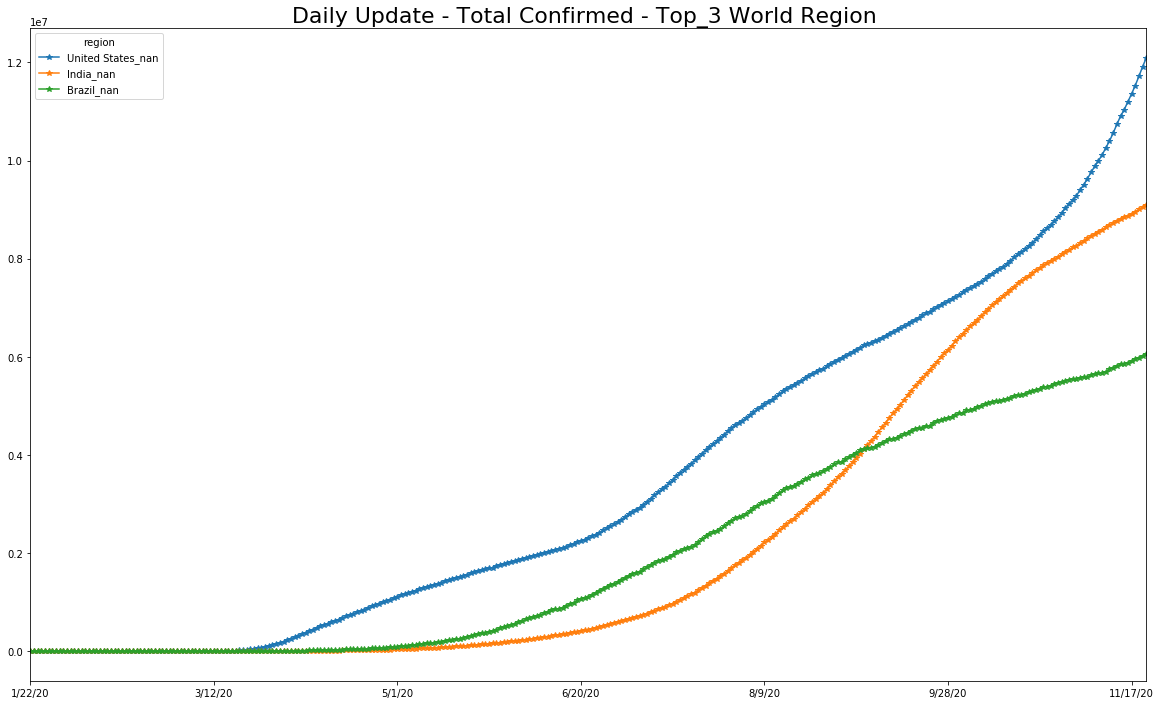

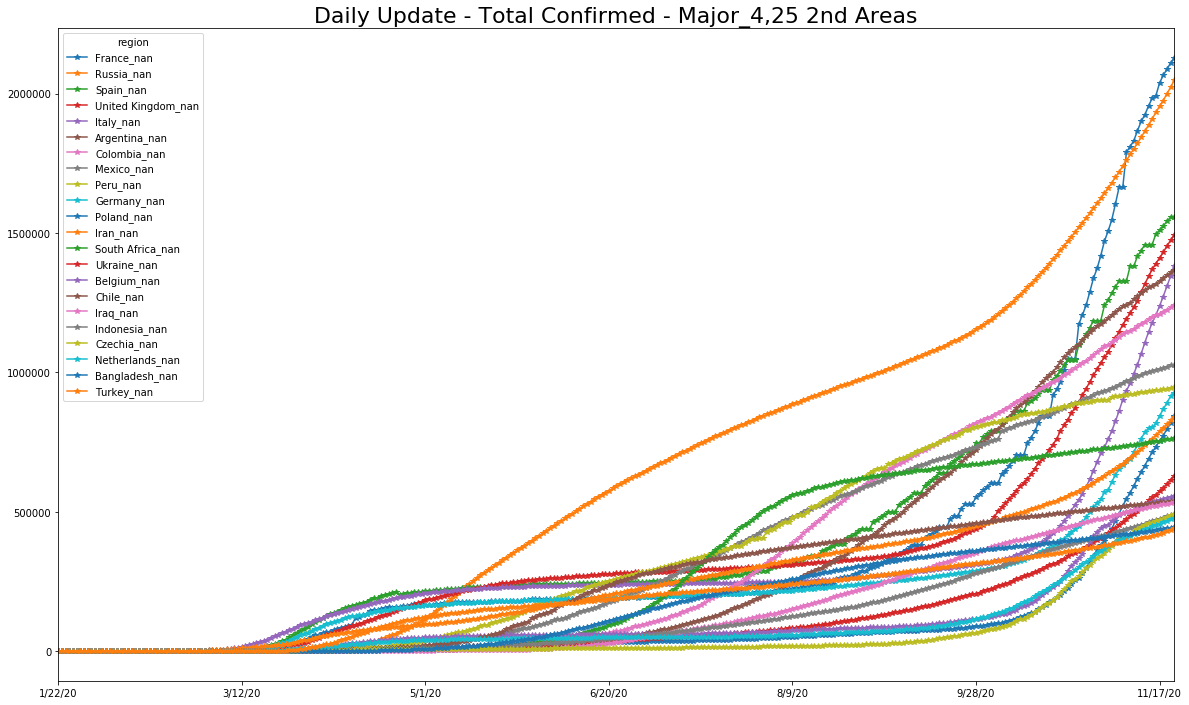

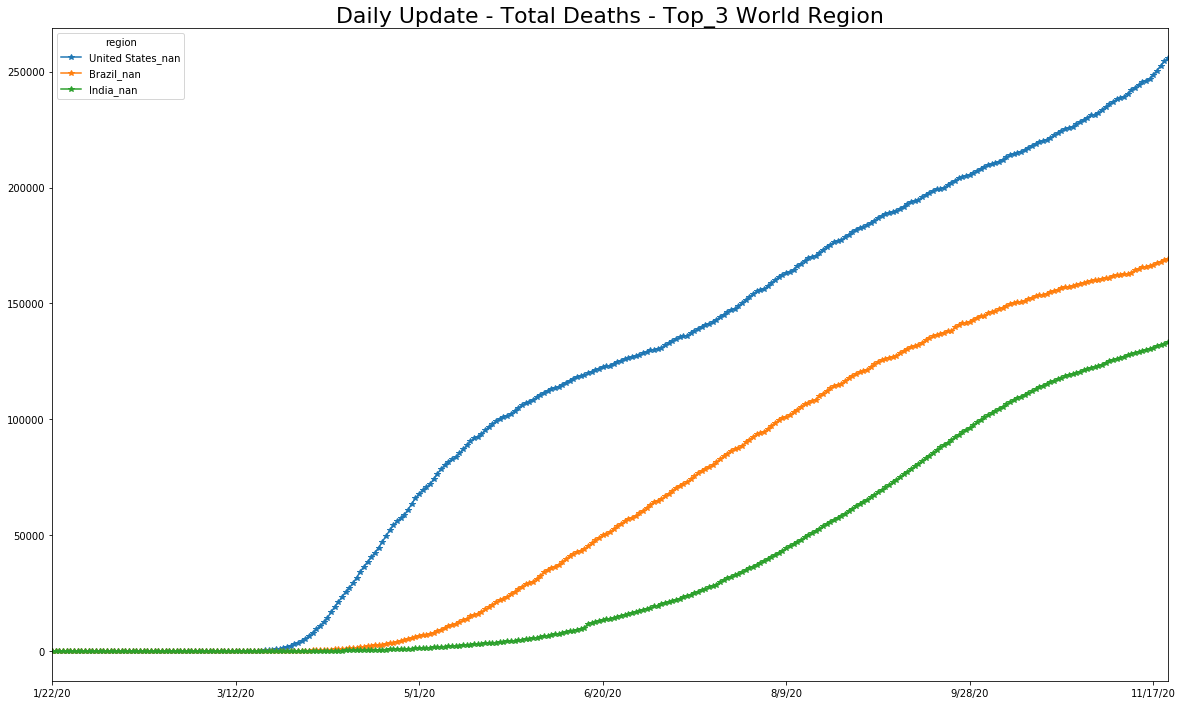

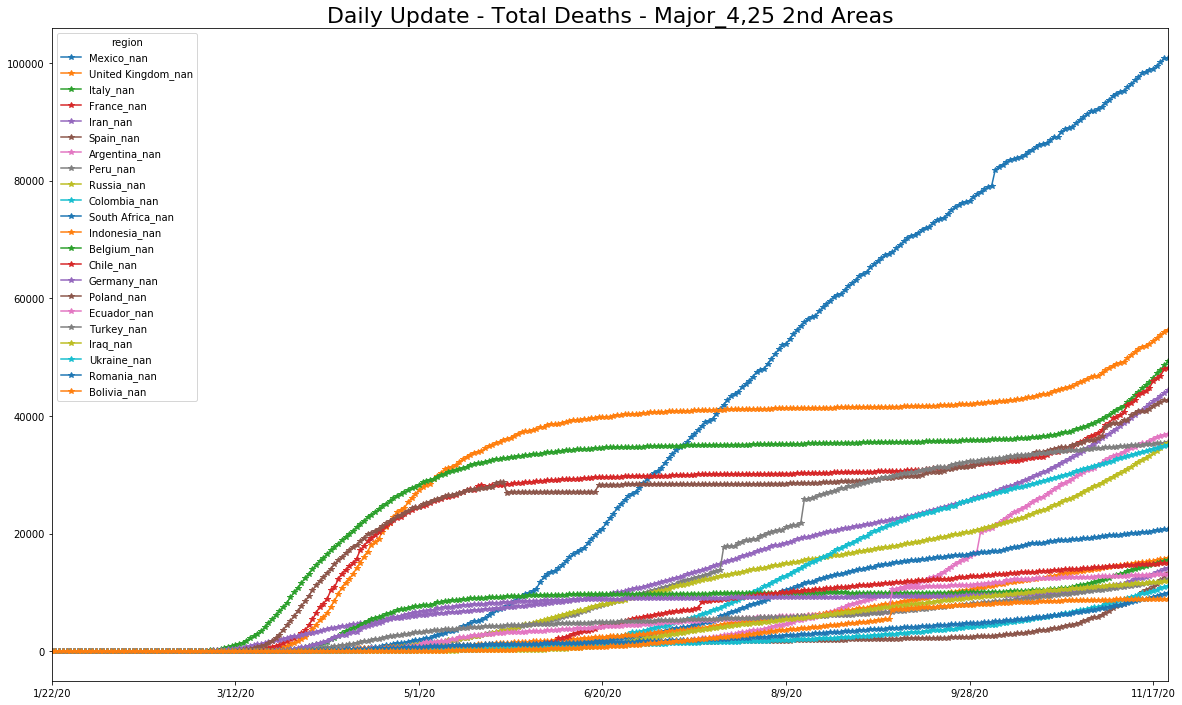

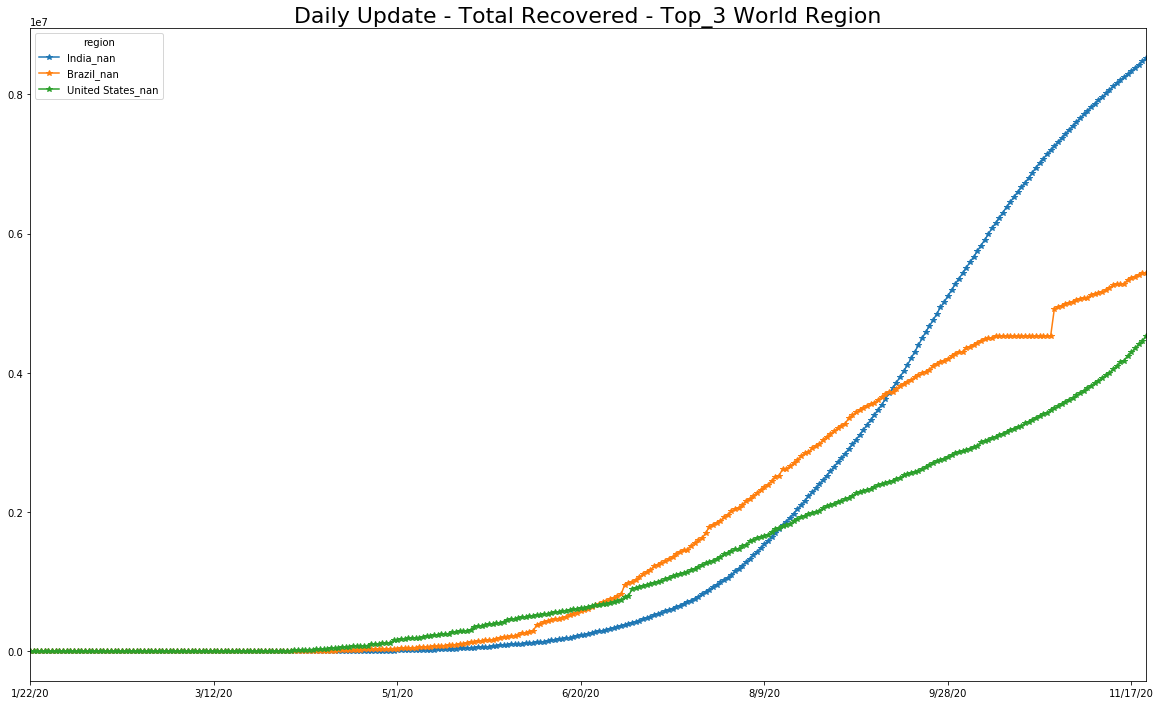

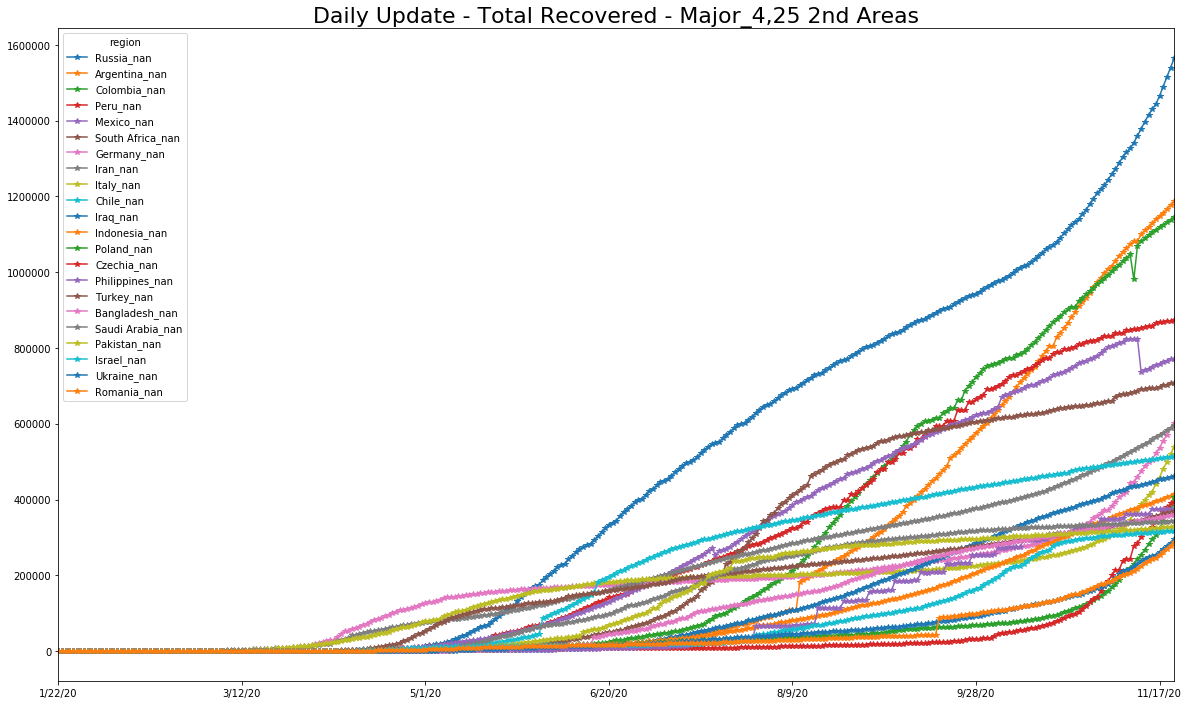

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/11/22


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

date                     region   min   max
0   2020/11/23  Australia_New South Wales    19  26.4
1   2020/11/23                Austria_nan  -3.6  -2.0
2   2020/11/23                Belgium_nan   8.7   9.5
3   2020/11/23                 Brazil_nan  23.7  24.7
4   2020/11/23             Canada_Ontario  -5.4  -4.8
5   2020/11/23              Canada_Quebec    -9  -8.0
6   2020/11/23                  Chile_nan    14  19.0
7   2020/11/23              China_Beijing    -3   3.0
8   2020/11/23            China_Guangdong    24  30.0
9   2020/11/23            China_Hong Kong  21.7  30.0
10  2020/11/23                China_Hubei     7   8.0
11  2020/11/23                China_Macau    22  26.0
12  2020/11/23             China_Shanghai  12.7  17.1
13  2020/11/23                Finland_nan     3   4.0
14  2020/11/23                 France_nan  -0.3   0.4
15  2020/11/23                Germany_nan     4   5.0
16  2020/11/23                  India_nan    14  24.0
17  2020/11/23                   Iran_nan     7  11.0
18  2020/11/23                  Italy_nan   4.2   5.8
19  2020/11/23                  Japan_nan  -1.1  16.1
20  2020/11/23           Korea, South_nan   4.9  12.0
21  2020/11/23               Malaysia_nan  20.3  29.0
22  2020/11/23                 Mexico_nan  10.9  10.9
23  2020/11/23            Netherlands_nan  12.2  12.2
24  2020/11/23                 Norway_nan  -2.2  -1.7
25  2020/11/23                   Peru_nan  23.5  23.7
26  2020/11/23            Philippines_nan  23.9  30.0
27  2020/11/23                 Poland_nan   1.1   3.3
28  2020/11/23               Portugal_nan   6.5   7.3
29  2020/11/23                 Russia_nan    -5  -4.0
30  2020/11/23              Singapore_nan    25  32.0
31  2020/11/23                  Spain_nan   2.8   5.6
32  2020/11/23                 Sweden_nan   6.7   7.8
33  2020/11/23            Switzerland_nan   0.9   1.3
34  2020/11/23                 Turkey_nan  -1.9   1.1
35  2020/11/23          United States_nan   1.4   1.4
36  2020/11/23         United Kingdom_nan   3.9   5.0

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34994         3752        20770          862         576   
7/16/20            35070         3851        21355          877         607   
7/17/20            35229         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
7/15/20  ...         1009           14581            0          10428   
7/16/20  ...         1026           15066            0          10854   
7/17/20  ...         1037           15607            0          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 269 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/18/20            43851        29837        70629         6018       13922   
11/19/20            44228        30623        71652         6066       14134   
11/20/20            44443        31459        72755         6142       14267   
11/21/20            44503        32196        73774         6207       14413   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/18/20                      139        1339337       120459   
11/19/20                      139        1349434       121979   
11/20/20                      139        1359042       123646   
11/21/20                      139        1366182       124839   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
11/18/20                                     115                       4514   
11/19/20                                     115                       4517   
11/20/20                                     115                       4527   
11/21/20                                     115                       4538   

region    ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
11/18/20  ...         4296           70858            1          98350   
11/19/20  ...         4377           70921            1          98665   
11/20/20  ...         4477           71208            1          99017   
11/21/20  ...         4564           71431            1          99435   

region    Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
11/18/20         1300                   66186                  10       2083   
11/19/20         1304                   67296                  10       2086   
11/20/20         1305                   68768                  10       2090   
11/21/20         1306                   70254                  10       2093   

region    Zambia_nan  Zimbabwe_nan  
11/18/20       17280          8981  
11/19/20       17350          9046  
11/20/20       17373          9120  
11/21/20       17394          9172  

[4 rows x 269 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
7602 2020-05-10  Vietnam_nan  26.9  33.0
7603 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35070             0             0   
2     2020-07-17  Afghanistan_nan      35229            76             0   
3     2020-07-18  Afghanistan_nan      35301           159             0   
4     2020-07-19  Afghanistan_nan      35475            72           307   
5     2020-07-20  Afghanistan_nan      35526           174           405   
6     2020-07-21  Afghanistan_nan      35615            51           297   
7     2020-07-22  Afghanistan_nan      35727            89           314   
8     2020-07-23  Afghanistan_nan      35928           112           252   
9     2020-07-24  Afghanistan_nan      35981           201           402   
10    2020-07-25  Afghanistan_nan      36036            53           366   
11    2020-07-26  Afghanistan_nan      36157            55           309   
12    2020-07-27  Afghanistan_nan      36263           121           229   
13    2020-07-28  Afghanistan_nan      36368           106           282   
14    2020-07-29  Afghanistan_nan      36471           105           332   
15    2020-07-30  Afghanistan_nan      36542           103           314   
16    2020-07-31  Afghanistan_nan      36675            71           279   
17    2020-08-01  Afghanistan_nan      36710           133           307   
18    2020-08-02  Afghanistan_nan      36710            35           239   
19    2020-08-03  Afghanistan_nan      36747             0           168   
20    2020-08-04  Afghanistan_nan      36782            37            72   
21    2020-08-05  Afghanistan_nan      36829            35            72   
22    2020-08-06  Afghanistan_nan      36896            47           119   
23    2020-08-07  Afghanistan_nan      37015            67           149   
24    2020-08-08  Afghanistan_nan      37054           119           233   
25    2020-08-09  Afghanistan_nan      37054            39           225   
26    2020-08-10  Afghanistan_nan      37162             0           158   
27    2020-08-11  Afghanistan_nan      37269           108           147   
28    2020-08-12  Afghanistan_nan      37345           107           215   
29    2020-08-13  Afghanistan_nan      37424            76           291   
30    2020-08-14  Afghanistan_nan      37431            79           262   
...          ...              ...        ...           ...           ...   
35995 2020-10-24     Zimbabwe_nan       8269            15            70   
35996 2020-10-25     Zimbabwe_nan       8276            12            54   
35997 2020-10-26     Zimbabwe_nan       8303             7            34   
35998 2020-10-27     Zimbabwe_nan       8315            27            46   
35999 2020-10-28     Zimbabwe_nan       8320            12            46   
36000 2020-10-29     Zimbabwe_nan       8349             5            44   
36001 2020-10-30     Zimbabwe_nan       8362            29            46   
36002 2020-10-31     Zimbabwe_nan       8367            13            47   
36003 2020-11-01     Zimbabwe_nan       8374             5            47   
36004 2020-11-02     Zimbabwe_nan       8389             7            25   
36005 2020-11-03     Zimbabwe_nan       8410            15            27   
36006 2020-11-04     Zimbabwe_nan       8427            21            43   
36007 2020-11-05     Zimbabwe_nan       8444            17            53   
36008 2020-11-06     Zimbabwe_nan       8471            17            55   
36009 2020-11-07     Zimbabwe_nan       8498            27            61   
36010 2020-11-08     Zimbabwe_nan       8531            27            71   
36011 2020-11-09     Zimbabwe_nan       8561            33            87   
36012 2020-11-10     Zimbabwe_nan       8610            30            90   
36013 2020-11-11     Zimbabwe_nan       8667            49           112   
36014 2020-11-12     Zimbabwe_nan       8696            57           136   
36015 2020-11-13     Zimbabwe_nan       8765            29  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
36024 2020-11-22  Zimbabwe_nan          0            52           191   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
36024           386         100.570285         102.126823         104.393467   

       last_day  kalman_prediction  population  infected_rate  min  max  
36024      9172             9221.0    14862924       0.000006  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
36024 2020-11-22  Zimbabwe_nan          0            52           191   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
36024           386         100.570285         102.126823         104.393467   

       last_day  kalman_prediction  population  infected_rate  min  max  
36024      9172             9221.0    14862924       0.000006  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
35236  2020-11-20  Zimbabwe_nan       9120            65           149   
35237  2020-11-21  Zimbabwe_nan       9172            74           175   
35238  2020-11-22  Zimbabwe_nan          0            52           191   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
35236           350         100.723861         101.674834         104.024954   
35237           355         100.818152         101.956512         104.050314   
35238           386         100.570285         102.126823         104.393467   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
35236                 9046  ...    14862924       0.000006  NaN  NaN   
35237                 9120  ...    14862924       0.000006  NaN  NaN   
35238                 9172  ...    14862924       0.000006  NaN  NaN   

       population_percentage : infected_rate confirmed  \
35236                                         0.000609   
35237                                         0.000614   
35238                                         0.000617   

       population_percentage : factor 9/10 infected_rate confirmed  \
35236                                           0.006087             
35237                                           0.006137             
35238                                           0.006172             

       delta : new_cases  delta : new_cases per 1M hab  \
35236               43.0                      2.893105   
35237               38.0                      2.556697   
35238               49.0                      3.296794   

       delta : roling 7day AVG  \
35236                50.000000   
35237                50.714286   
35238                55.142857   

       delta : aprox 14-day case notification rate per 100k hab  
35236                                           4.709706         
35237                                           4.776987         
35238                                           5.194133         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
258  United States_nan  1.156521e+12  1.075416e+06  111846.676923


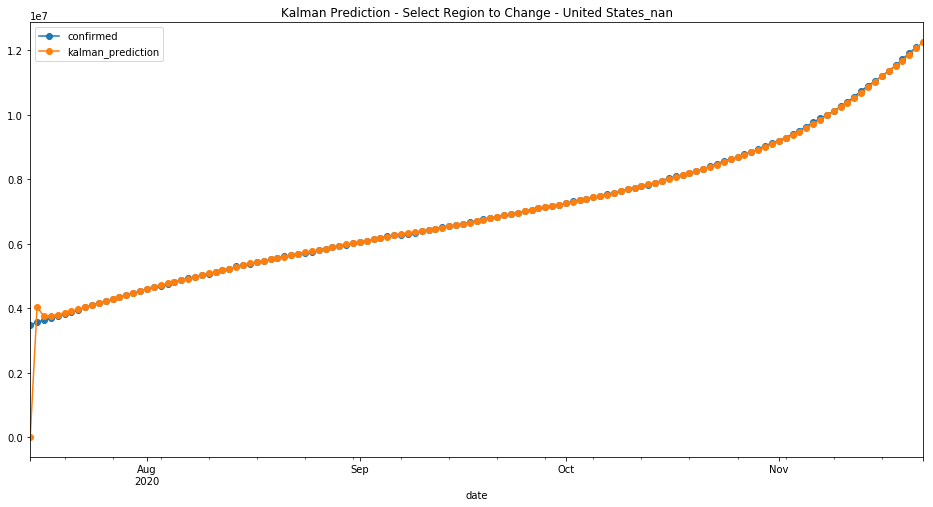

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
209  Russia_nan  3.302868e+10  181737.934405  18245.223077


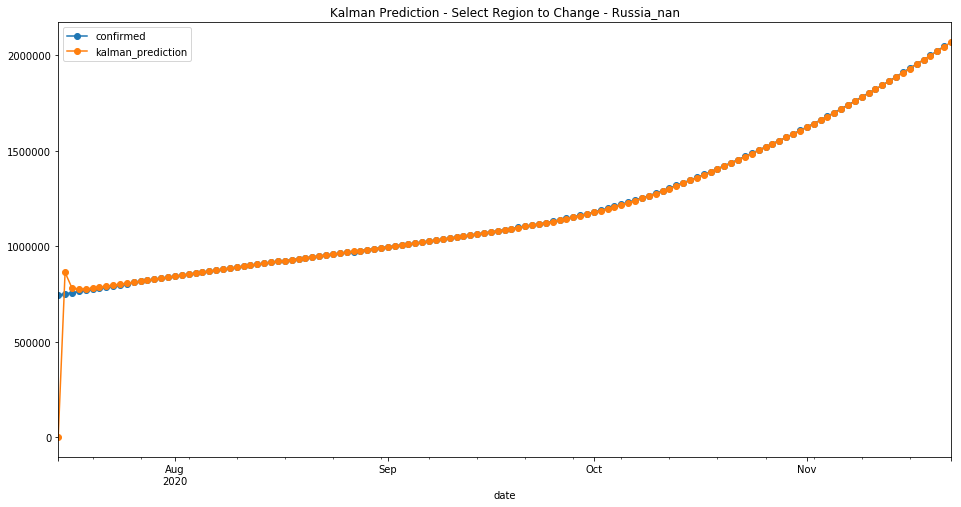

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  2.853571e+11  534188.268926  64134.761538


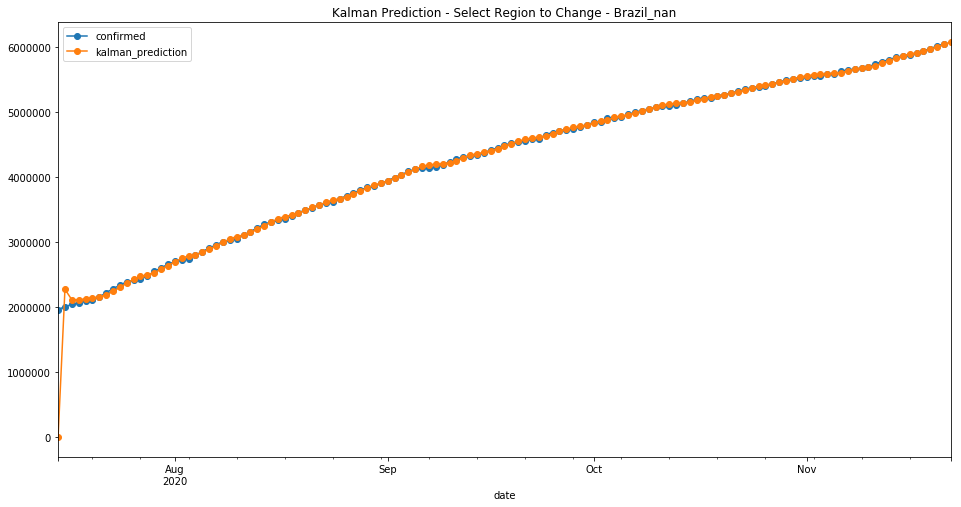

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
257  United Kingdom_nan  1.773187e+10  133161.074851  14205.730769


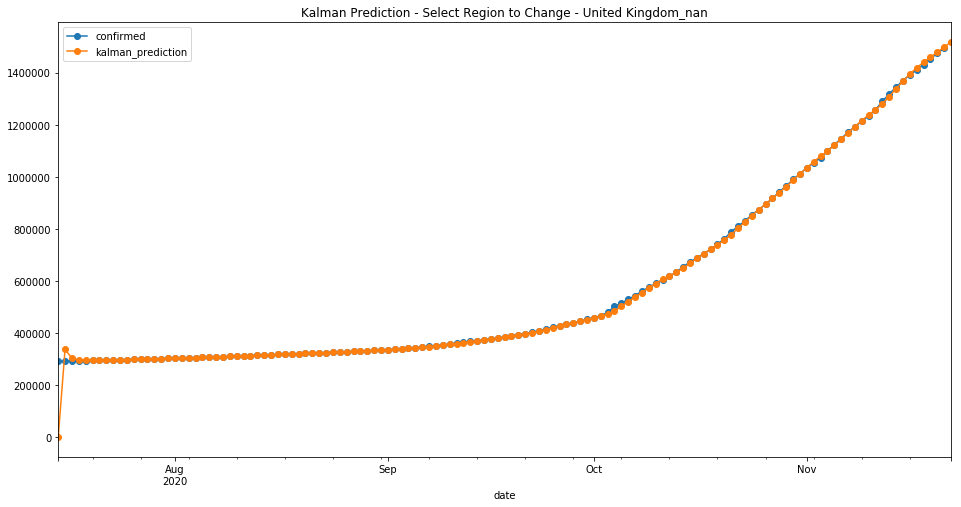

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgitug8un
  JVM stdout: /tmp/tmpgitug8un/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgitug8un/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    1 month and 24 days
H2O_cluster_name:           H2O_from_python_unknownUser_3vgep7
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-11-14
last_train_date= 2020-11-21
first_bootstrap_date= 2020-11-13
boost_bootstrap_date= 2020-11-18
first_test_date= 2020-11-12
last_test_date= 2020-11-22
first_valid_date= 2020-11-20


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   42972.0      42969 2020-11-13  Afghanistan_nan
1   43171.0      43035 2020-11-14  Afghanistan_nan
2   43296.0      43240 2020-11-15  Afghanistan_nan
3   43471.0      43403 2020-11-16  Afghanistan_nan
4   43641.0      43628 2020-11-17  Afghanistan_nan
5   43850.0      43851 2020-11-18  Afghanistan_nan
6   44079.0      44228 2020-11-19  Afghanistan_nan
7   44419.0      44443 2020-11-20  Afghanistan_nan
8   44708.0      44503 2020-11-21  Afghanistan_nan
9   44865.0          0 2020-11-22  Afghanistan_nan
10  26733.0      26701 2020-11-13      Albania_nan
11  27196.0      27233 2020-11-14      Albania_nan
12  27697.0      27830 2020-11-15      Albania_nan
13  28255.0      28432 2020-11-16      Albania_nan
14  28859.0      29126 2020-11-17      Albania_nan
15  29528.0      29837 2020-11-18      Albania_nan
16  30262.0      30623 2020-11-19      Albania_nan
17  31063.0      31459 2020-11-20      Albania_nan
18  31933.0      32196 2020-11-21      Albania_nan
19  32781.0          0 2020-11-22      Albania_nan
20  65796.0      65975 2020-11-13      Algeria_nan
21  66714.0      66819 2020-11-14      Algeria_nan
22  67622.0      67679 2020-11-15      Algeria_nan
23  68532.0      68589 2020-11-16      Algeria_nan
24  69472.0      69591 2020-11-17      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  80725.0      81397 2020-11-18  Azerbaijan_nan
176  83019.0      83994 2020-11-19  Azerbaijan_nan
177  85657.0      87163 2020-11-20  Azerbaijan_nan
178  88870.0      89898 2020-11-21  Azerbaijan_nan
179  91910.0          0 2020-11-22  Azerbaijan_nan
180   7186.0       7163 2020-11-13     Bahamas_nan
181   7280.0       7163 2020-11-14     Bahamas_nan
182   7357.0       7186 2020-11-15     Bahamas_nan
183   7340.0       7256 2020-11-16     Bahamas_nan
184   7319.0       7312 2020-11-17     Bahamas_nan
185   7401.0       7323 2020-11-18     Bahamas_nan
186   7499.0       7348 2020-11-19     Bahamas_nan
187   7498.0       7367 2020-11-20     Bahamas_nan
188   7522.0       7395 2020-11-21     Bahamas_nan
189   7533.0          0 2020-11-22     Bahamas_nan
190  84139.0      84349 2020-11-13     Bahrain_nan
191  84292.0      84523 2020-11-14     Bahrain_nan
192  84453.0      84703 2020-11-15     Bahrain_nan
193  84620.0      84882 2020-11-16     Bahrain_nan
194  84790.0      85008 2020-11-17     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  111482.0     111622 2020-11-13  Belarus_nan
221  112653.0     112870 2020-11-14  Belarus_nan
222  113912.0     114185 2020-11-15  Belarus_nan
223  115252.0     115448 2020-11-16  Belarus_nan
224  116577.0     116699 2020-11-17  Belarus_nan
225  117895.0     118008 2020-11-18  Belarus_nan
226  119250.0     119390 2020-11-19  Belarus_nan
227  120657.0     120847 2020-11-20  Belarus_nan
228  122134.0     122435 2020-11-21  Belarus_nan
229  123740.0          0 2020-11-22  Belarus_nan
230  526886.0     525012 2020-11-13  Belgium_nan
231  530991.0     531280 2020-11-14  Belgium_nan
232  536990.0     535939 2020-11-15  Belgium_nan
233  541519.0     537871 2020-11-16  Belgium_nan
234  543514.0     540605 2020-11-17  Belgium_nan
235  546279.0     545787 2020-11-18  Belgium_nan
236  550703.0     550264 2020-11-19  Belgium_nan
237  554385.0     553680 2020-11-20  Belgium_nan
238  557634.0     556904 2020-11-21  Belgium_nan
239  560934.0          0 2020-11-22  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2324861687.986507
# MSE on the validation data =  2508892881028.5376
# R^2 on the training data =  0.9992069947355684
# R^2 on the validation data =  0.4390432239959867


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1606024961863_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           17020575.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0       22.95      2356.0      2763.0     2663.248



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2324861687.986507
RMSE: 48216.819554865986
MAE: 4604.7798062667625
RMSLE: 0.23169906586803315
Mean Residual Deviance: 2324861687.986507

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 2508892881028.5376
RMSE: 1583948.5095887864
MAE: 405286.458623622
RMSLE: 7.11251750051521
Mean Residual Deviance: 2508892881028.5376

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-11-22 06:02:51   0.108 sec              0.0            NaN   
1     2020-11-22 06:02:51   0.567 sec              1.0  122954.884556   
2     2020-11-22 06:02:51   0.913 sec              2.0   91020.944981   
3     2020-11-22 06:02:52   1.200 sec              3.0   87235.858344   
4     2020-11-22 06:02:52   1.282 sec              4.0   80104.749476   
5     2020-11-22 06:02:52   1.388 sec              5.0   79894.626358   
6     2020-11-22 06:02:52   1.470 sec              6.0   80017.662347   
7     2020-11-22 06:02:52   1.571 sec              7.0   75006.815384   
8     2020-11-22 06:02:52   1.656 sec              8.0   71664.695366   
9     2020-11-22 06:02:52   1.721 sec              9.0   66009.717872   
10    2020-11-22 06:02:52   1.832 sec             10.0   63382.425534   
11    2020-11-22 06:02:52   1.956 sec             11.0   62759.689874   
12    2020-11-22 06:02:52   2.065 sec             12.0   61937.486939   
13    2020-11-22 06:02:53   2.169 sec             13.0   62727.187940   
14    2020-11-22 06:02:53   2.333 sec             14.0   62232.507133   
15    2020-11-22 06:02:53   2.450 sec             15.0   61215.821541   
16    2020-11-22 06:02:53   2.558 sec             16.0   60867.567337   
17    2020-11-22 06:02:53   2.696 sec             17.0   62434.340826   
18    2020-11-22 06:02:53   2.812 sec             18.0   62137.428214   
19    2020-11-22 06:02:53   2.887 sec             19.0   63094.370617   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   16838.912485       1.511790e+10     1.590142e+06   403741.000535   
2   13273.851528       8.284812e+09     1.582790e+06   403232.460950   
3   13594.241611       7.610095e+09     1.576389e+06   402878.431866   
4   12003.255863       6.416771e+09     1.580989e+06   403231.894174   
5   11772.862828       6.383151e+09     1.582723e+06   403844.832963   
6   11342.327847       6.402826e+09     1.581784e+06   402952.071917   
7   10721.828594       5.626022e+09     1.584190e+06   404939.666896   
8   10175.654409       5.135829e+09     1.581949e+06   404450.525041   
9    9656.687231       4.357283e+09     1.583646e+06   405363.351968   
10   9216.367352       4.017332e+09     1.596856e+06   410500.941686   
11   8912.966597       3.938779e+09     1.594813e+06   409585.760214   
12   8746.414405       3.836252e+09     1.594270e+06   408833.262460   
13   8805.140534       3.934700e+09     1.593592e+06   408268.655133   
14   8547.471908       3.872885e+09     1.592955e+06   407471.497932   
15   8218.610386       3.747377e+09     1.592577e+06   406953.968858   
16   8049.410861       3.704861e+09     1.591607e+06   406405.154520   
17   8169.847045       3.898047e+09     1.591390e+06   406031.993863   
18   8080.114606       3.861060e+09     1.589587e+06   405778.704506   
19   8065.832443       3.980900e+09     1.589538e+06   405572.958430   

    validation_deviance  
0                   NaN  
1          2.528552e+12  
2          2.505223e+12  
3          2.485003e+12  
4          2.499525e+12  
5          2.505011e+12  
6          2.502040e+12  
7          2.509658e+12  
8          2.502563e+12  
9          2.507936e+12  
10         2.549948e+12  
11         2.543427e+12  
12         2.541698e+12  
13         2.539537e+12  
14         2.537505e+12  
15         2.536303e+12  
16         2.533211e+12  
17         2.532522e+12  
18         2.526785e+12  
19         2.526632e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.523298e+18           1.000000    0.355505
1            last_day         2.283097e+18           0.904807    0.321663
2              region         9.131678e+17           0.361895    0.128655
3        7_day_change         4.995341e+17           0.197969    0.070379
4        1_day_change         4.090737e+17           0.162119    0.057634
5        3_day_change         2.857304e+17           0.113237    0.040256
6       infected_rate         9.118959e+16           0.036139    0.012848
7   7_day_change_rate         3.640466e+16           0.014427    0.005129
8   3_day_change_rate         2.474546e+16           0.009807    0.003486
9   1_day_change_rate         1.992000e+16           0.007894    0.002807
10                max         7.906182e+15           0.003133    0.001114
11                min         3.721456e+15           0.001475    0.000524

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.523298e+18           1.000000    0.355505
1            last_day         2.283097e+18           0.904807    0.321663
2              region         9.131678e+17           0.361895    0.128655
3        7_day_change         4.995341e+17           0.197969    0.070379
4        1_day_change         4.090737e+17           0.162119    0.057634
5        3_day_change         2.857304e+17           0.113237    0.040256
6       infected_rate         9.118959e+16           0.036139    0.012848
7   7_day_change_rate         3.640466e+16           0.014427    0.005129
8   3_day_change_rate         2.474546e+16           0.009807    0.003486
9   1_day_change_rate         1.992000e+16           0.007894    0.002807
10                max         7.906182e+15           0.003133    0.001114
11                min         3.721456e+15           0.001475    0.000524

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


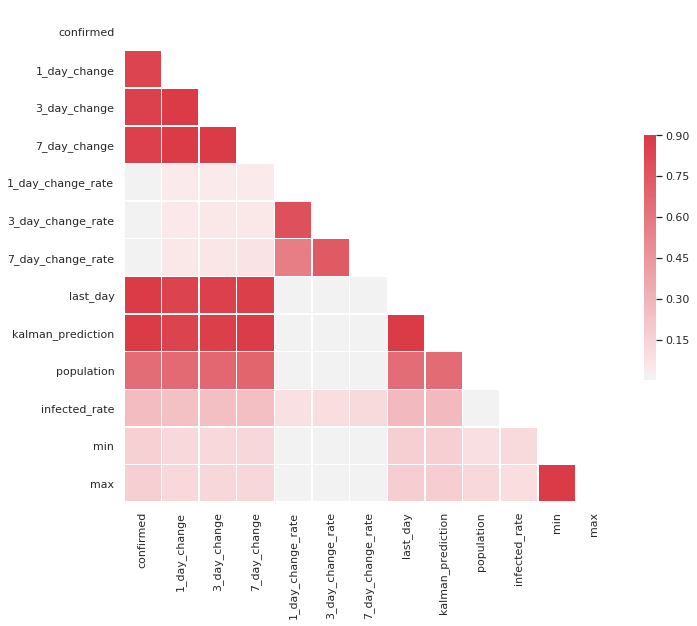

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.840846
3_day_change         0.856622
7_day_change         0.865482
1_day_change_rate    0.023348
3_day_change_rate    0.025520
7_day_change_rate    0.027948
last_day             0.988370
kalman_prediction    0.989048
population           0.650076
infected_rate        0.265048
min                  0.161763
max                  0.168474
Name: confirmed, dtype: float64


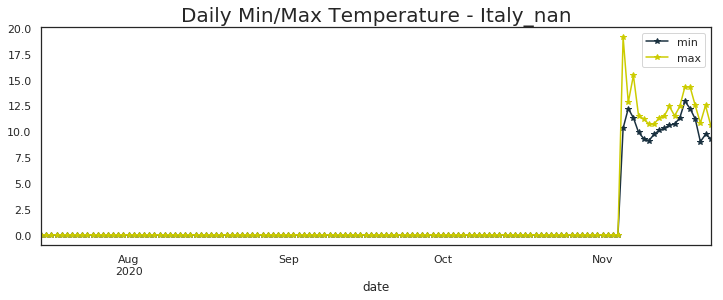

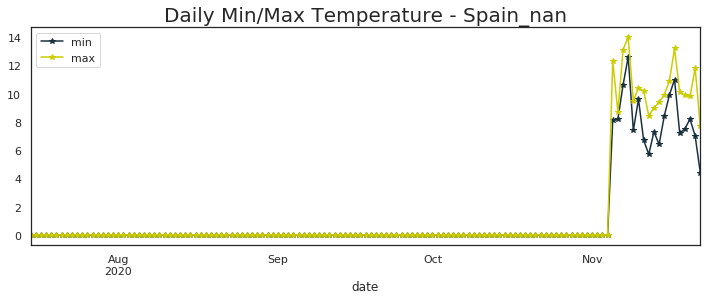

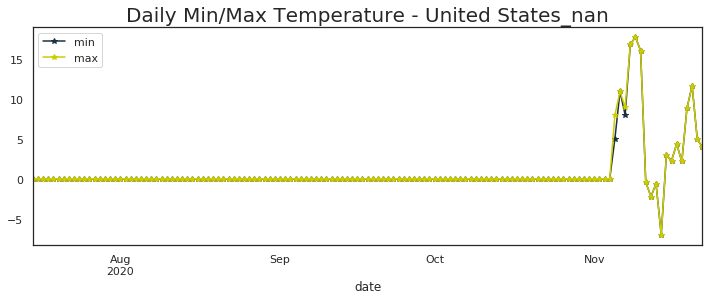

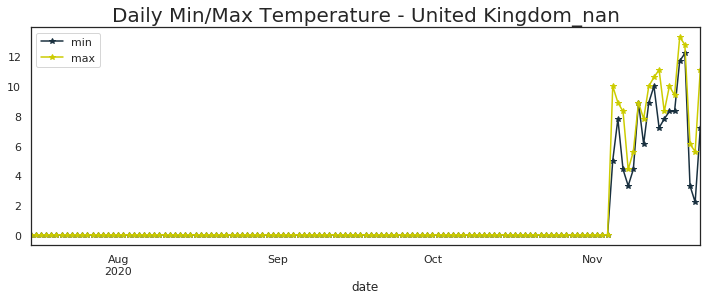

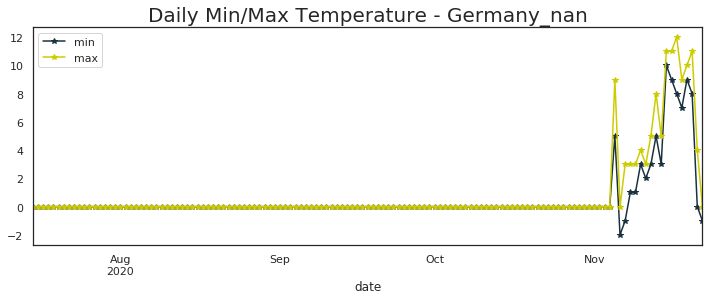

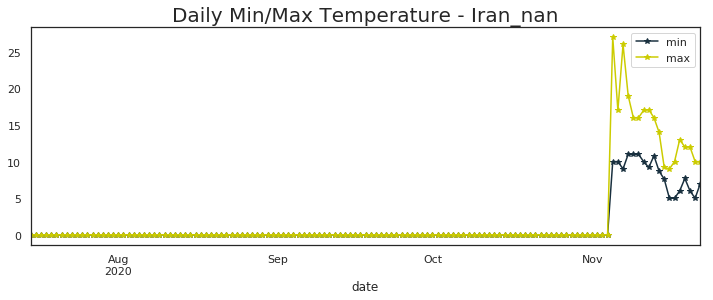

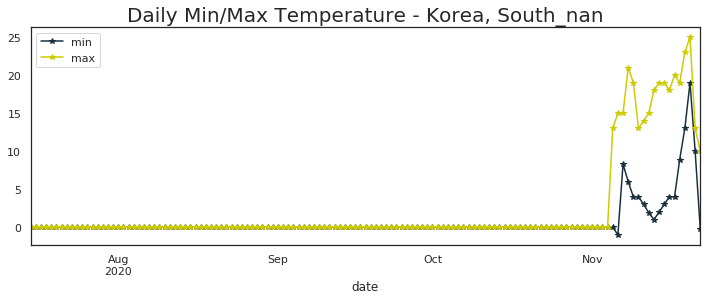

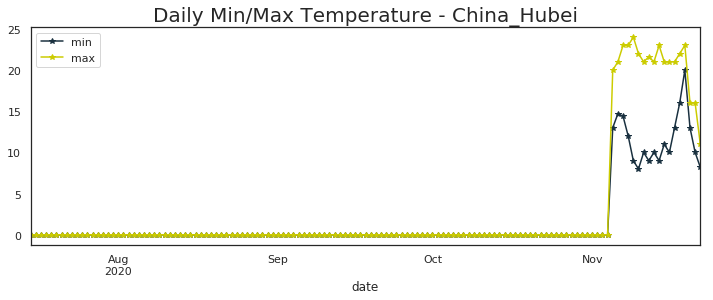

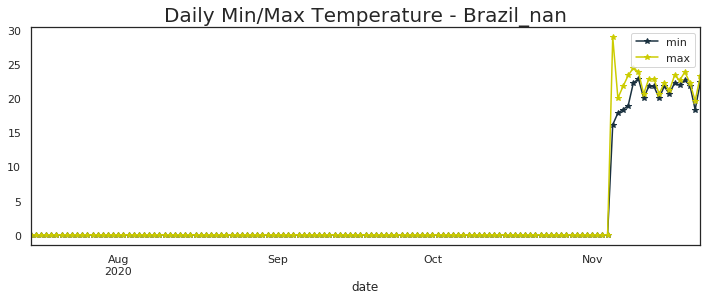

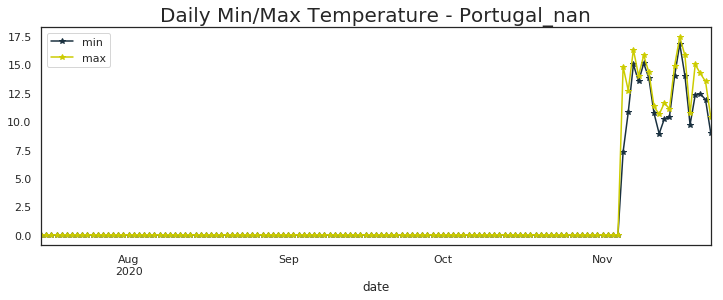

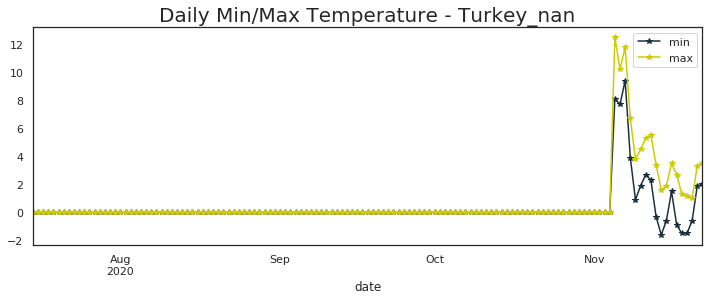

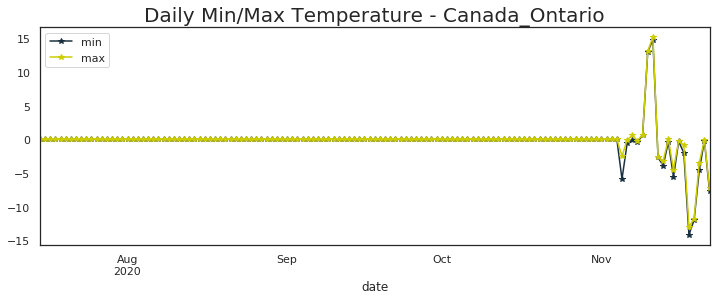

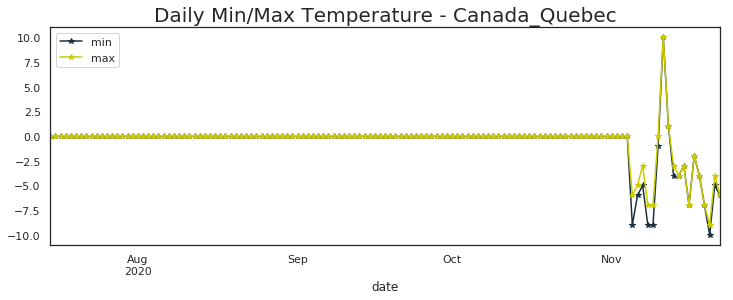

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                          min   max
region                             
United States_nan        17.8  17.8
India_nan                22.0  31.0
Brazil_nan               22.8  28.9
France_nan               12.1  13.3
Russia_nan                0.0   4.0
Spain_nan                12.6  14.0
United Kingdom_nan       12.2  13.3
Italy_nan                12.9  19.1
Argentina_nan             0.0   0.0
Colombia_nan              0.0   0.0
Mexico_nan               15.1  15.1
Peru_nan                 24.6  29.9
Germany_nan              10.0  12.0
Poland_nan                8.9  10.6
Iran_nan                 11.0  27.0
South Africa_nan          0.0   0.0
Ukraine_nan               0.0   0.0
Belgium_nan              13.7  14.5
Chile_nan                17.0  22.0
Iraq_nan                  0.0   0.0
Indonesia_nan             0.0   0.0
Czechia_nan               0.0   0.0
Netherlands_nan          14.4  16.1
Bangladesh_nan            0.0   0.0
Turkey_nan                9.

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

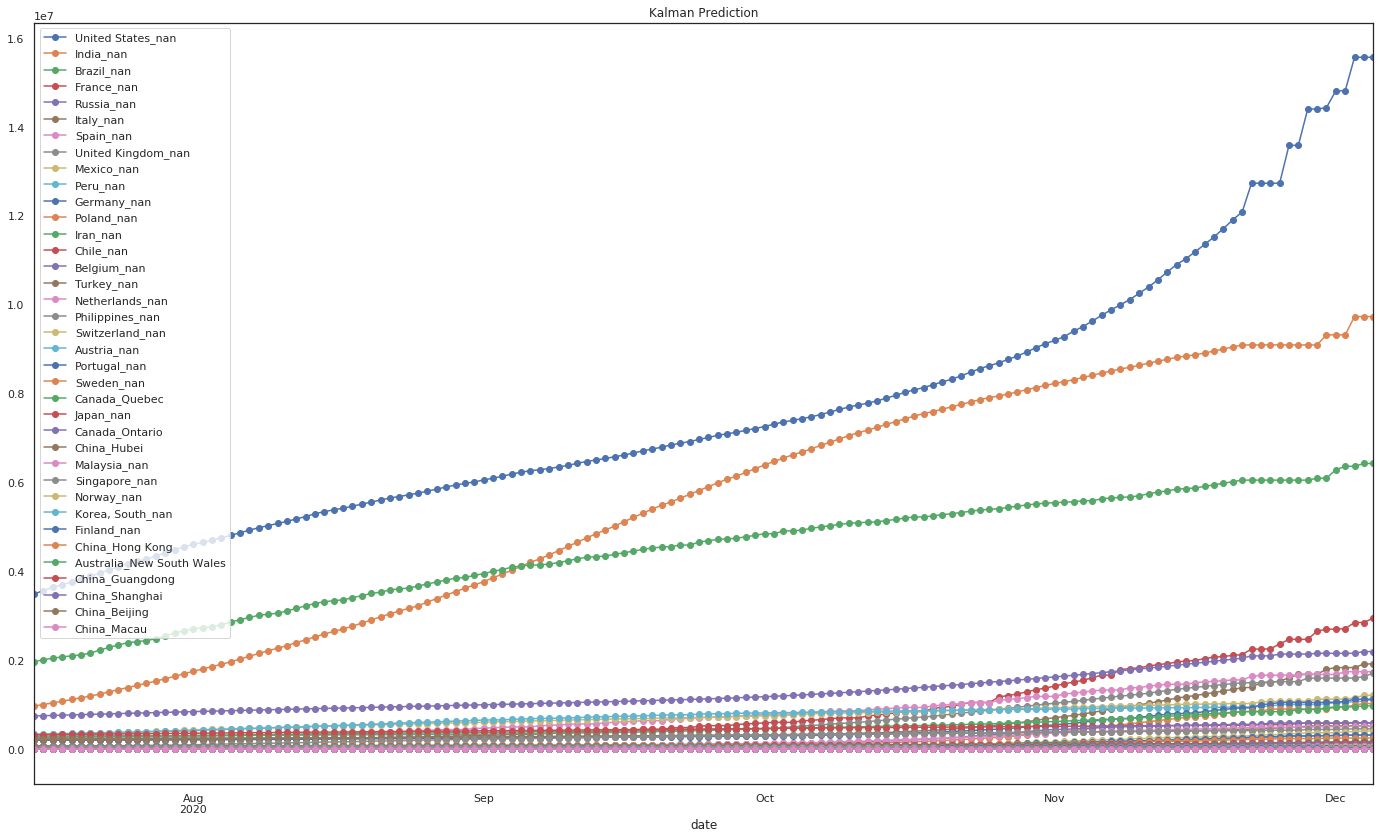

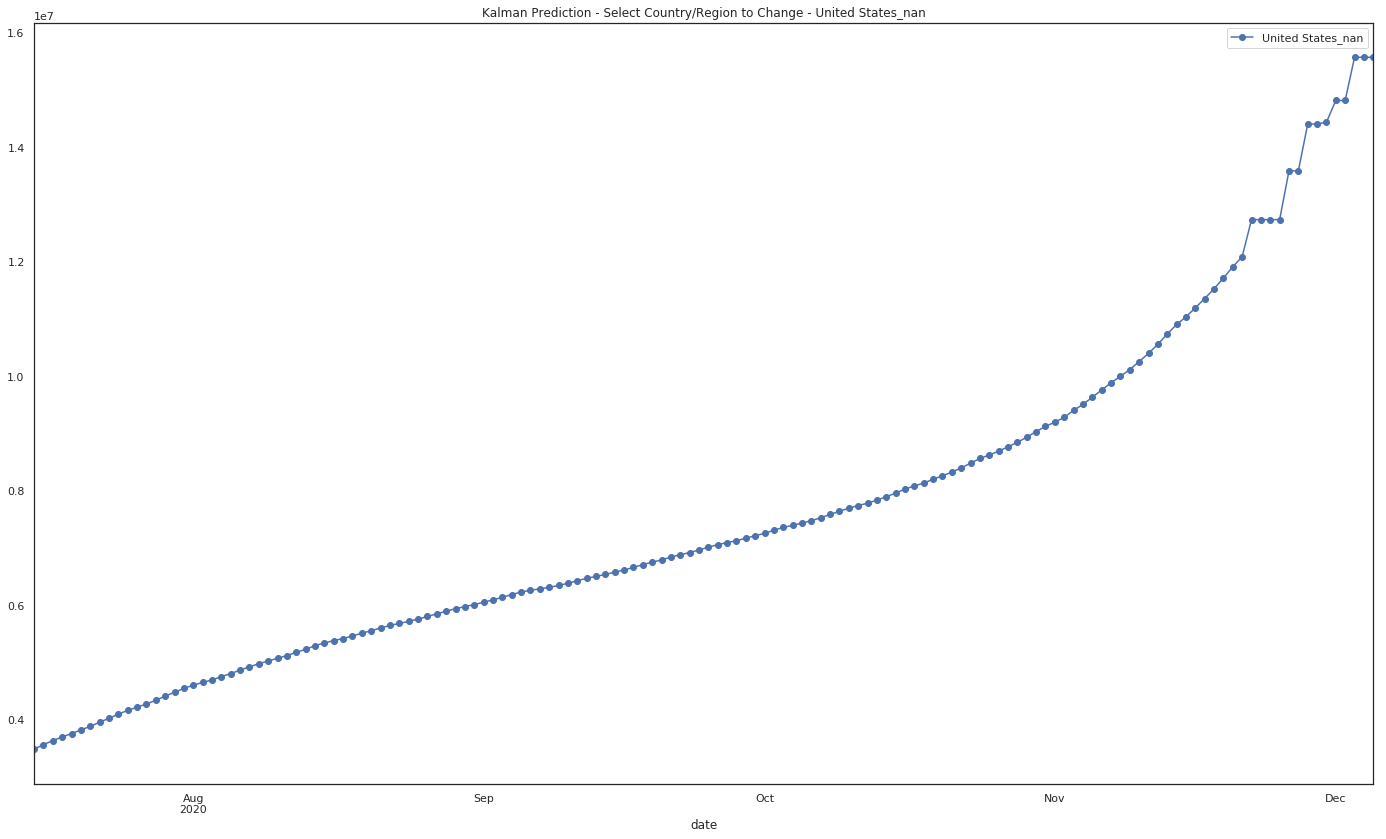

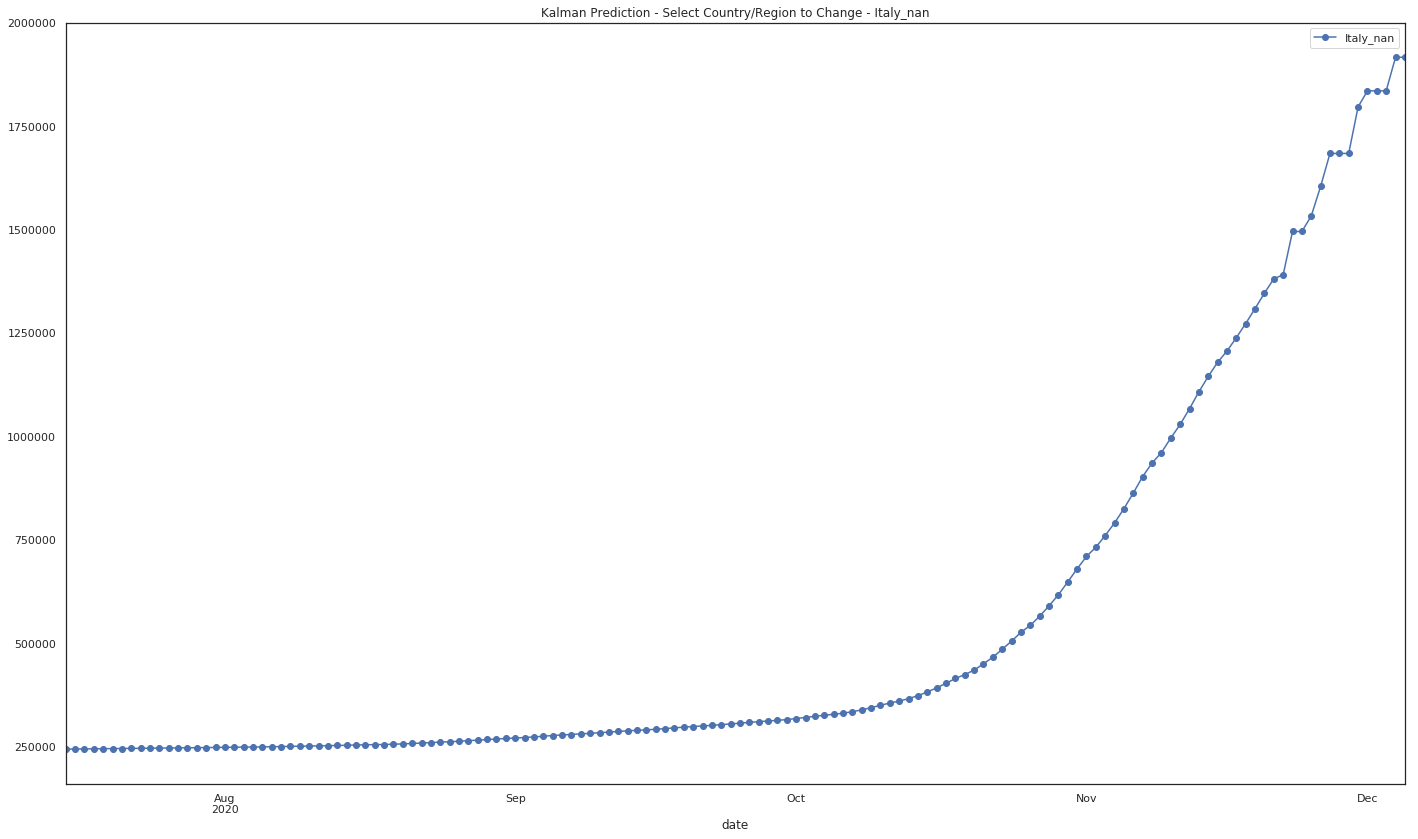

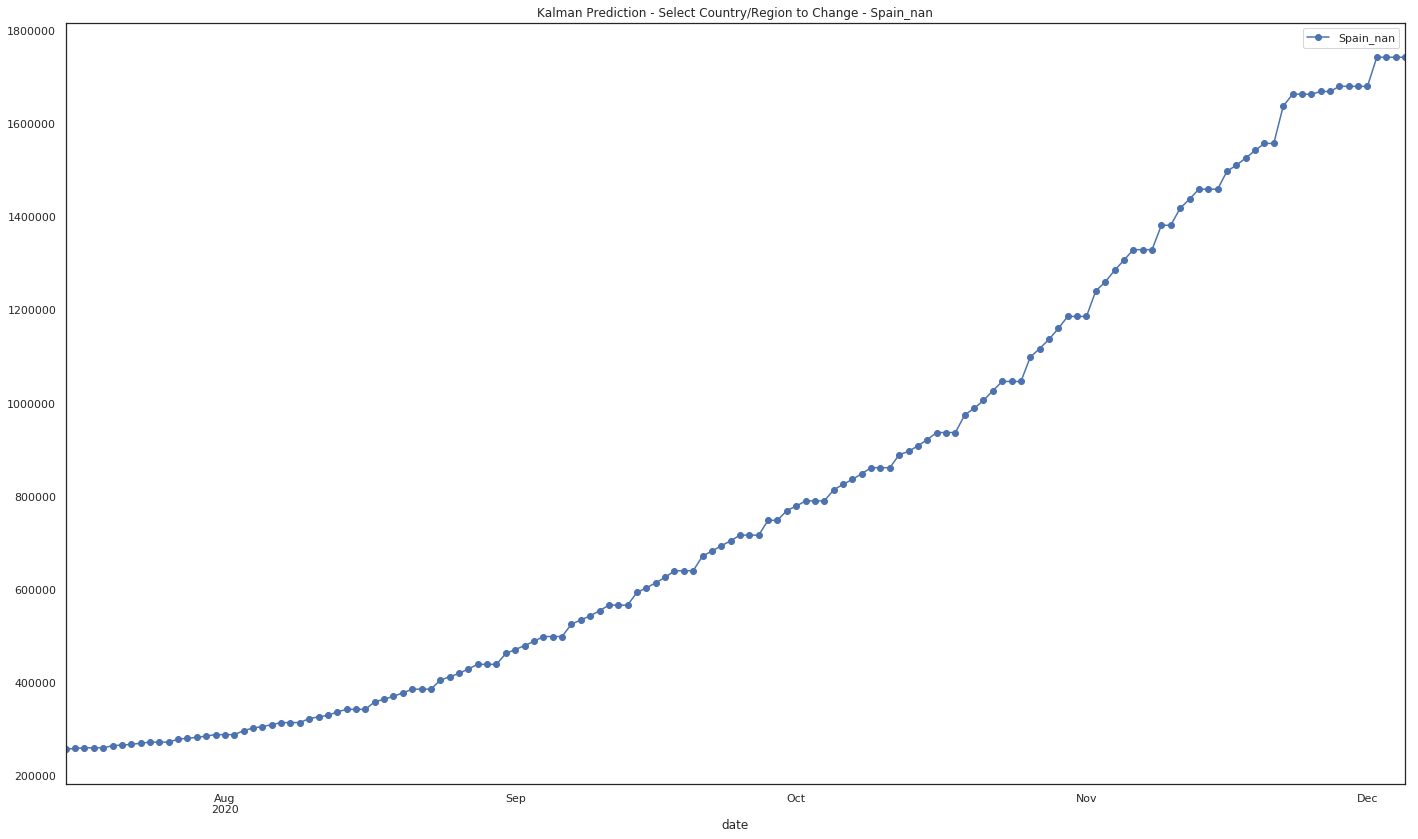

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


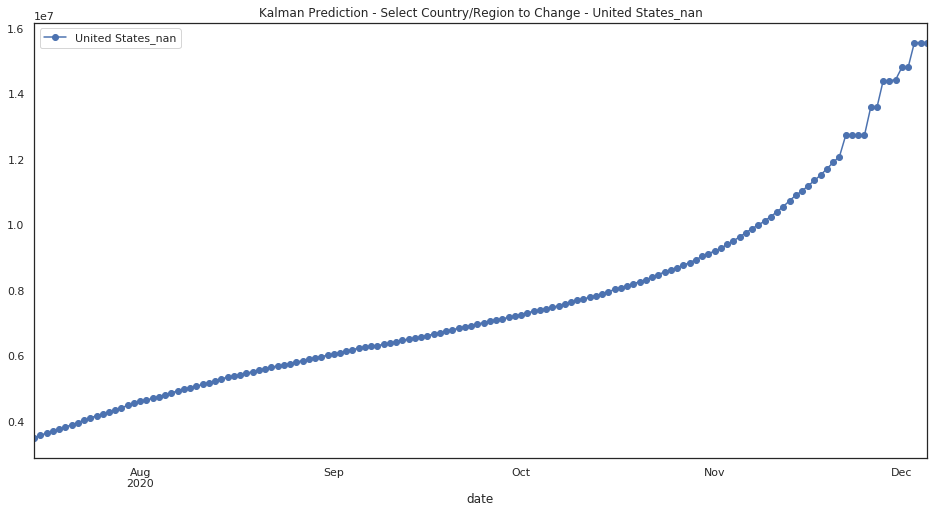

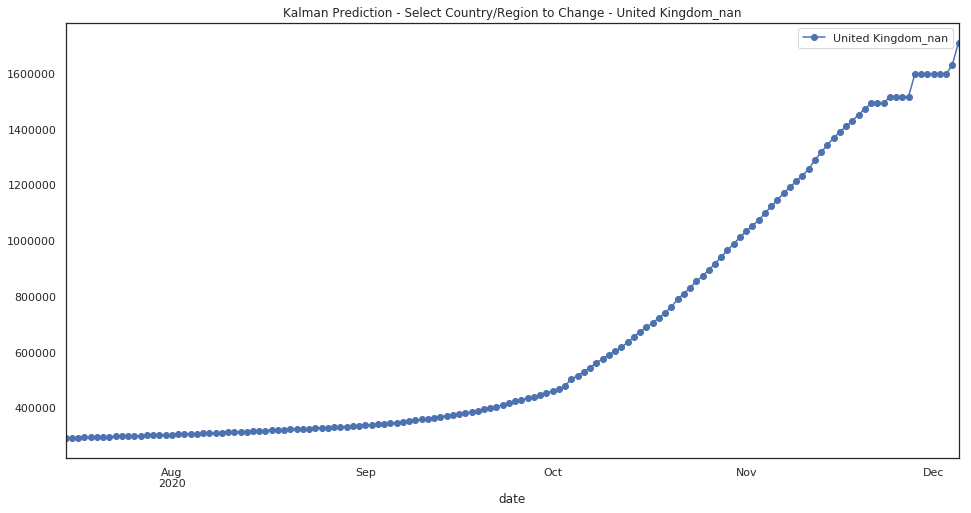

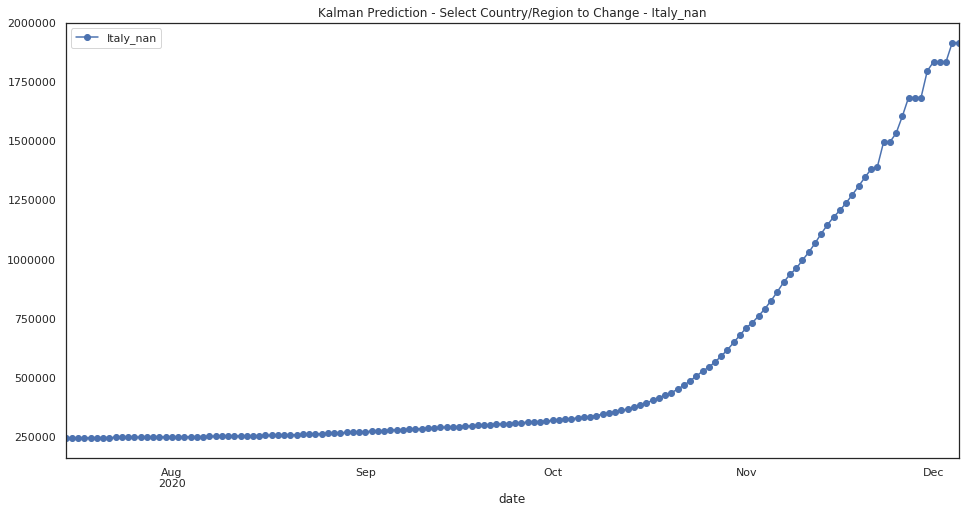

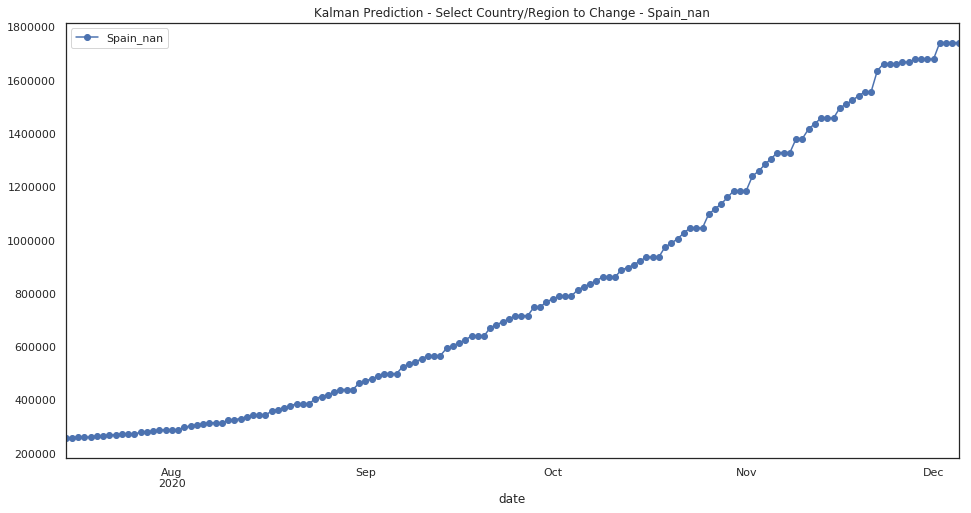

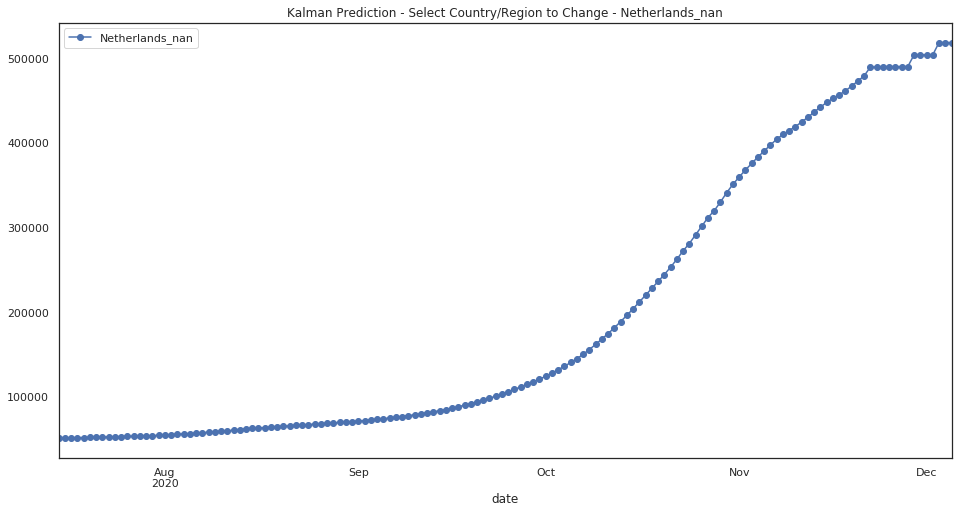

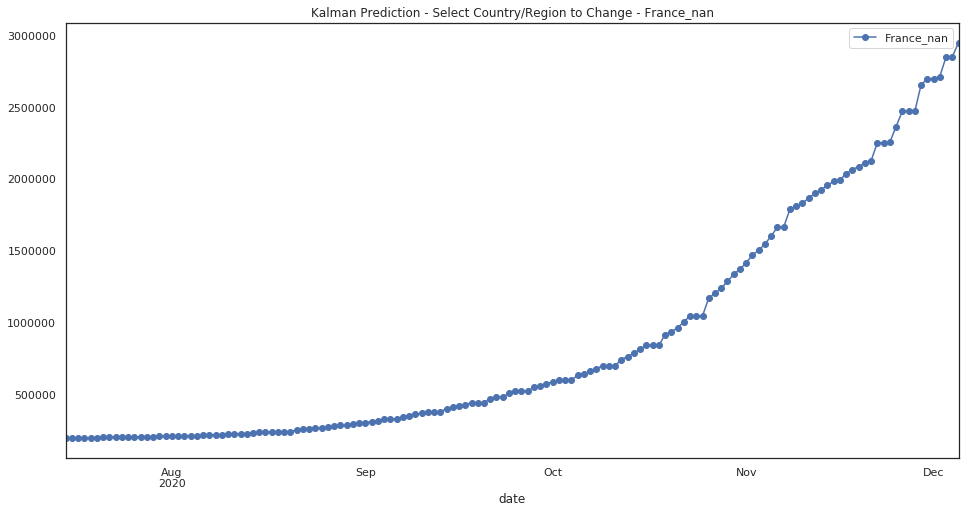

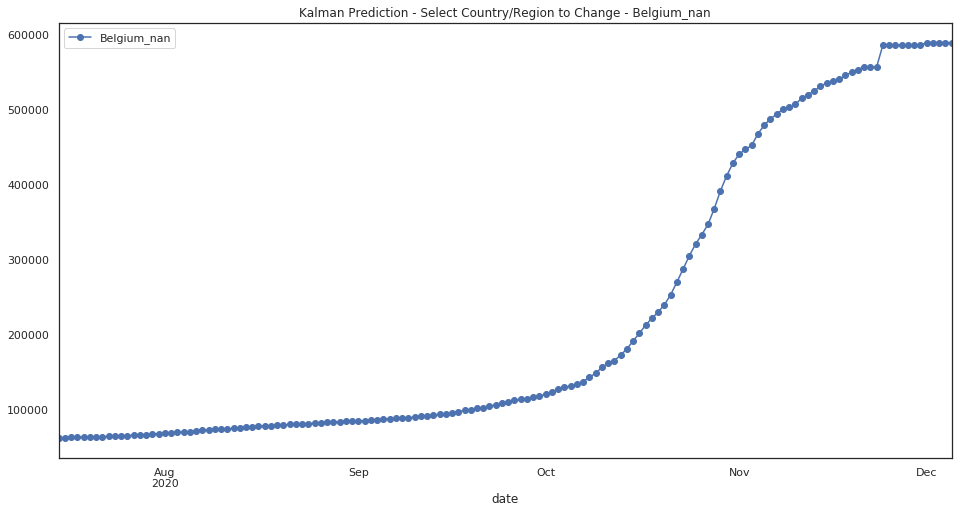

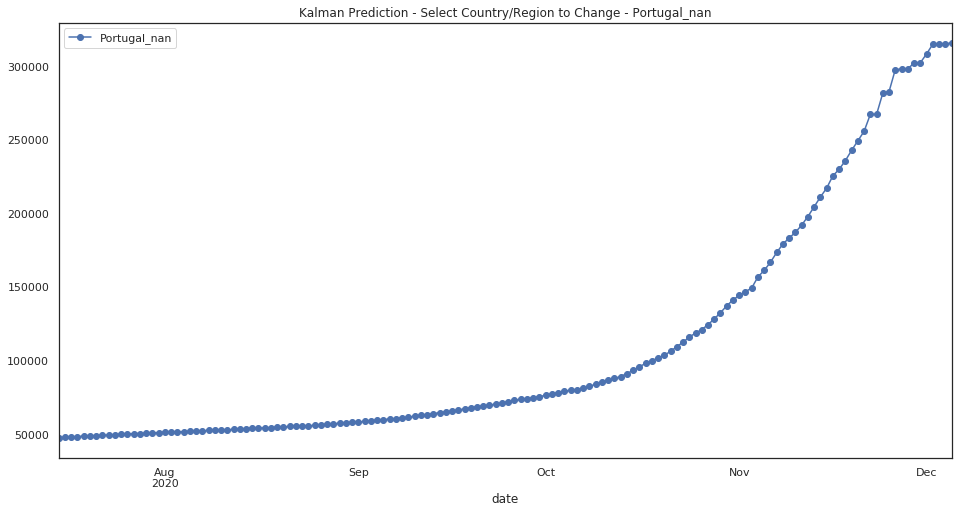

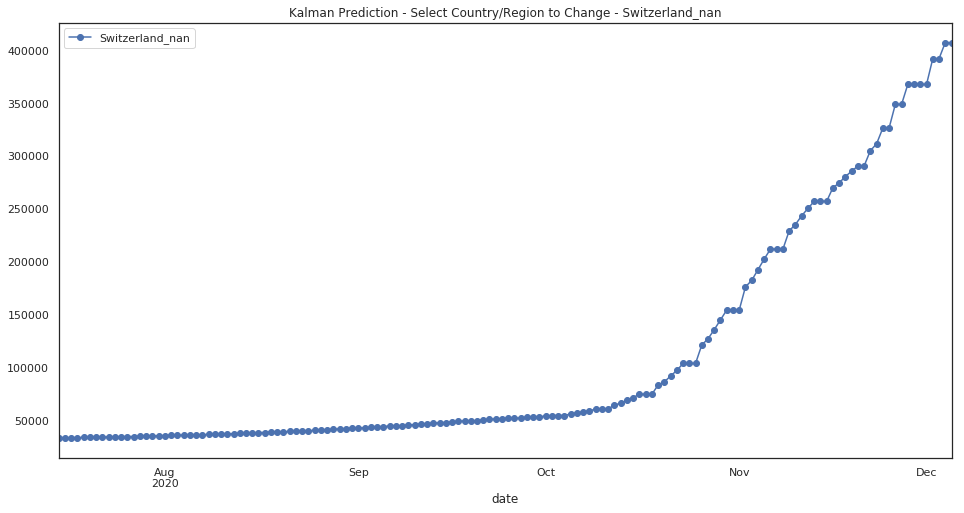

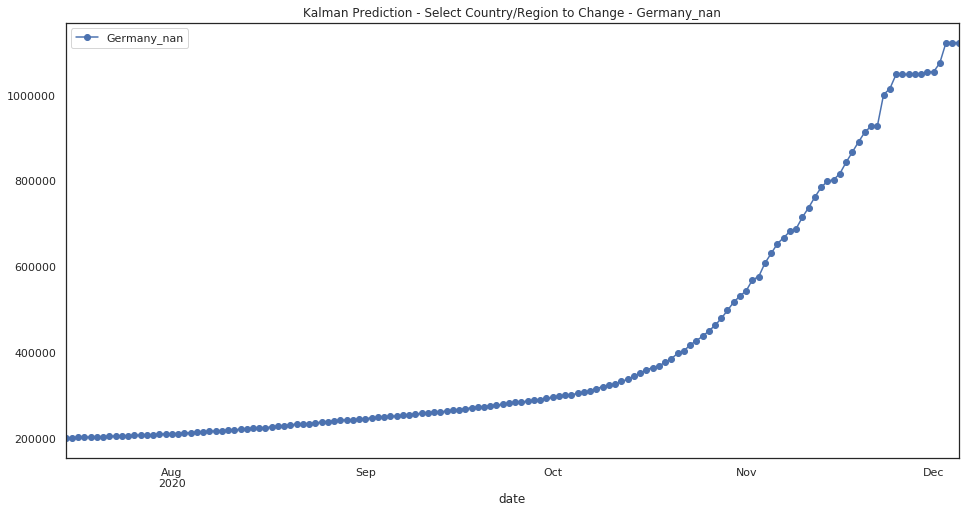

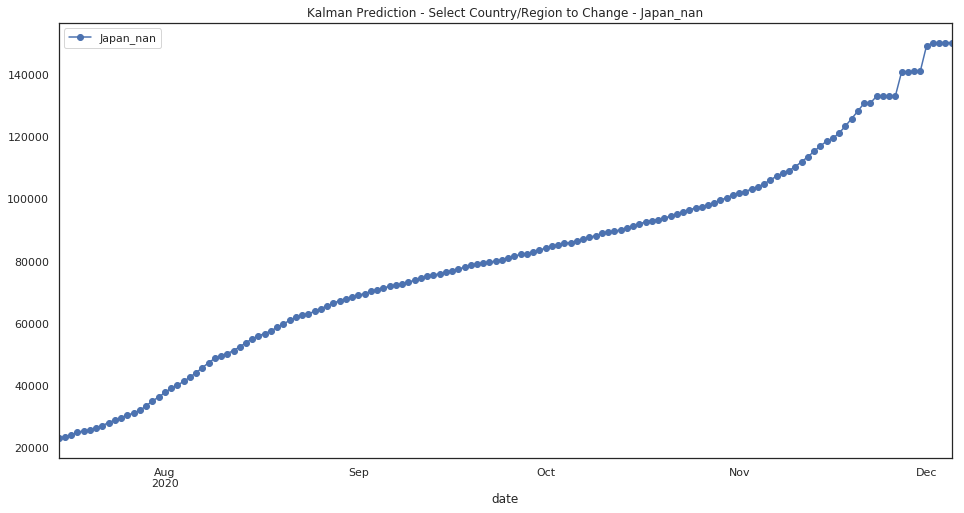

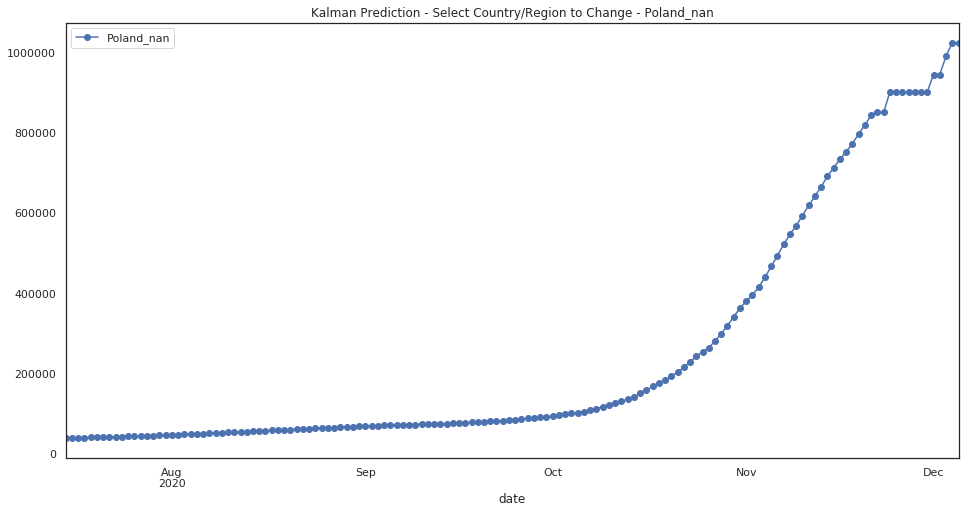

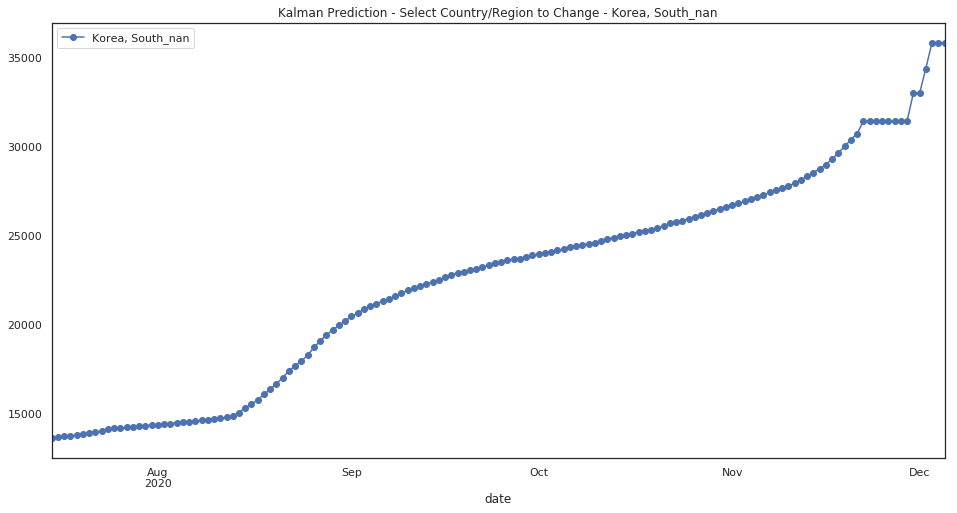

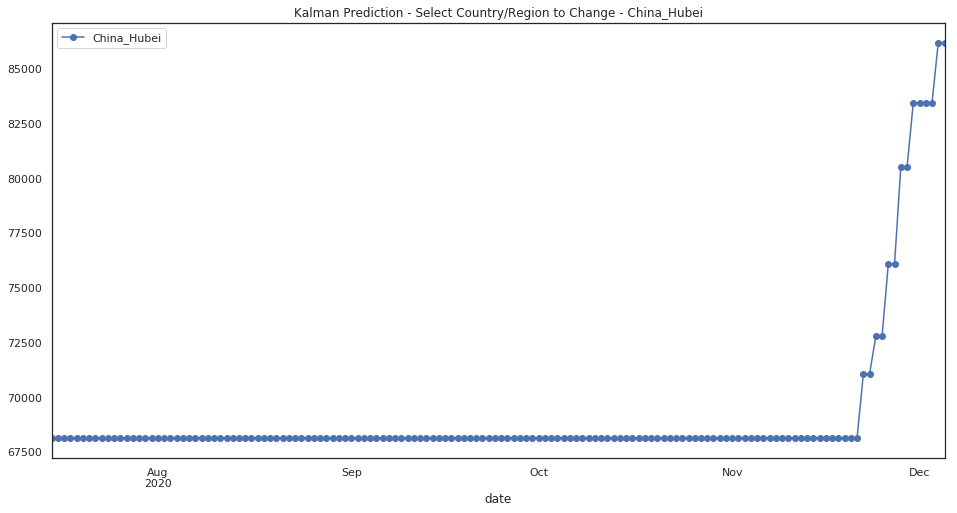

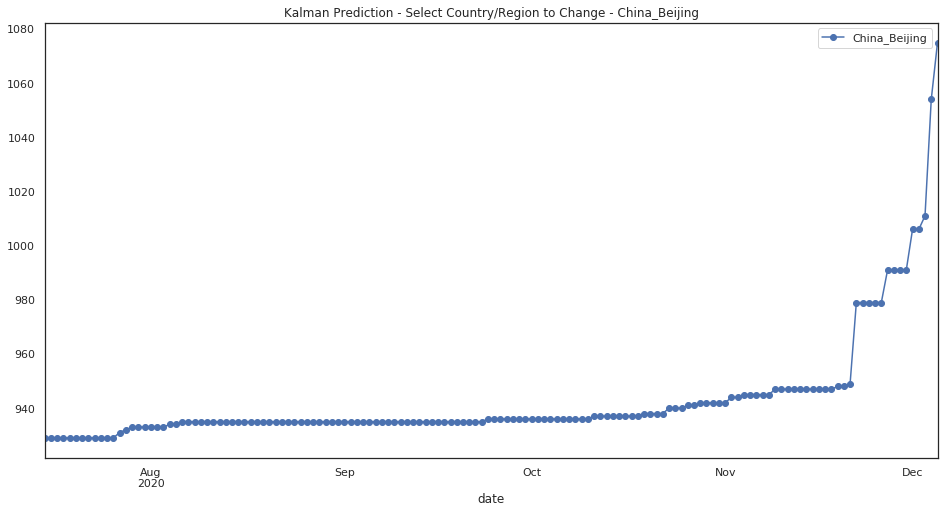

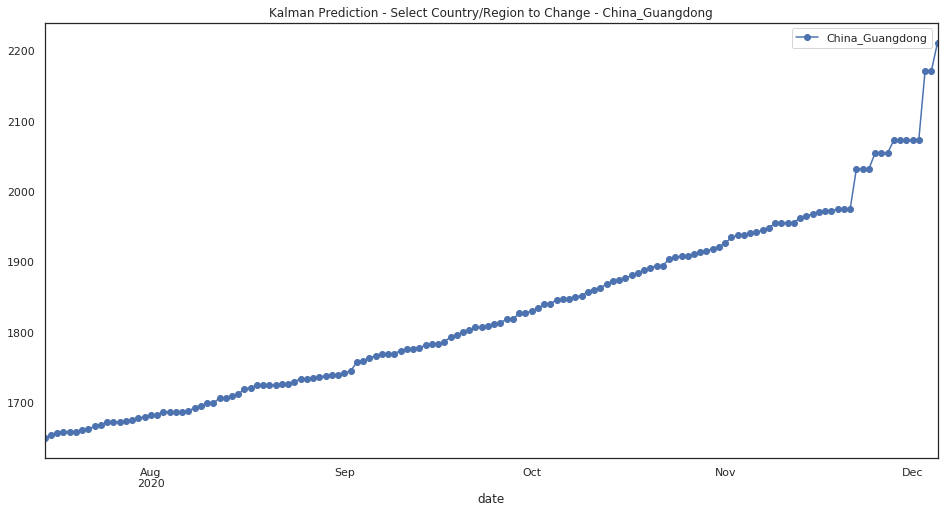

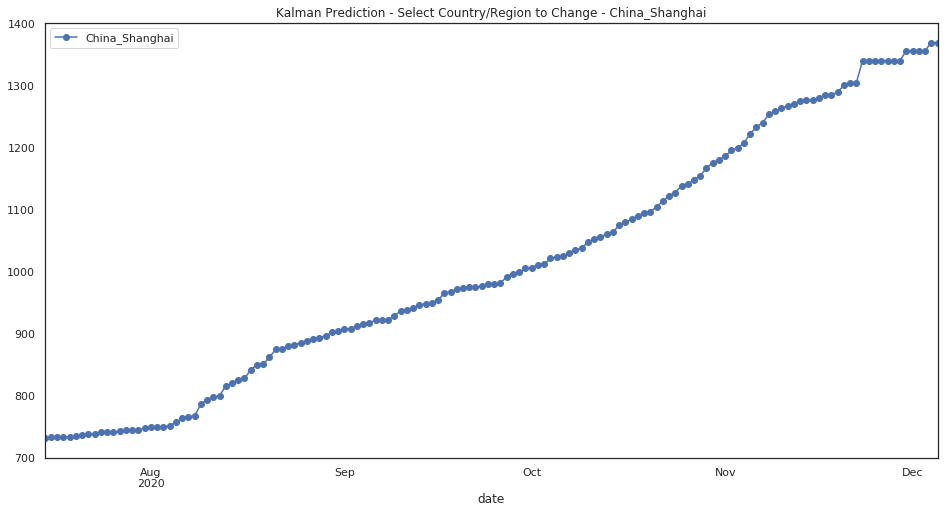

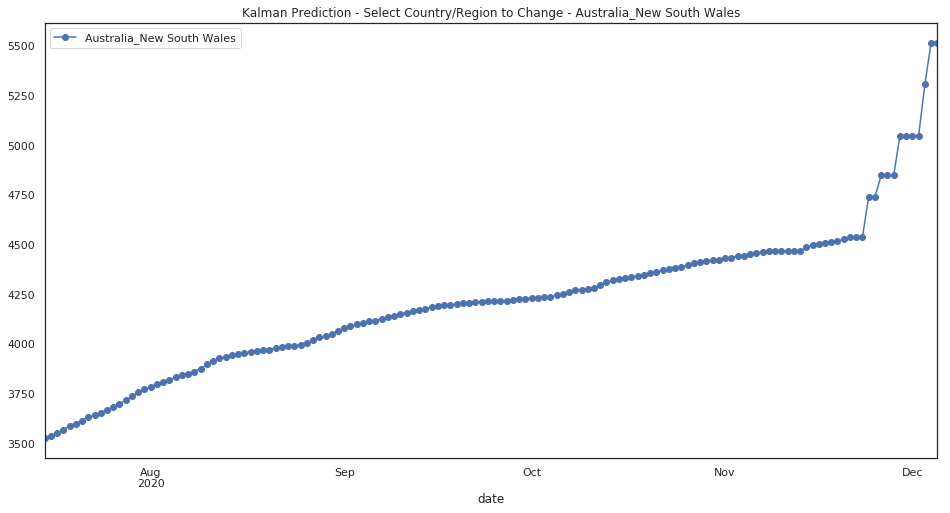

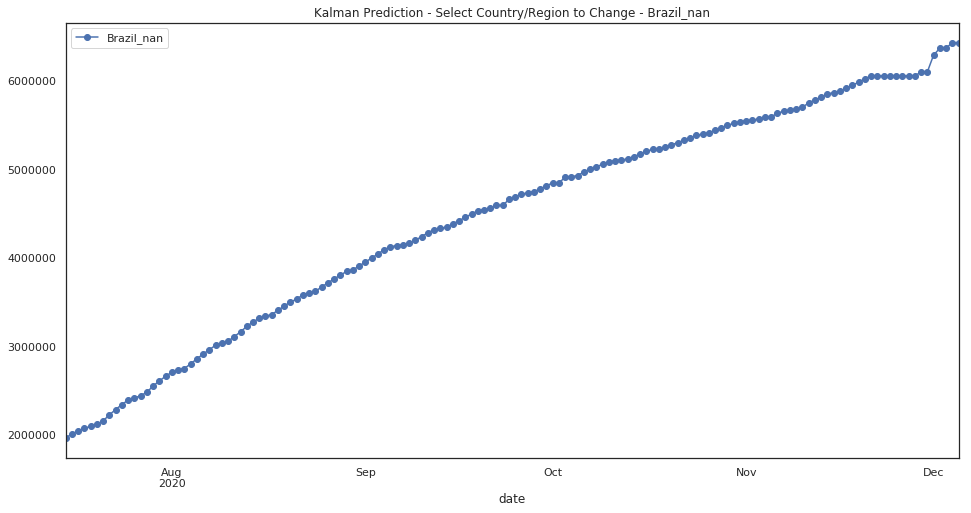

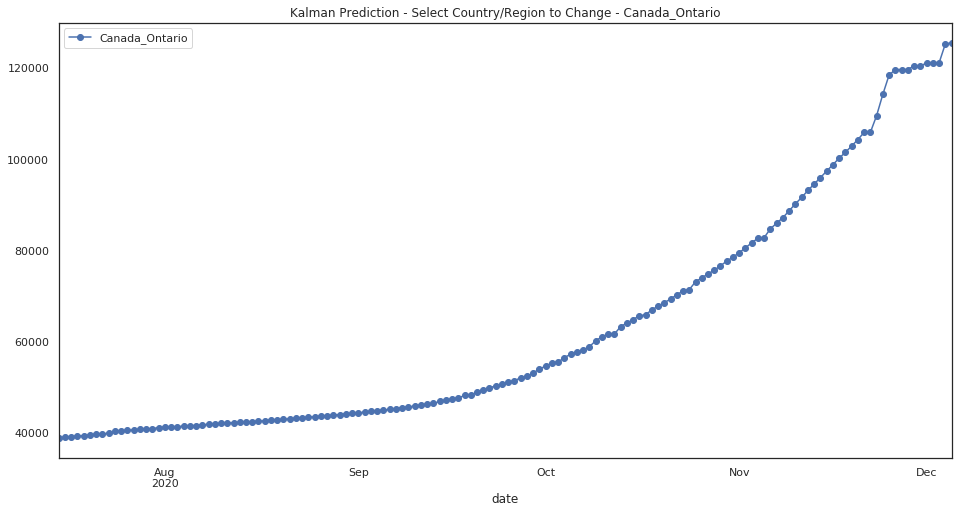

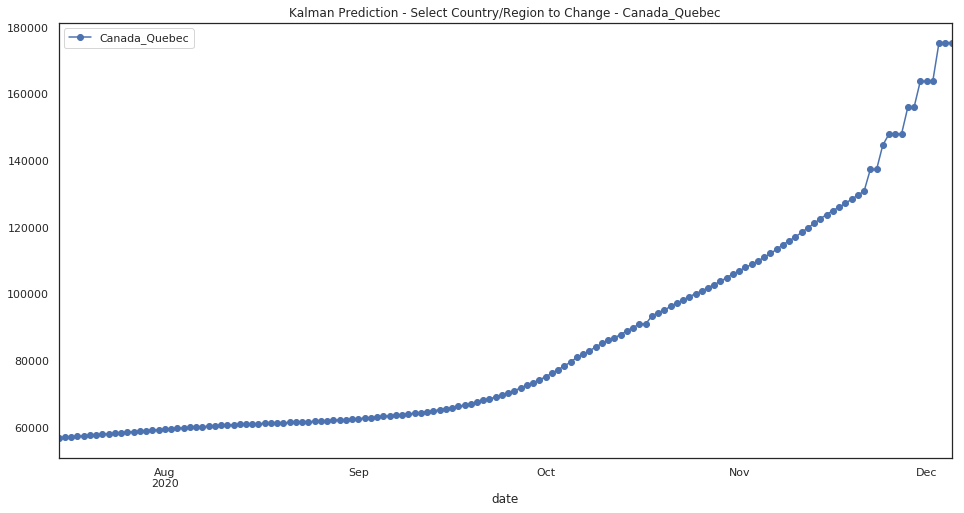

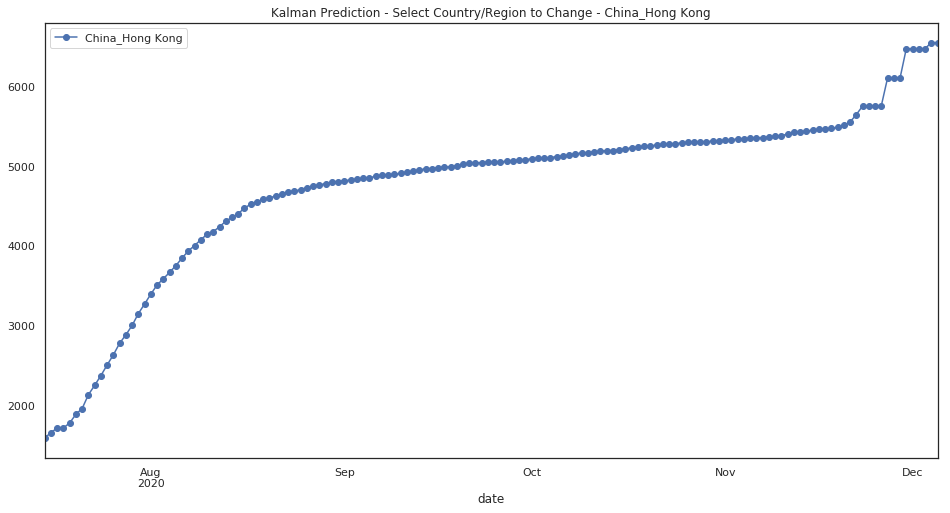

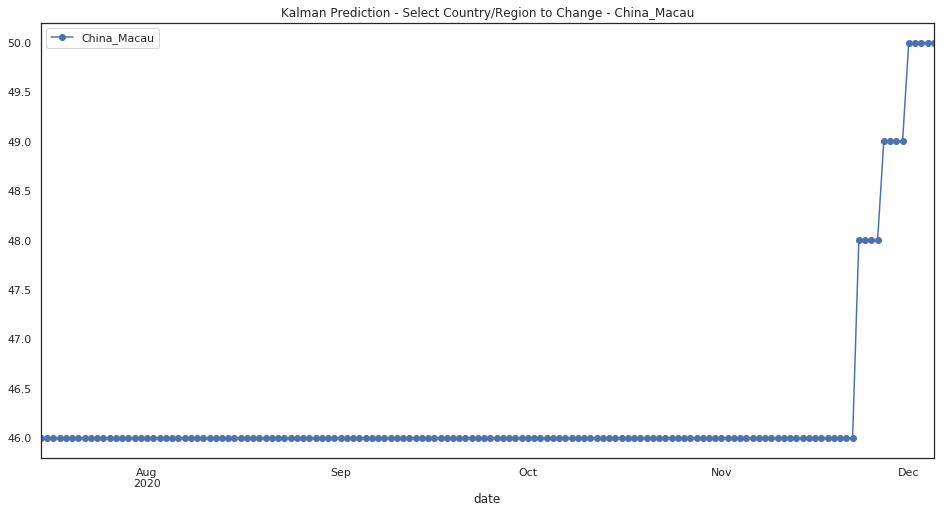

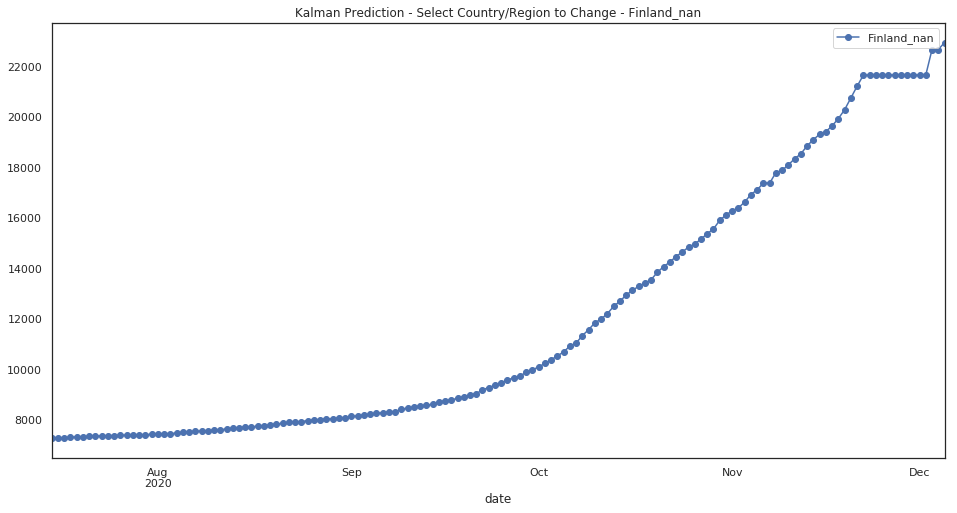

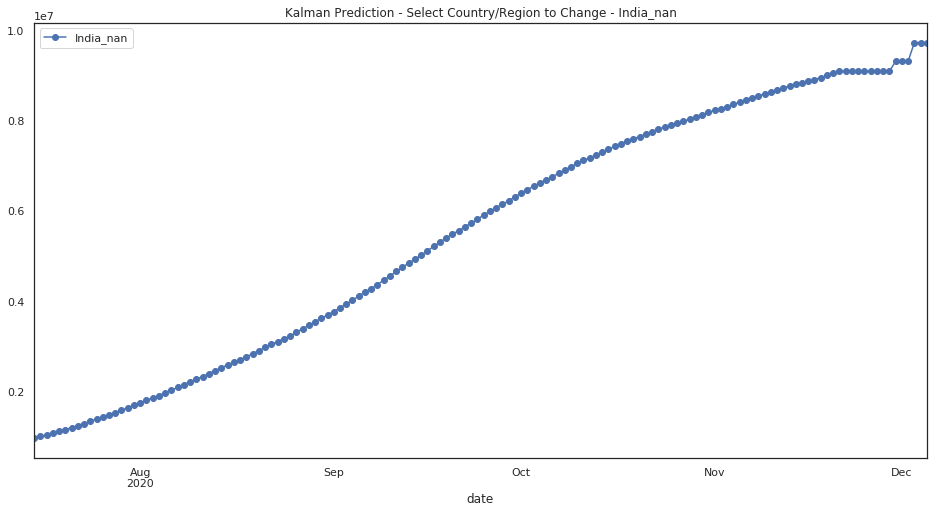

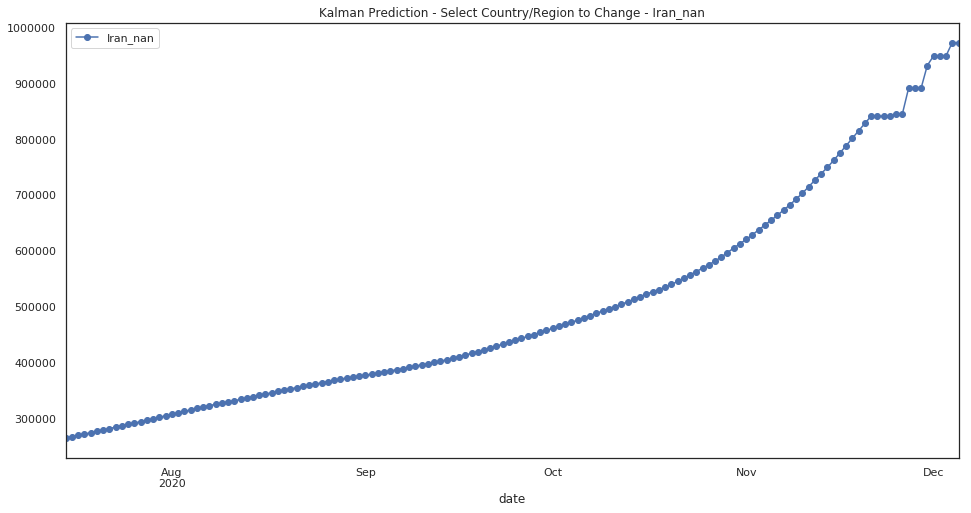

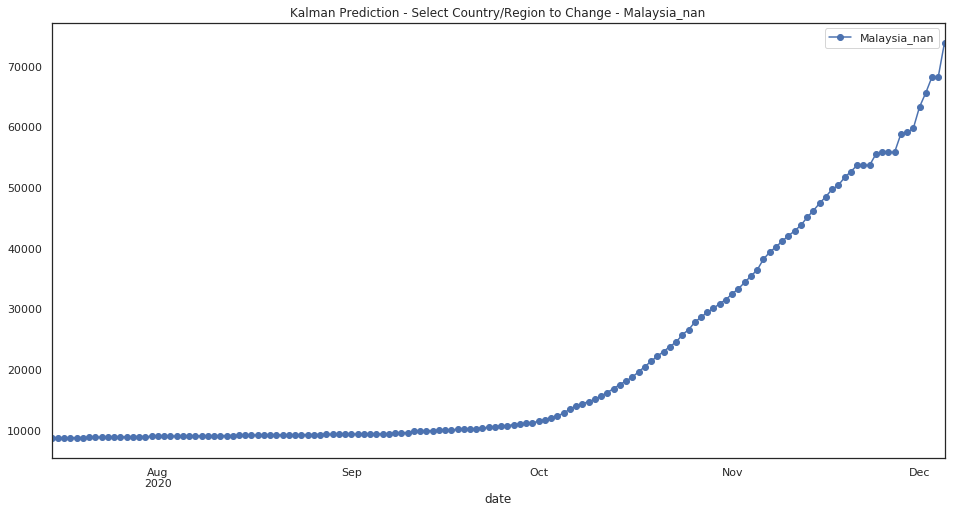

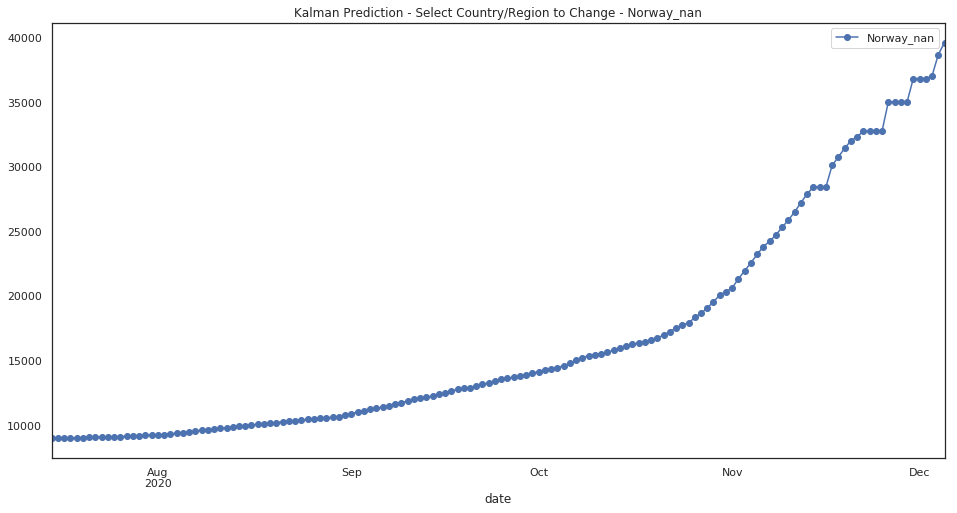

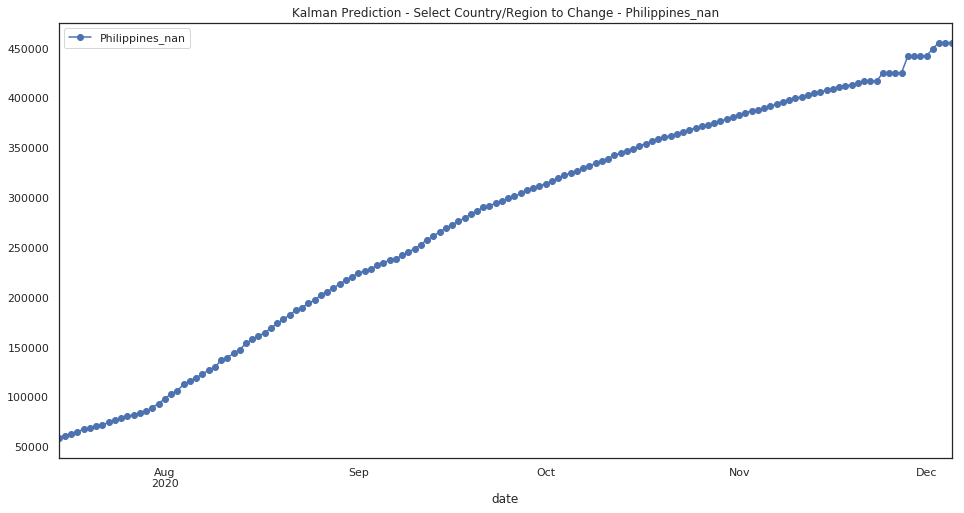

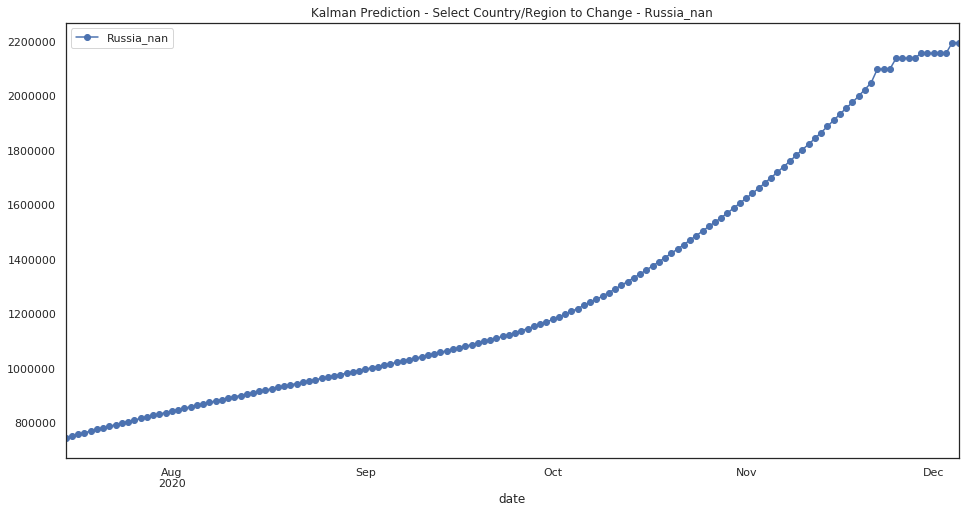

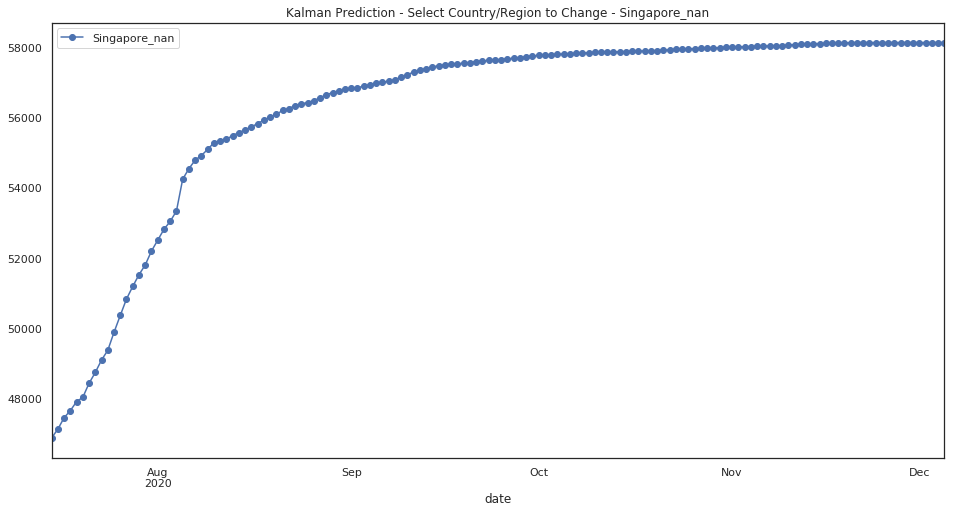

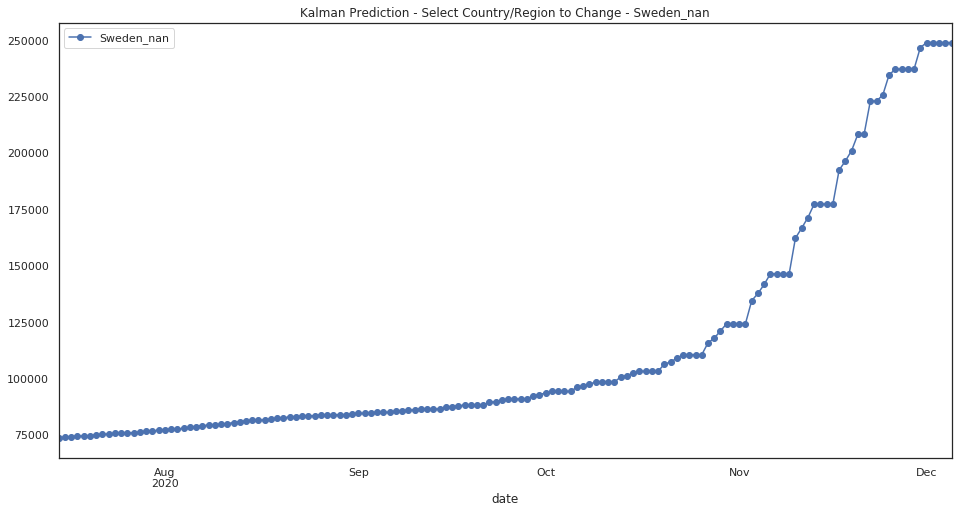

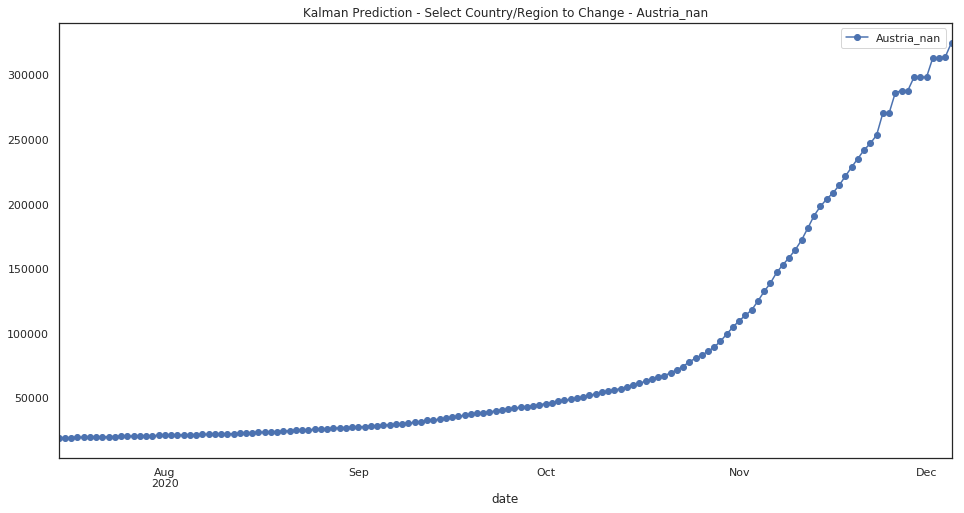

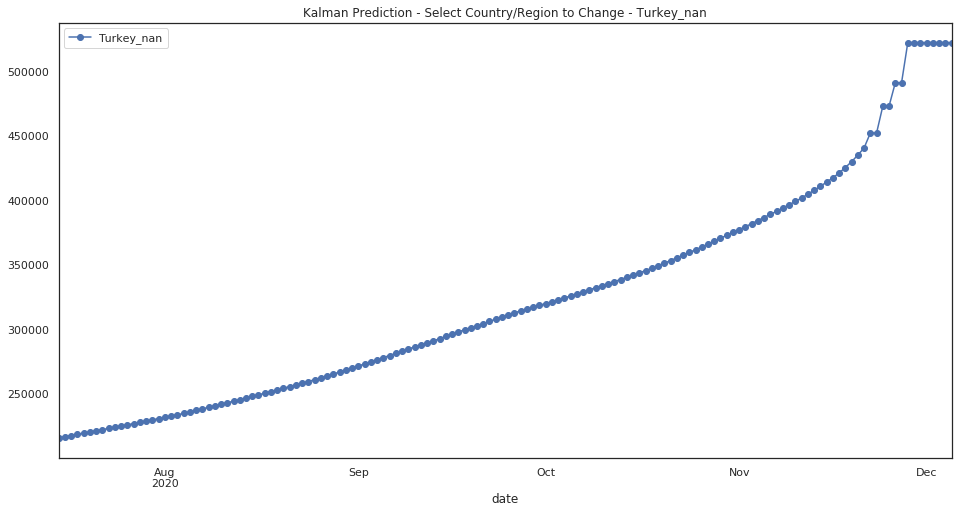

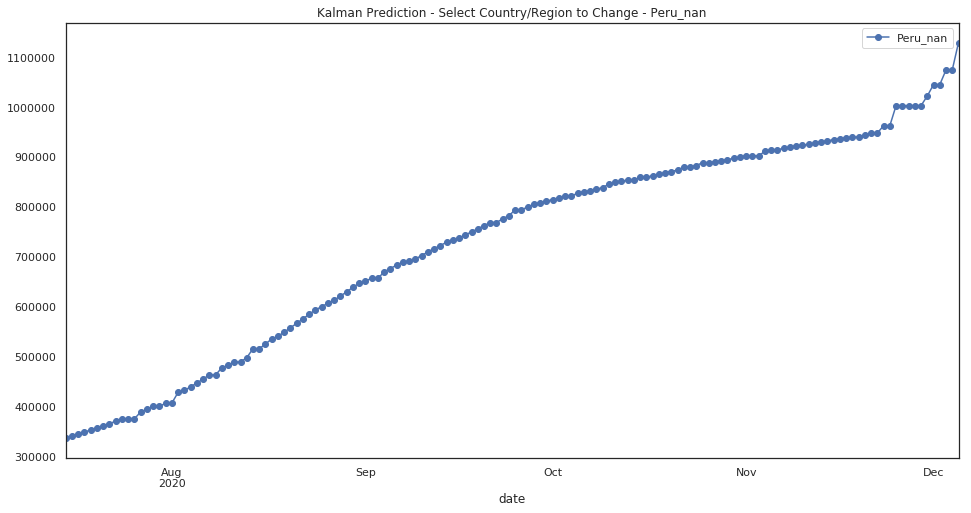

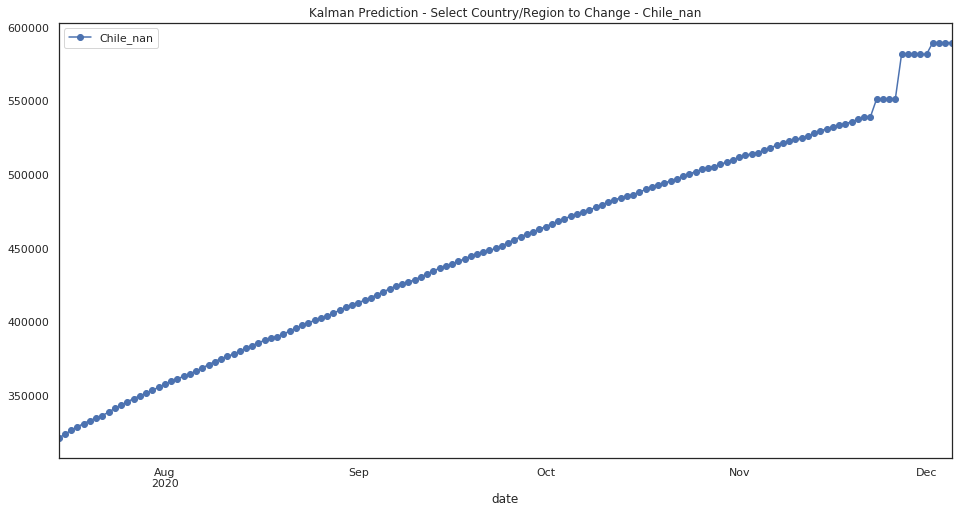

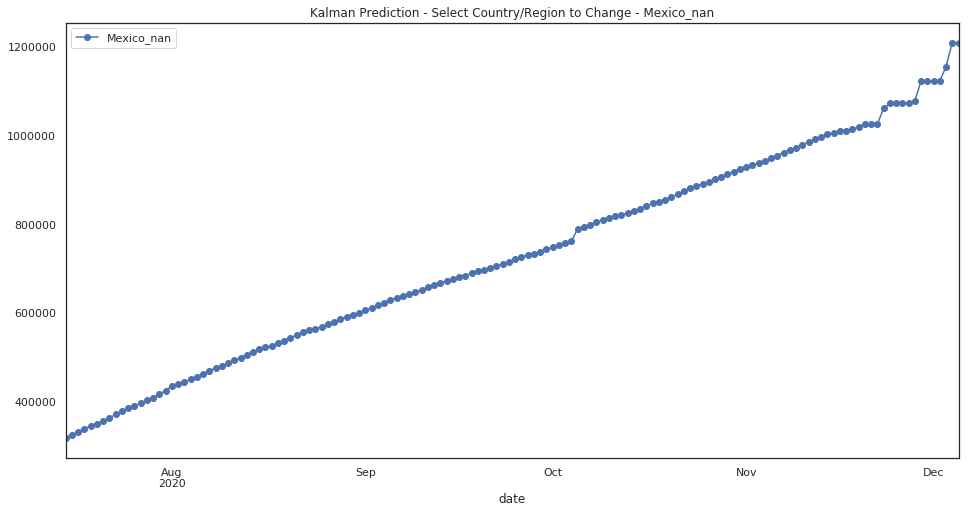

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-12-05 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      15569577.0
India_nan                                   NaN       9733892.0
Brazil_nan                                  NaN       6428409.0
France_nan                                  NaN       2948771.0
Russia_nan                                  NaN       2195300.0
Italy_nan                                   NaN       1916142.0
Spain_nan                                   NaN       1741582.0
United Kingdom_nan                          NaN       1711540.0
Argentina_nan                               NaN       1459152.0
Colombia_nan                                NaN       1288007.0
Mexico_nan                                  NaN       1210086.0
Peru_nan                                    NaN       1129198.0
Germany_nan                                 NaN       1122940.0
Poland_nan                                  NaN       1025142.0
Iran_nan                                    NaN        973275.0
South Africa_nan                            NaN        912180.0
Ukraine_nan                                 NaN        860174.0
Chile_nan                                   NaN        589727.0
Belgium_nan                                 NaN        589589.0
Romania_nan                                 NaN        572179.0
Iraq_nan                                    NaN        541090.0
Indonesia_nan                               NaN        532778.0
Turkey_nan                                  NaN        522488.0
Netherlands_nan                             NaN        518710.0
Czechia_nan                                 NaN        497581.0
Bangladesh_nan                              NaN        482412.0
Philippines_nan                             NaN        455712.0
Saudi Arabia_nan                            NaN        427463.0
Switzerland_nan                             NaN        407446.0
Pakistan_nan                                NaN        390506.0
...                                         ...             ...
Saint Vincent and the Grenadines_nan        NaN           119.0
China_Ningxia                               NaN            84.0
Dominica_nan                                NaN            83.0
United Kingdom_British Virgin Islands       NaN            78.0
Canada_Prince Edward Island                 NaN            72.0
China_Macau                                 NaN            50.0
Grenada_nan                                 NaN            50.0
Australia_Northern Territory                NaN            47.0
Canada_Yukon                                NaN            44.0
France_New Caledonia                        NaN            40.0
Timor-Leste_nan                             NaN            36.0
Fiji_nan                                    NaN            35.0
Holy See_nan                                NaN            33.0
Laos_nan                                    NaN            28.0
China_Qinghai                               NaN            21.0
Denmark_Greenland                           NaN            20.0
Saint Kitts and Nevis_nan                   NaN            20.0
France_Saint Pierre and Miquelon            NaN            19.0
Solomon Islands_nan                         NaN            19.0
Canada_Grand Princess                       NaN            19.0
United Kingdom_Falkland Islands (Malvinas)  NaN            17.0
Canada_Northwest Territories                NaN            16.0
United Kingdom_Montserrat                   NaN            13.0
Western Sahara_nan                          NaN            10.0
MS Zaandam_nan                              NaN             9.0
Marshall Islands_nan                        NaN             8.0
United Kingdom_Anguilla                     NaN             3.0
China_Tibet                                 NaN             1.0
Vanuatu_nan                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[269 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          43251.0      16050.0      30867.0      13534.0   
2020-07-16          43317.0      16136.0      31376.0      13547.0   
2020-07-17          35070.0       3851.0      21355.0        877.0   
2020-07-18          35229.0       3906.0      21948.0        880.0   
2020-07-19          35301.0       4008.0      22549.0        880.0   
2020-07-20          35475.0       4090.0      23118.0        880.0   
2020-07-21          35526.0       4171.0      23693.0        884.0   
2020-07-22          35615.0       4290.0      24299.0        884.0   
2020-07-23          36012.0       4484.0      25474.0        897.0   
2020-07-24          36078.0       4480.0      26141.0        969.0   
2020-07-25          36143.0       4574.0      26747.0        897.0   
2020-07-26          36256.0       4791.0      27363.0        974.0   
2020-07-27          36358.0       4763.0      27983.0        982.0   
2020-07-28          36465.0       4914.0      28620.0        907.0   
2020-07-29          36568.0       5032.0      29238.0        996.0   
2020-07-30          36643.0       5156.0      29851.0        918.0   
2020-07-31          36769.0       5274.0      30424.0        953.0   
2020-08-01          36813.0       5415.0      30987.0        966.0   
2020-08-02          36825.0       5451.0      31509.0       1004.0   
2020-08-03          36858.0       5555.0      32024.0       1013.0   
2020-08-04          36890.0       5733.0      32553.0        937.0   
2020-08-05          36934.0       5813.0      33097.0        994.0   
2020-08-06          36997.0       5931.0      33664.0       1021.0   
2020-08-07          37107.0       6100.0      34197.0        957.0   
2020-08-08          37152.0       6219.0      34740.0        955.0   
2020-08-09          37163.0       6378.0      35216.0       1037.0   
2020-08-10          37260.0       6486.0      35765.0       1041.0   
2020-08-11          37361.0       6650.0      36259.0        963.0   
2020-08-12          37442.0       6768.0      36760.0       1049.0   
2020-08-13          37523.0       6922.0      37248.0        977.0   
...                     ...          ...          ...          ...   
2020-11-07          42135.0      23636.0      61457.0       5135.0   
2020-11-08          42193.0      24145.0      62116.0       5319.0   
2020-11-09          42380.0      24672.0      62772.0       5383.0   
2020-11-10          42547.0      25232.0      63512.0       5437.0   
2020-11-11          42697.0      25744.0      64327.0       5477.0   
2020-11-12          42878.0      26186.0      65180.0       5567.0   
2020-11-13          43054.0      26690.0      66049.0       5616.0   
2020-11-14          43136.0      27198.0      66900.0       5725.0   
2020-11-15          43326.0      27780.0      67759.0       5725.0   
2020-11-16          43493.0      28372.0      68667.0       5872.0   
2020-11-17          43711.0      29058.0      69665.0       5914.0   
2020-11-18          43933.0      29755.0      70709.0       5951.0   
2020-11-19          44291.0      30536.0      71739.0       6018.0   
2020-11-20          44526.0      31365.0      72832.0       6066.0   
2020-11-21          44609.0      32119.0      73873.0       6142.0   
2020-11-22          45208.0      32237.0      73999.0       6207.0   
2020-11-23          46667.0      34248.0      77372.0       6470.0   
2020-11-24          46878.0      35049.0      78332.0       6515.0   
2020-11-25          46883.0      35352.0      77885.0       6515.0   
2020-11-26          49292.0      37082.0      81287.0       6699.0   
2020-11-27          49931.0      37198.0      82290.0       6699.0   
2020-11-28          49958.0      37322.0      84645.0       6793.0   
2020-11-29          53026.0      38195.0      87410.0       6793.0   
2020-11-30          54247.0      38273.0      91813.0       7041.0   
2020-12-01

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Russia_nan',
 'Italy_nan',
 'Spain_nan',
 'United Kingdom_nan',
 'Argentina_nan',
 'Colombia_nan',
 'Mexico_nan',
 'Peru_nan',
 'Germany_nan',
 'Poland_nan',
 'Iran_nan',
 'South Africa_nan',
 'Ukraine_nan',
 'Chile_nan',
 'Belgium_nan',
 'Romania_nan',
 'Iraq_nan',
 'Indonesia_nan',
 'Turkey_nan',
 'Netherlands_nan',
 'Czechia_nan',
 'Bangladesh_nan',
 'Philippines_nan',
 'Saudi Arabia_nan',
 'Switzerland_nan',
 'Pakistan_nan',
 'Morocco_nan',
 'Israel_nan',
 'Austria_nan',
 'Portugal_nan',
 'Nepal_nan',
 'Sweden_nan',
 'Ecuador_nan',
 'United Arab Emirates_nan',
 'Jordan_nan',
 'Hungary_nan',
 'Panama_nan',
 'Belarus_nan',
 'Canada_Quebec',
 'Serbia_nan',
 'Kuwait_nan',
 'Dominican Republic_nan',
 'Bulgaria_nan',
 'Japan_nan',
 'Costa Rica_nan',
 'Croatia_nan',
 'Bolivia_nan',
 'Oman_nan',
 'Ethiopia_nan',
 'Qatar_nan',
 'Armenia_nan',
 'Kazakhstan_nan',
 'Lebanon_nan',
 'Canada_Ontario',
 'Egypt_nan',
 'Greece_nan',

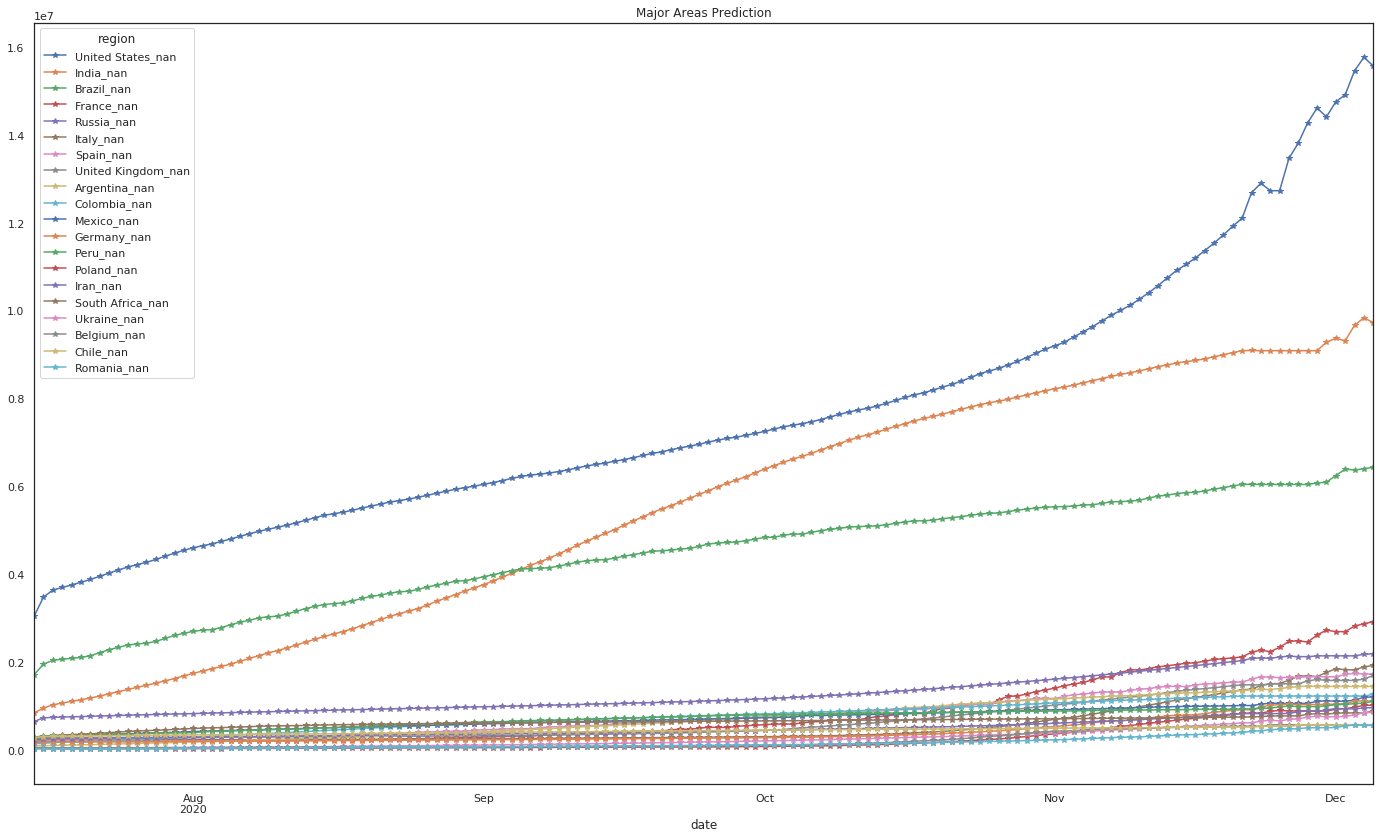

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

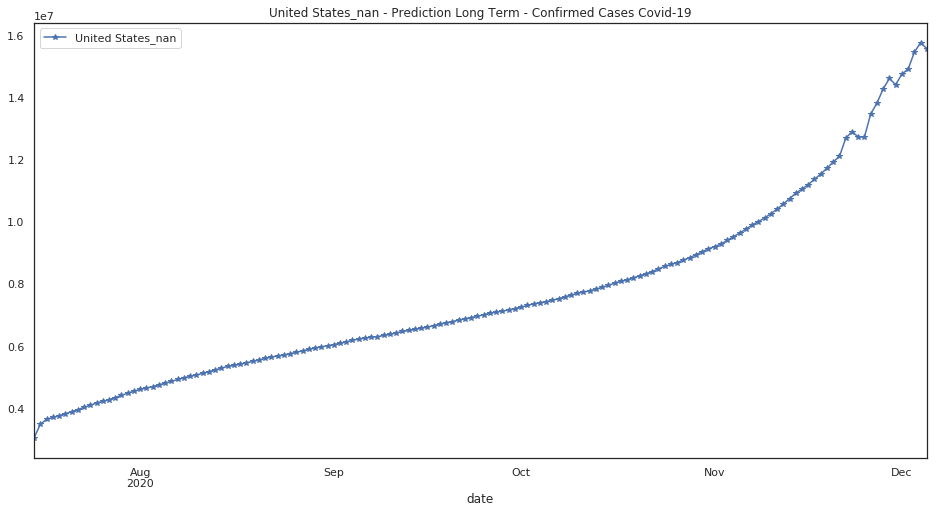

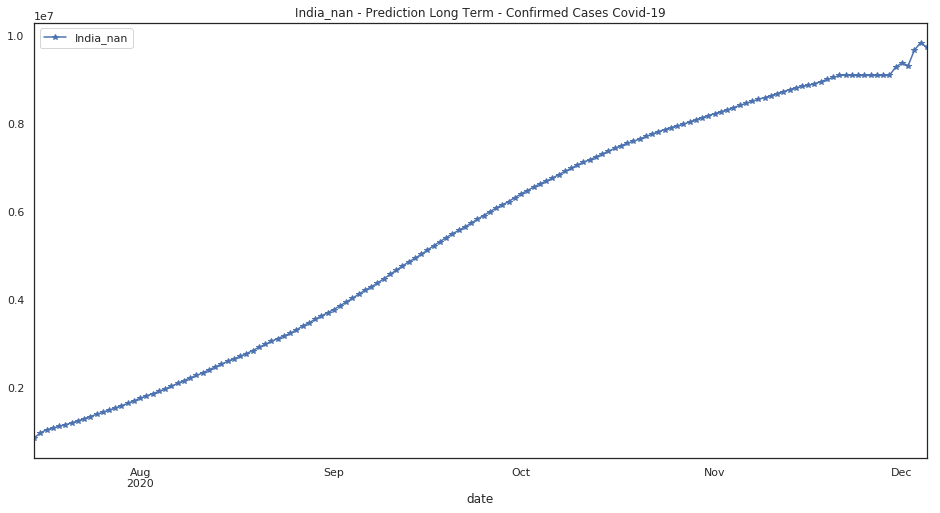

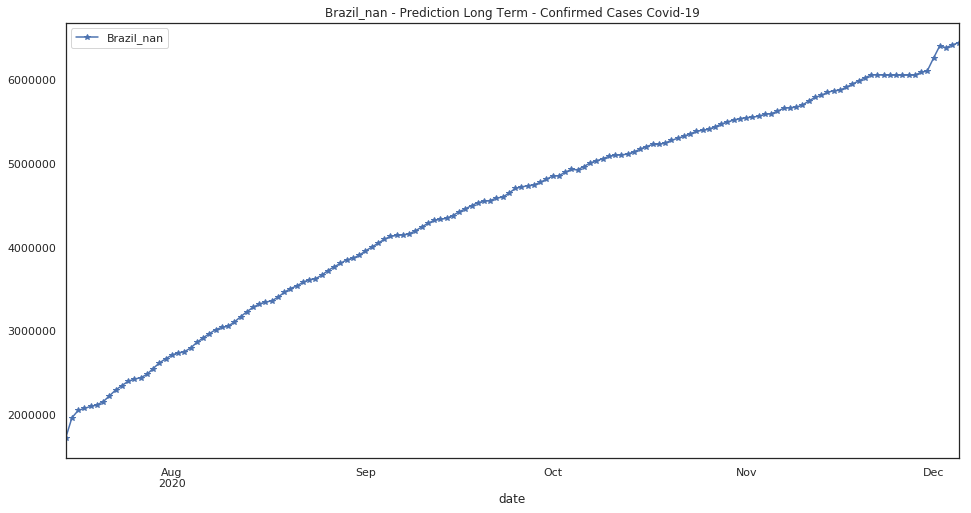

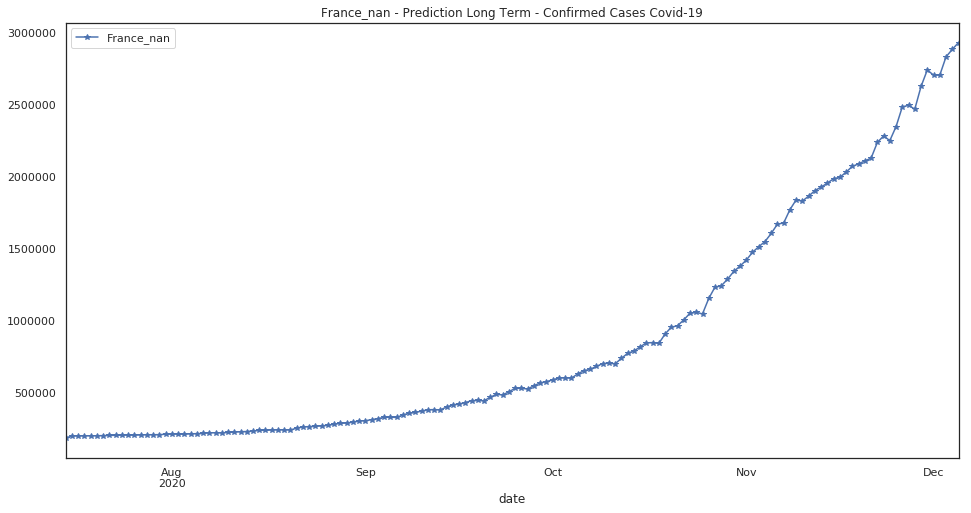

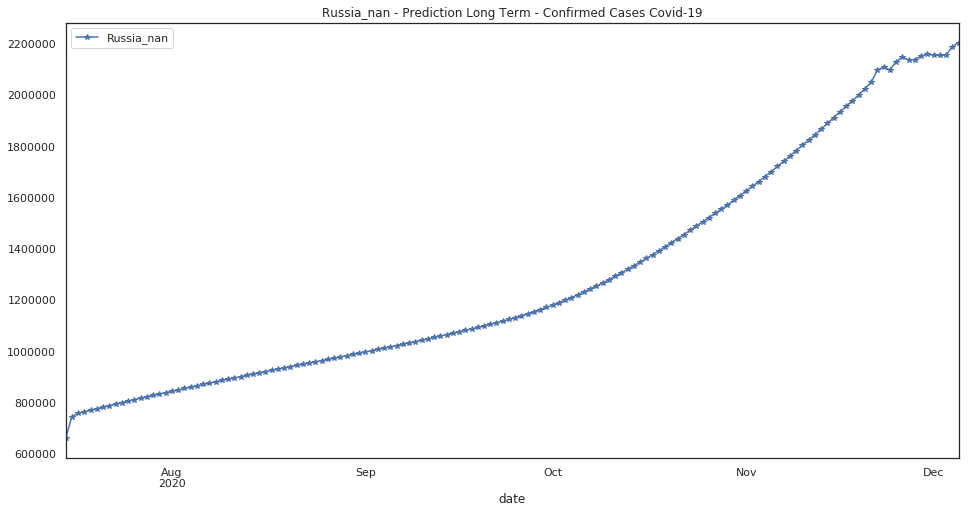

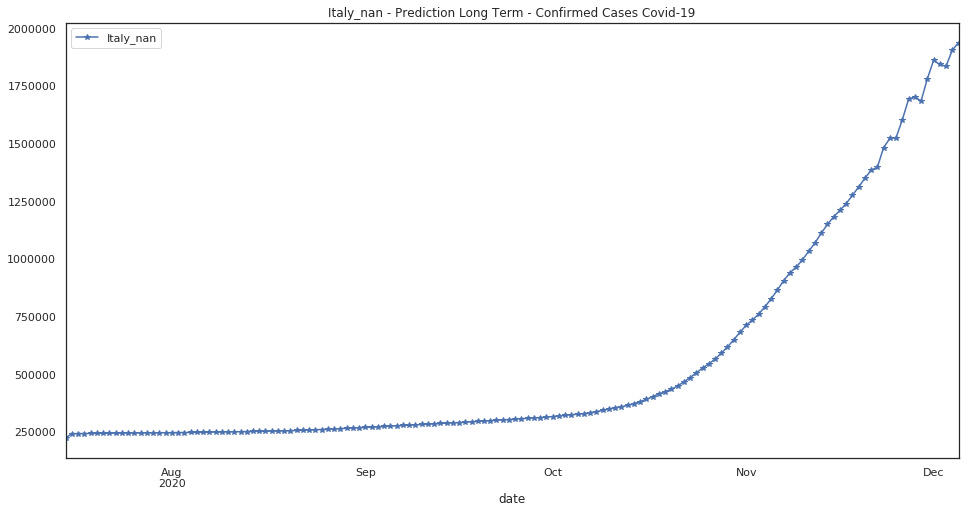

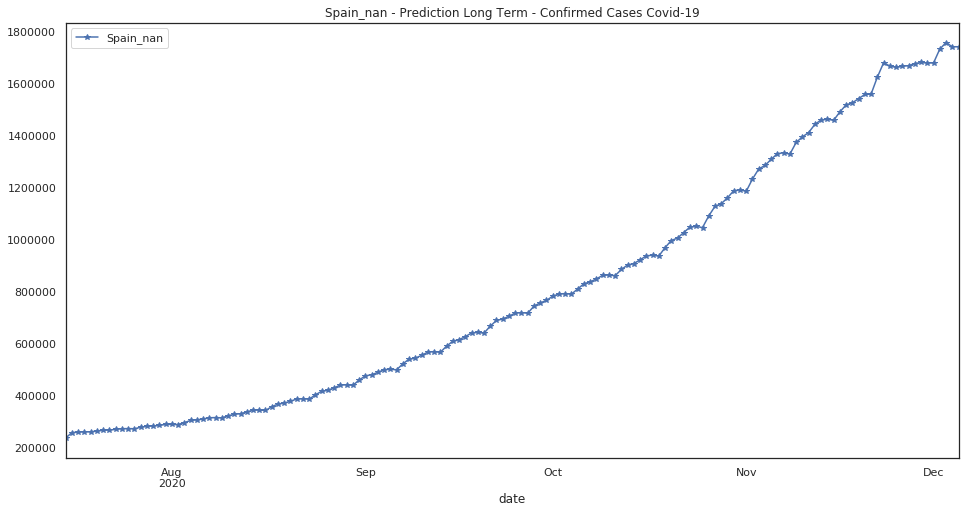

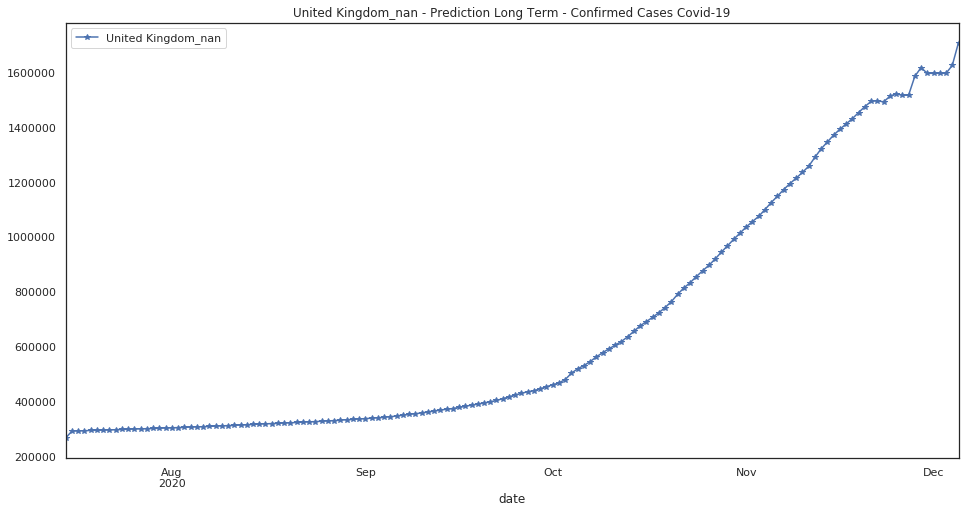

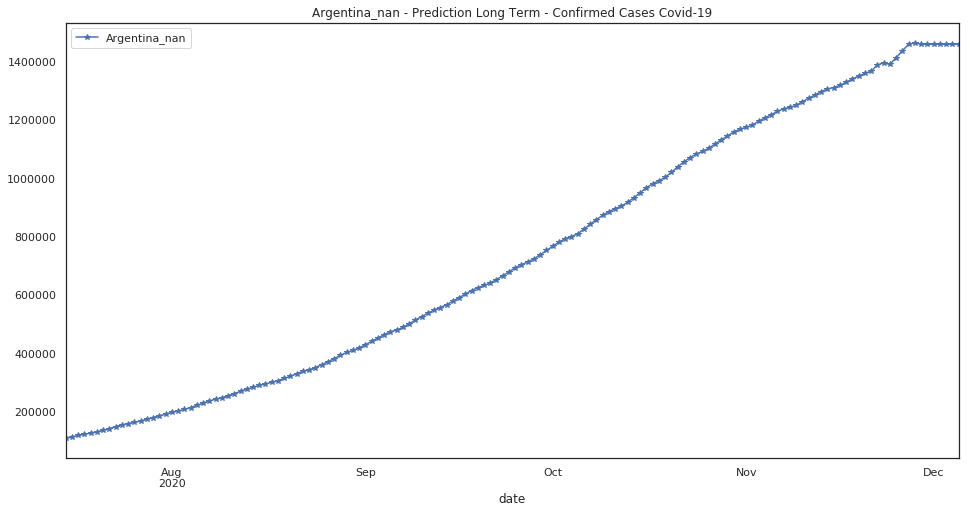

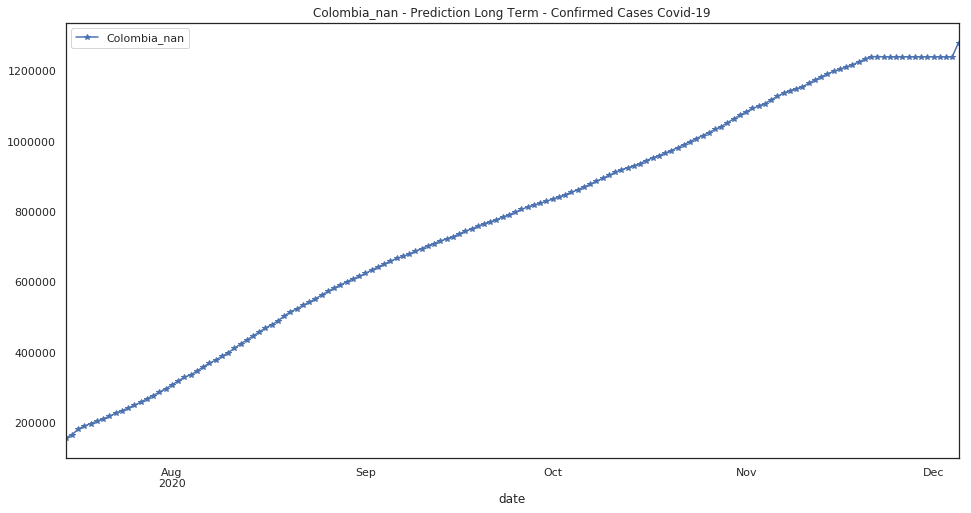

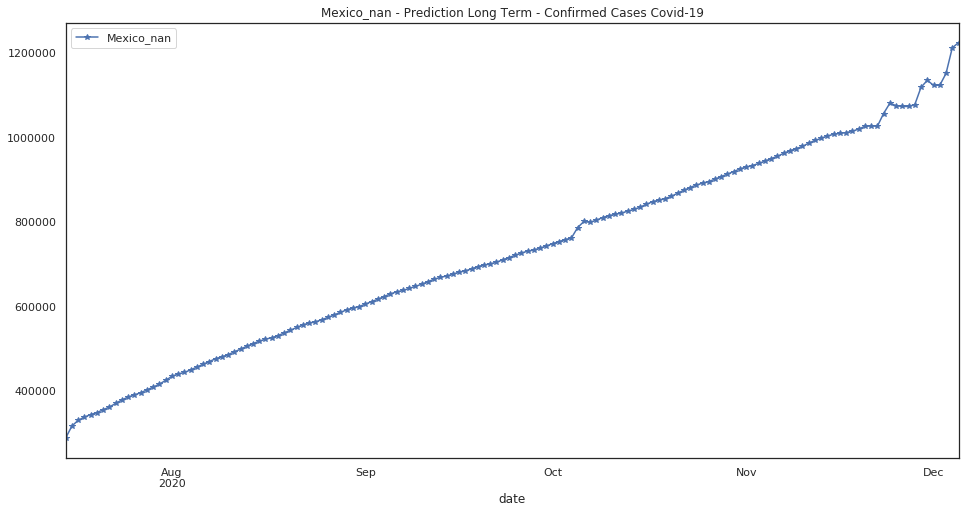

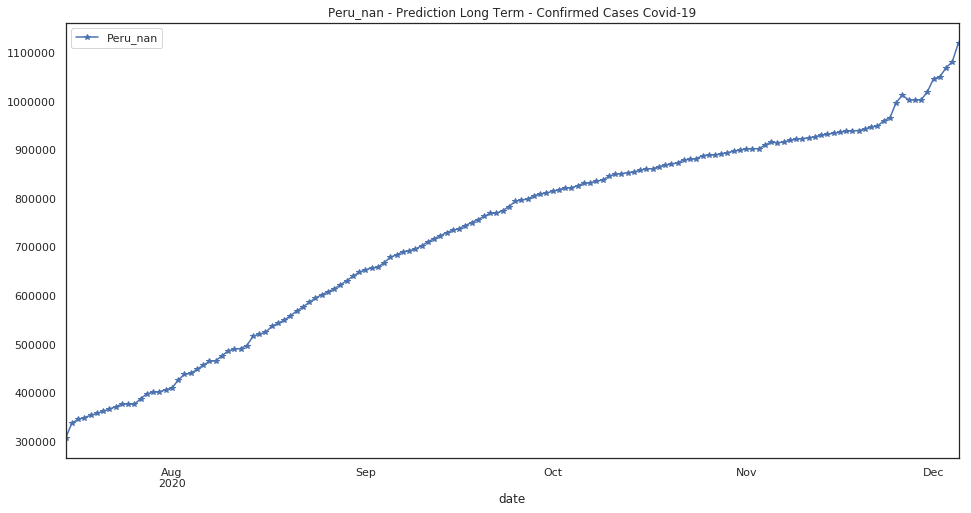

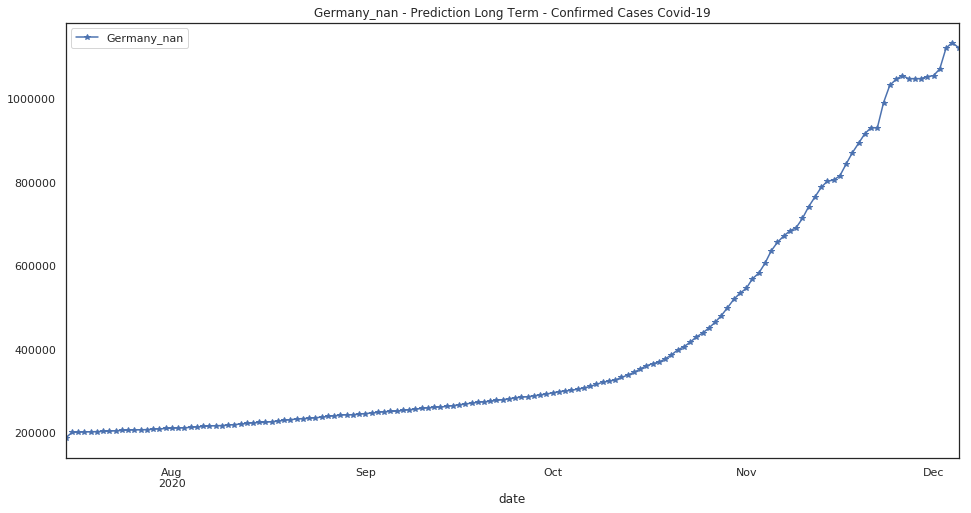

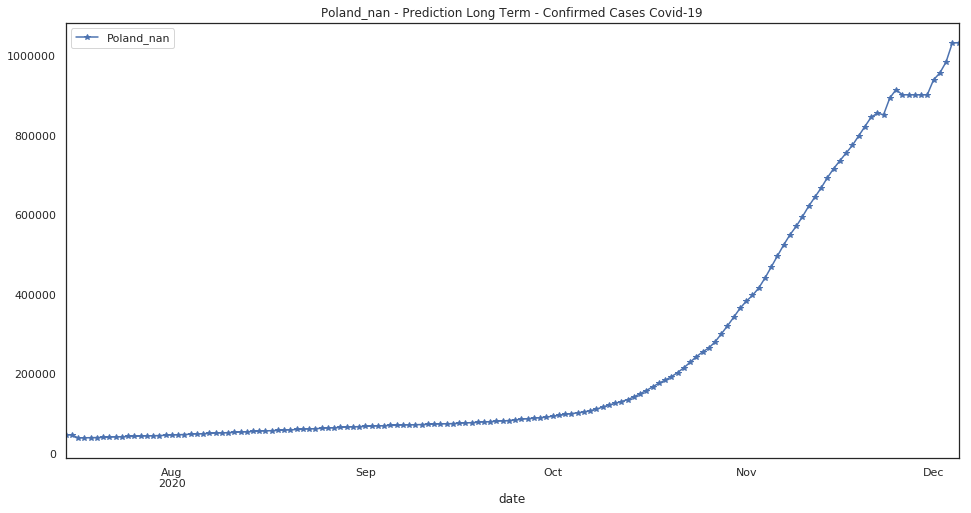

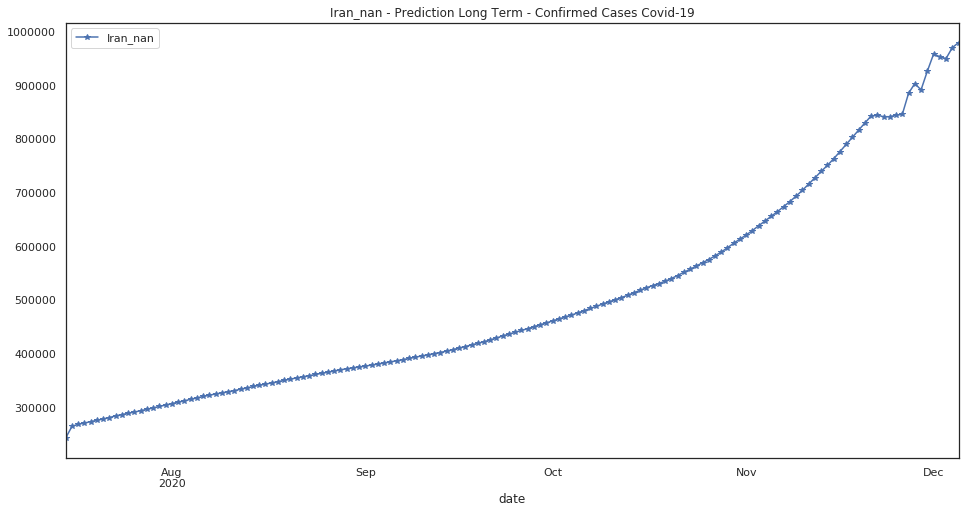

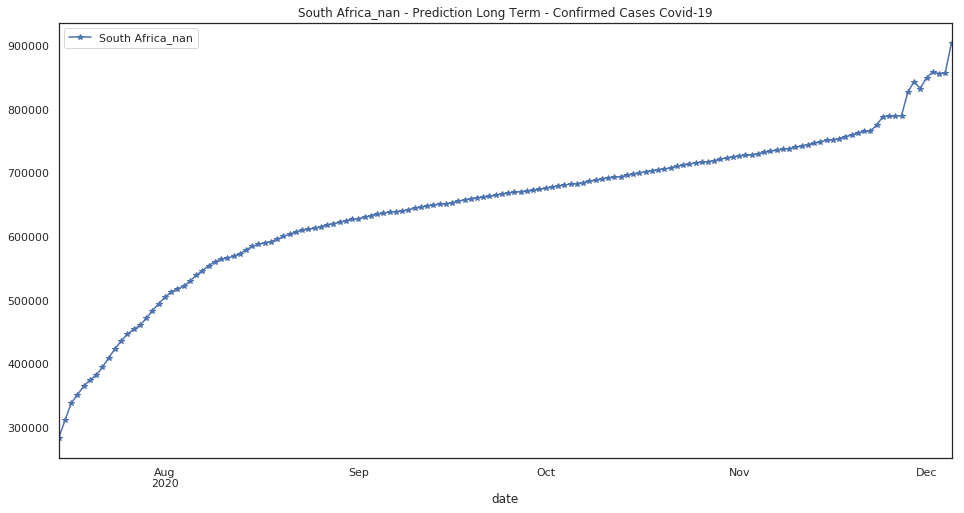

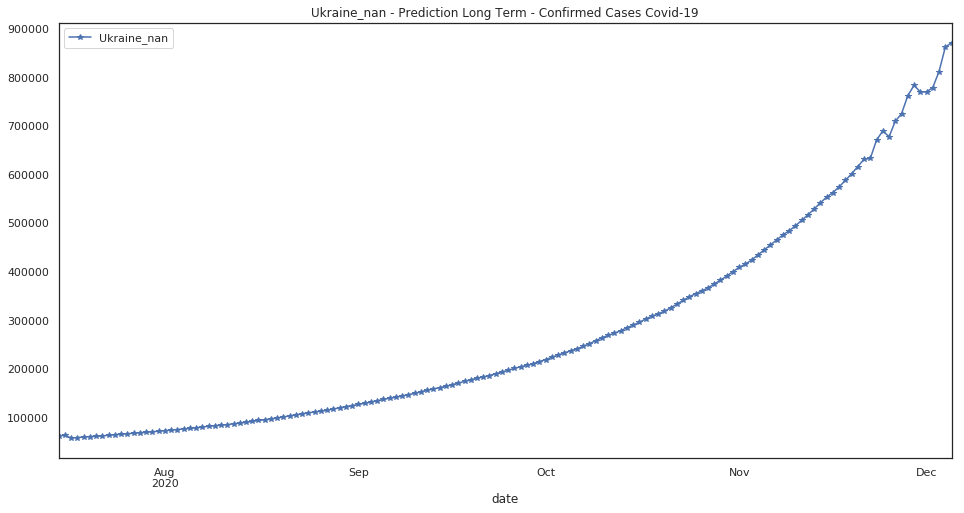

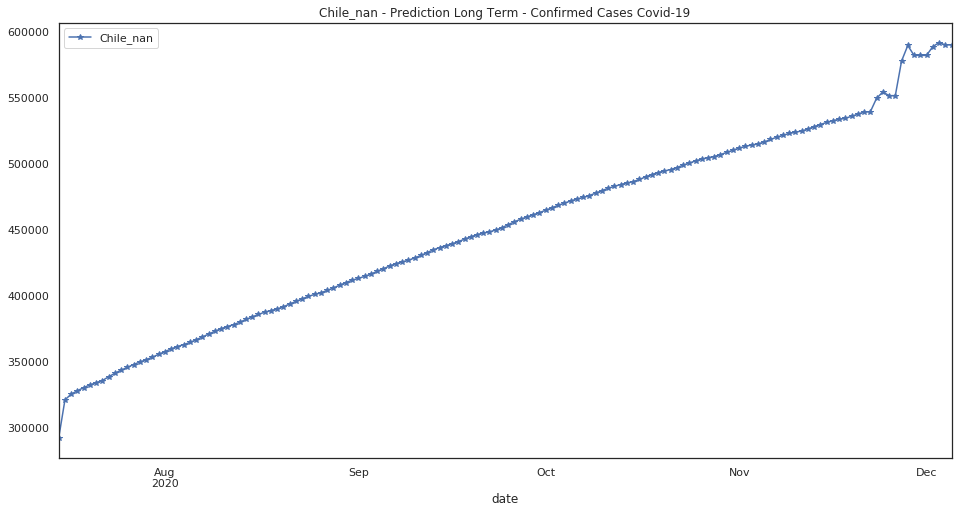

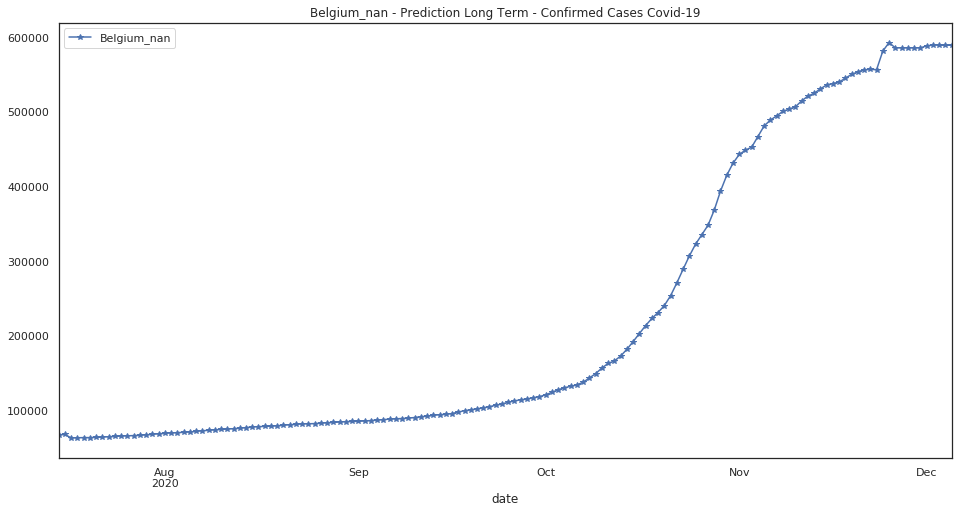

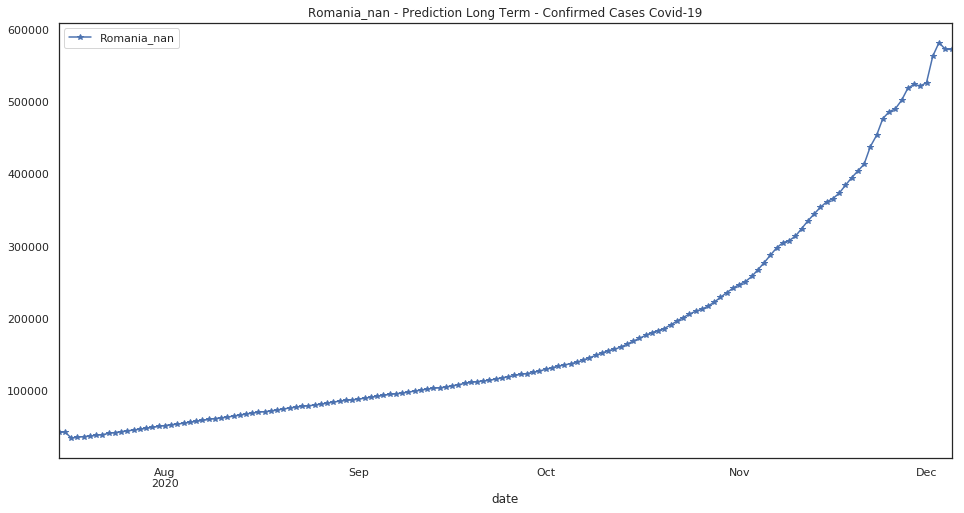

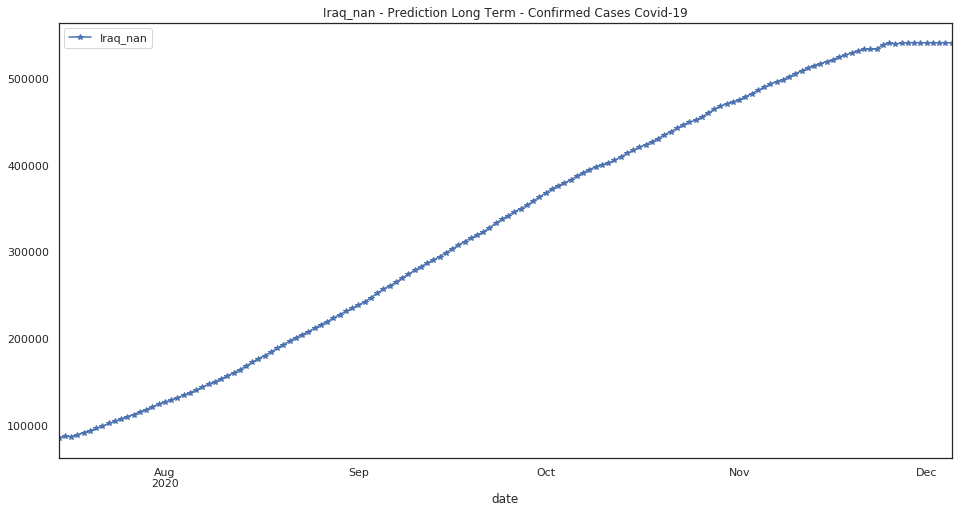

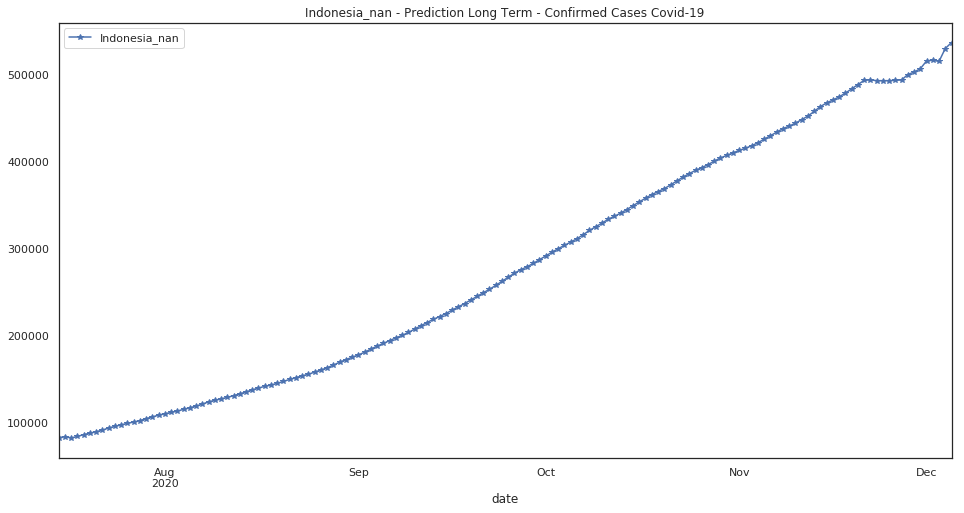

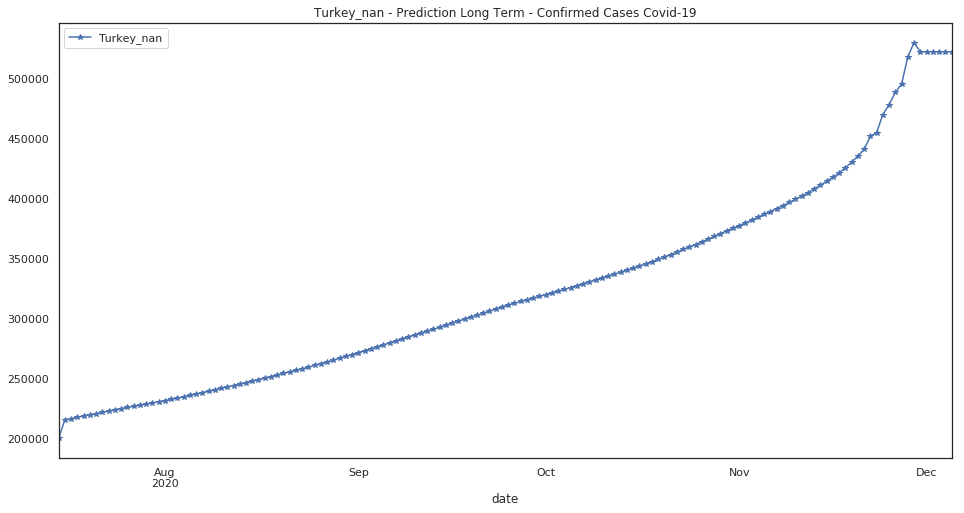

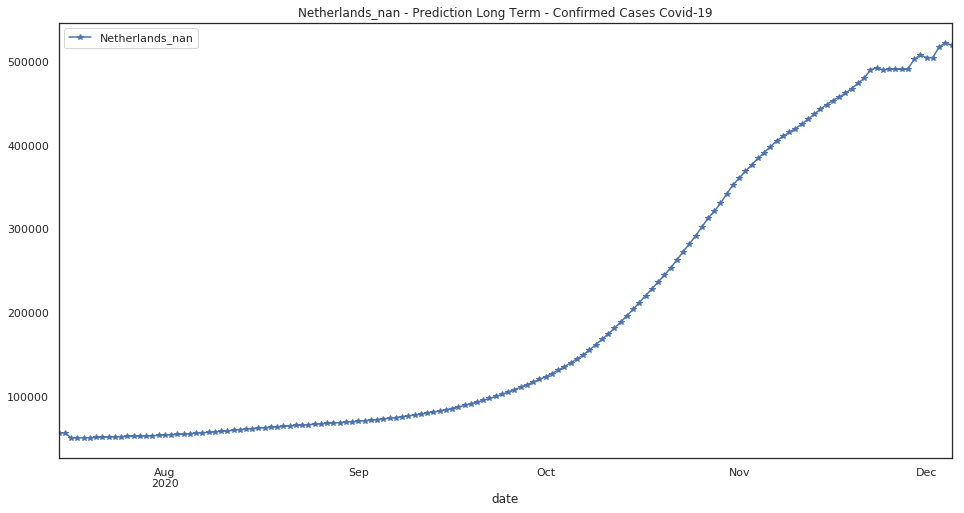

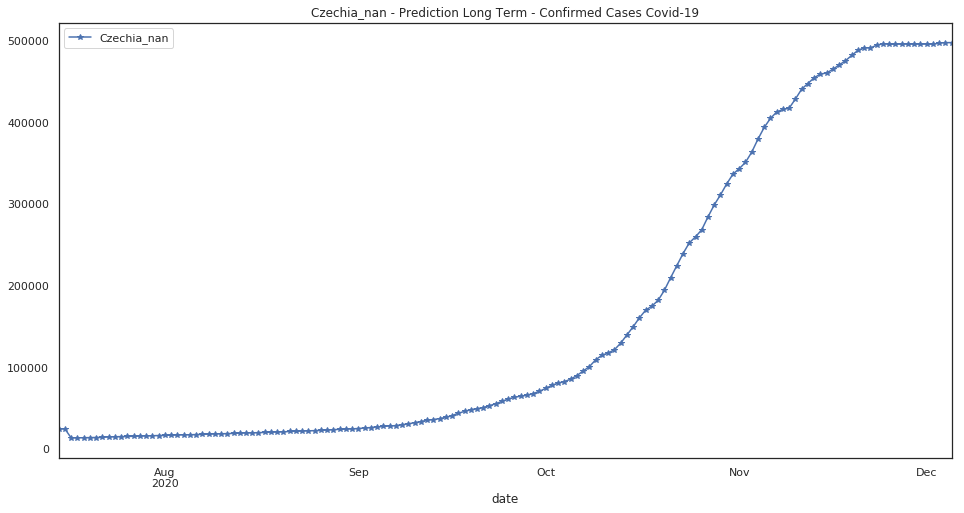

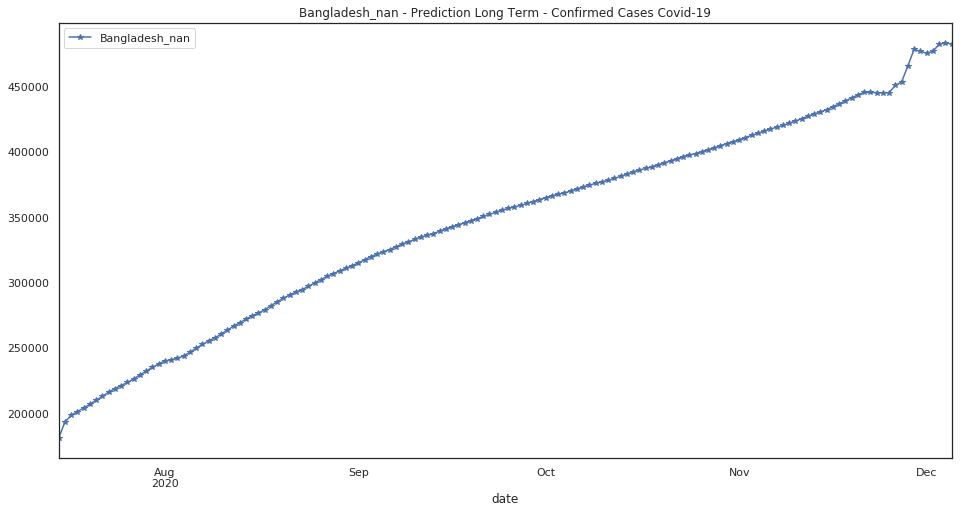

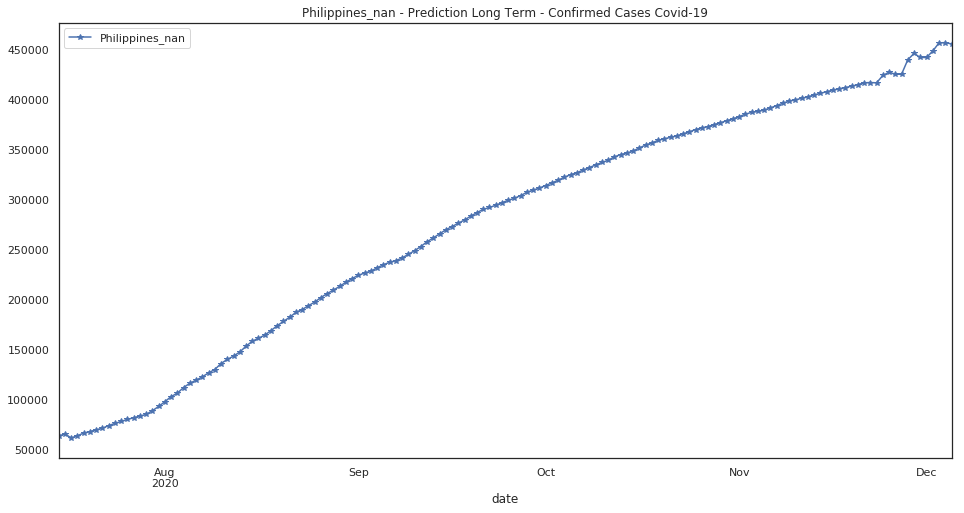

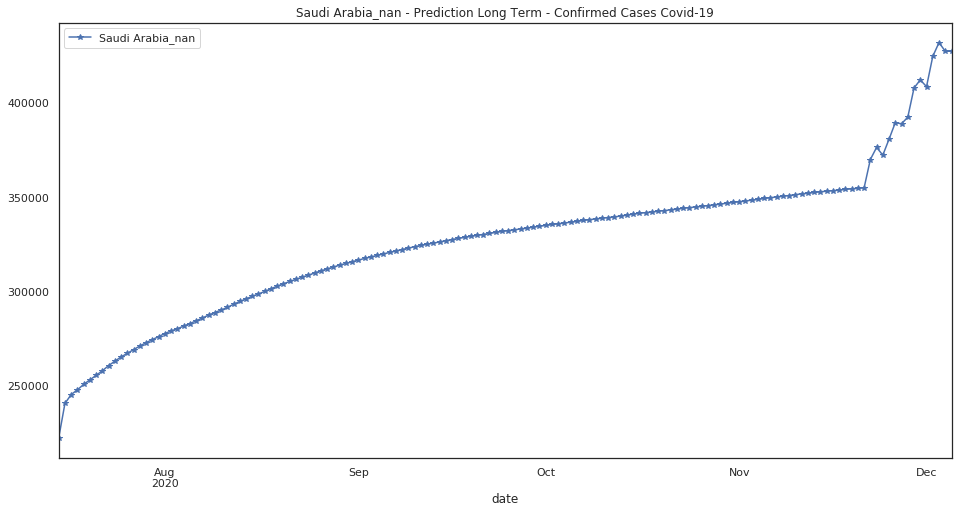

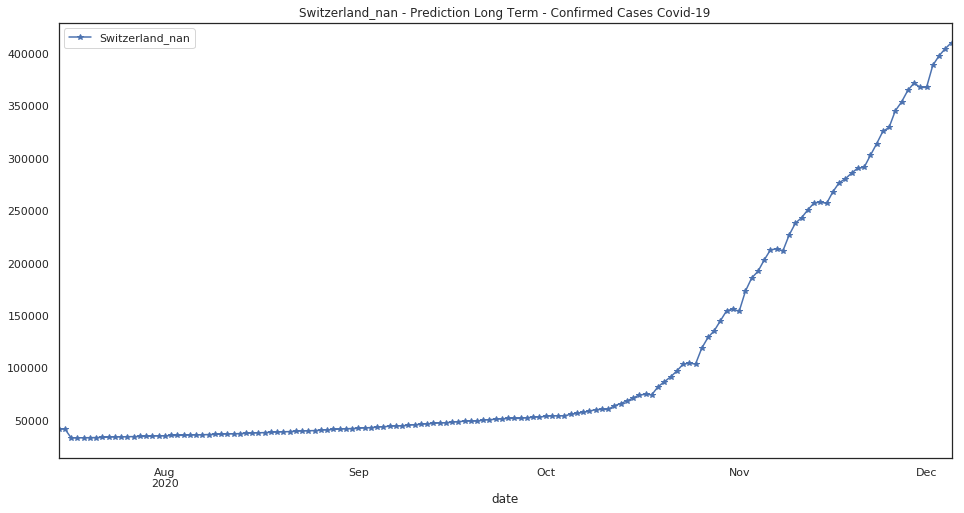

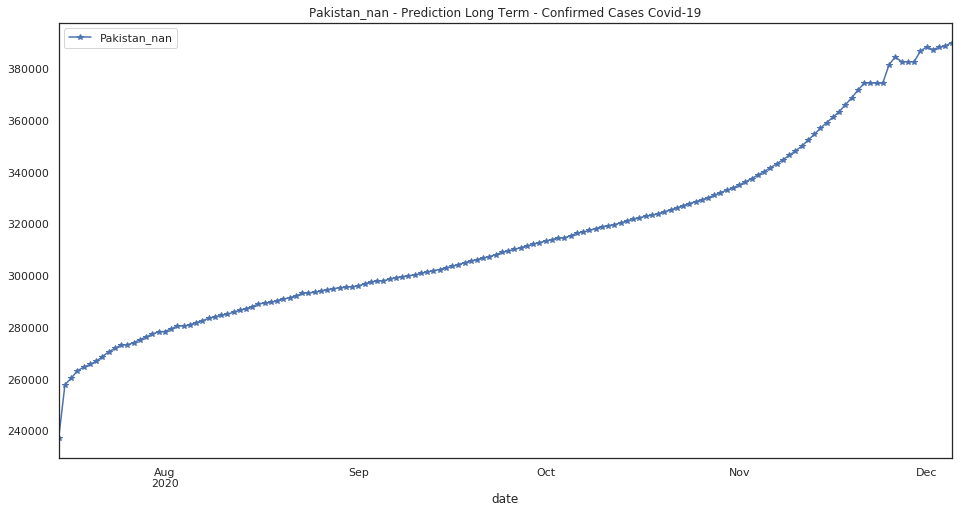

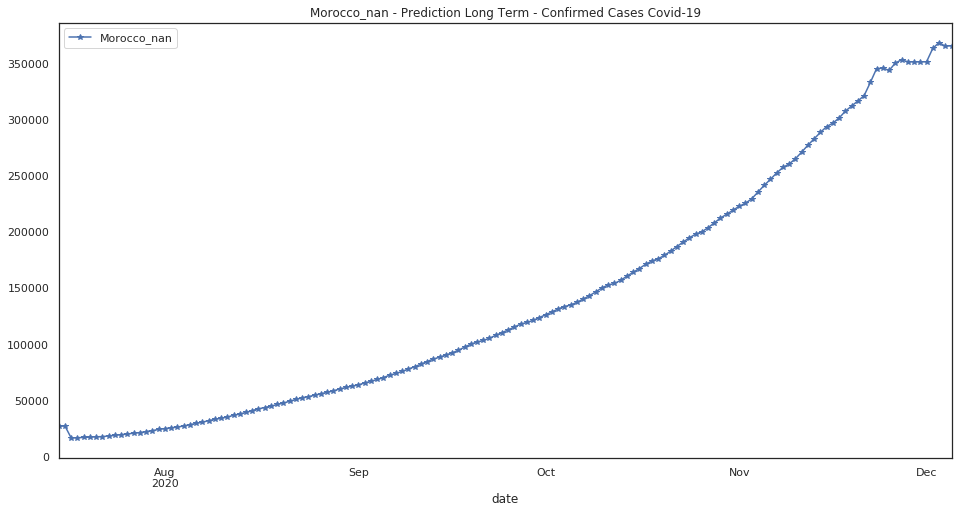

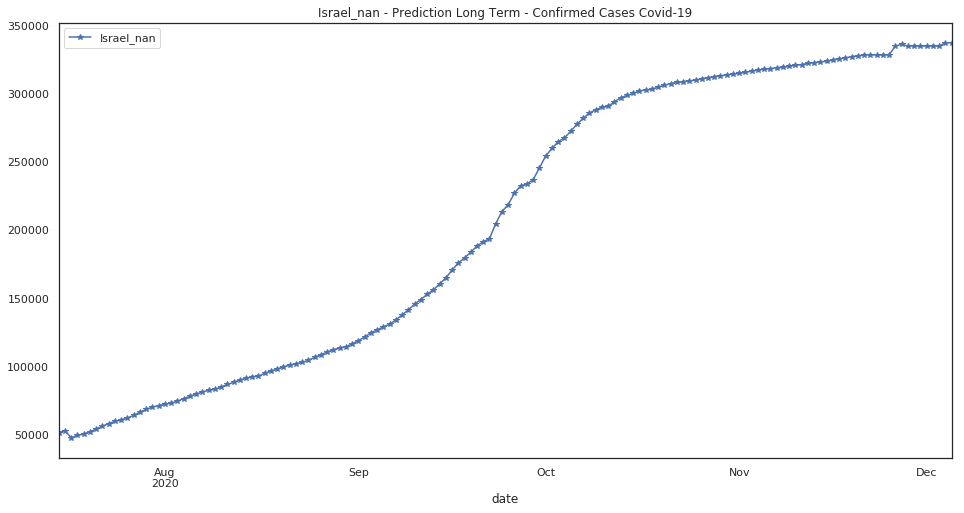

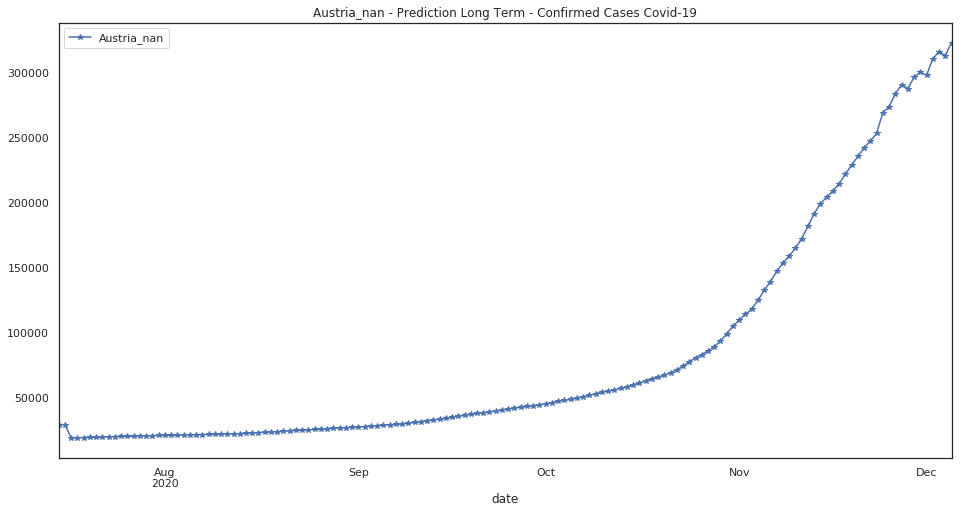

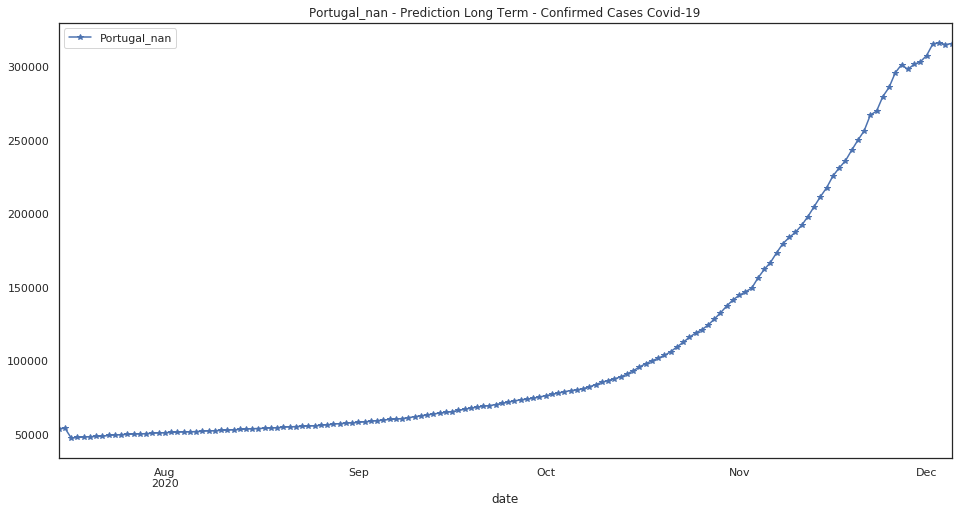

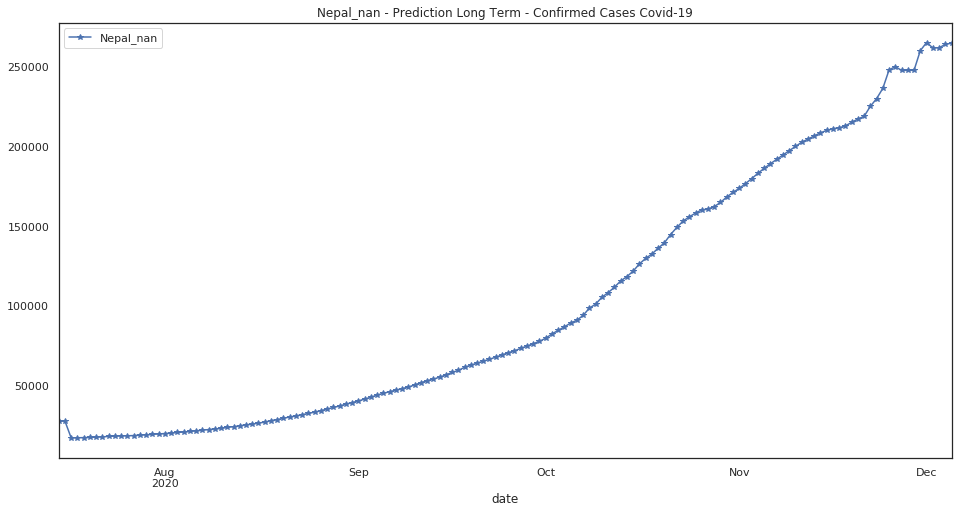

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

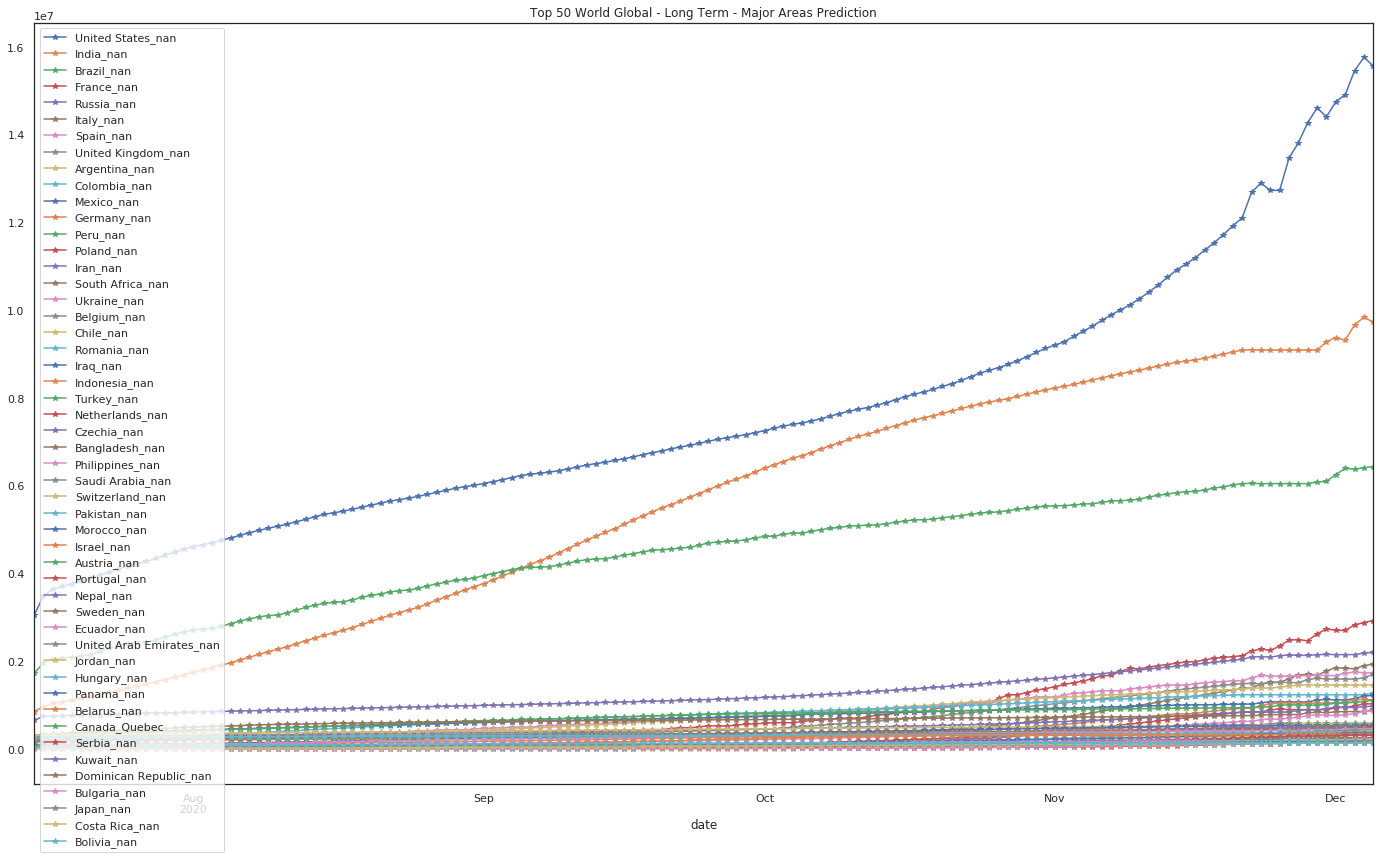

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

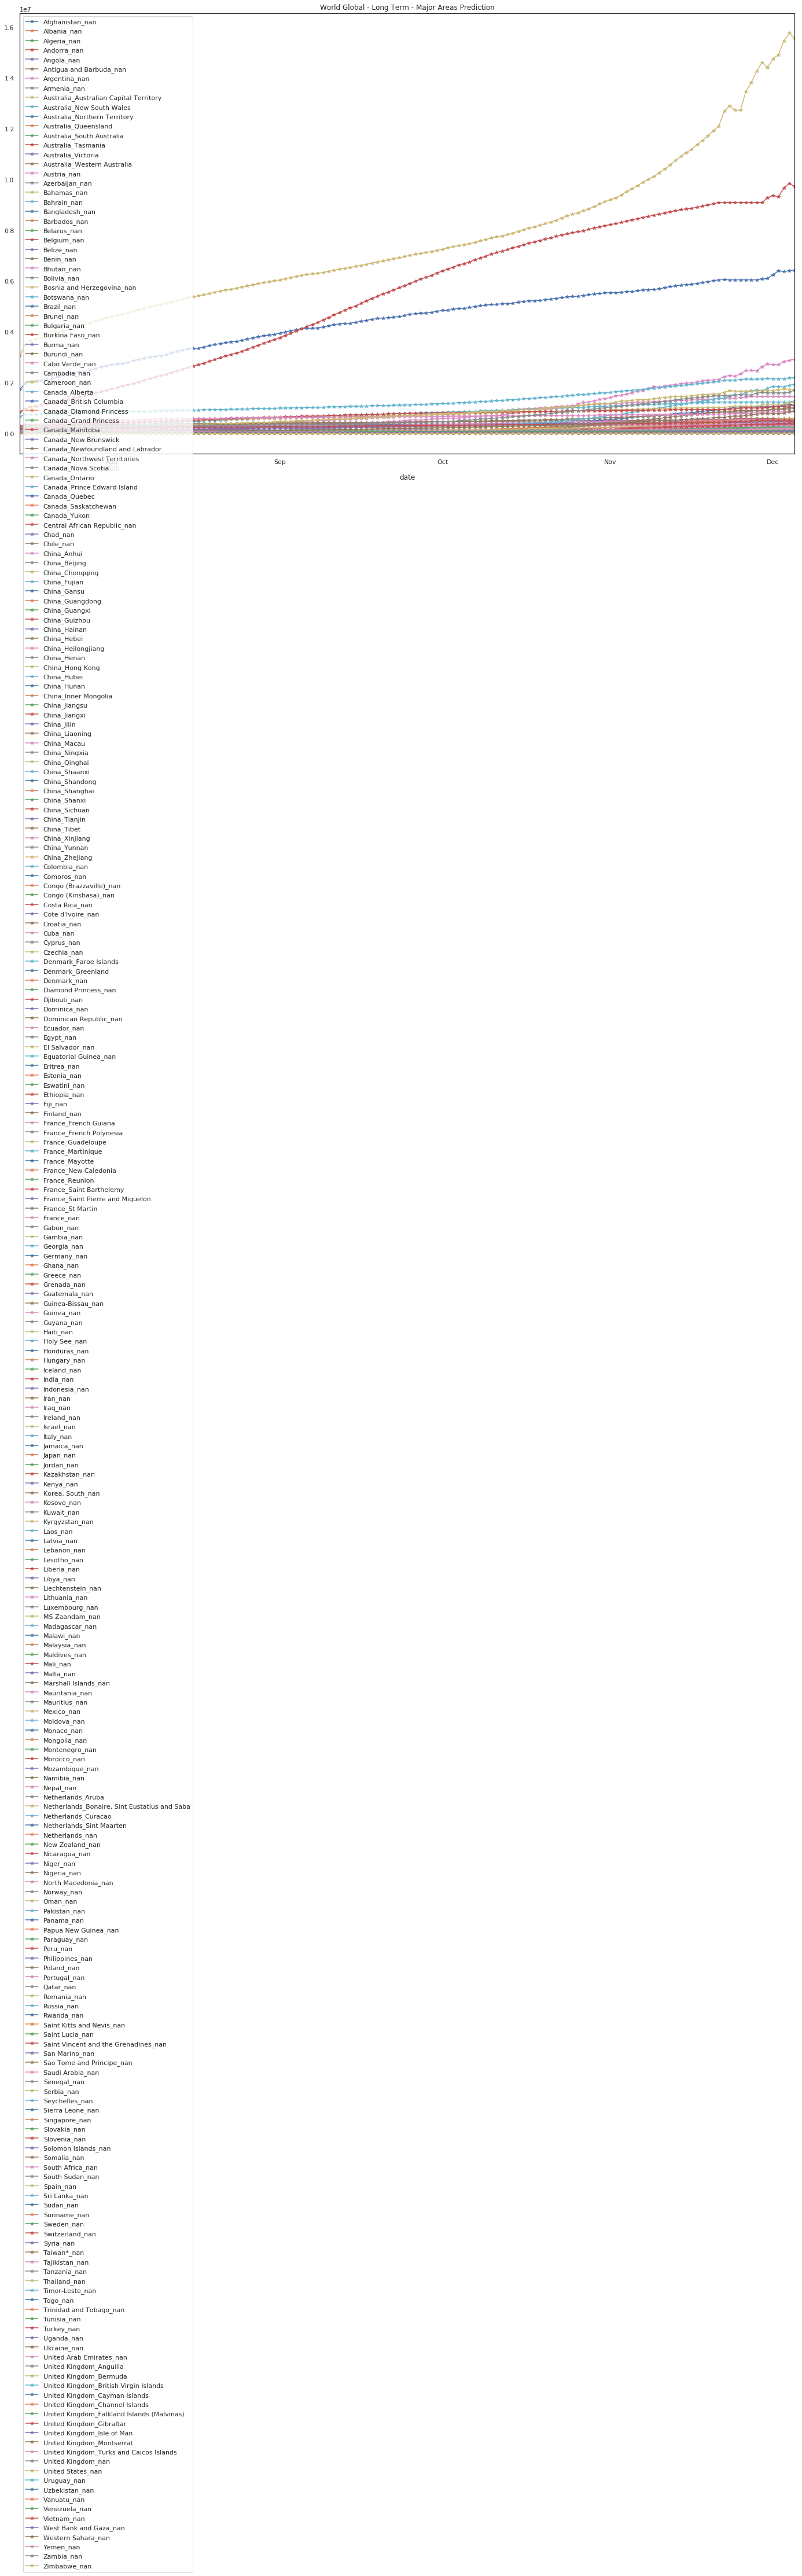

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38252.0       9325.0      43859.0       1124.0   
2020-08-30          38269.0       9450.0      44226.0       1215.0   
2020-08-31          38272.0       9554.0      44577.0       1260.0   
2020-09-01          38300.0       9613.0      44917.0       1176.0   
2020-09-02          38343.0       9775.0      45244.0       1225.0   
2020-09-03          38388.0       9858.0      45556.0       1199.0   
2020-09-04          38408.0       9985.0      45861.0       1303.0   
2020-09-05          38429.0      10113.0      46159.0       1215.0   
2020-09-06          38496.0      10255.0      46451.0       1296.0   
2020-09-07          38587.0      10393.0      46740.0       1336.0   
2020-09-08          38621.0      10546.0      47025.0       1261.0   
2020-09-09          38650.0      10705.0      47303.0       1377.0   
2020-09-10          38677.0      10859.0      47576.0       1301.0   
2020-09-11          38710.0      11018.0      47840.0       1422.0   
2020-09-12          38745.0      11181.0      48096.0       1344.0   
2020-09-13          38815.0      11349.0      48344.0       1435.0   
2020-09-14          38871.0      11515.0      48586.0       1517.0   
2020-09-15          38916.0      11672.0      48824.0       1438.0   
2020-09-16          38957.0      11832.0      49056.0       1593.0   
2020-09-17          38978.0      11972.0      49284.0       1483.0   
2020-09-18          38991.0      12107.0      49504.0       1648.0   
2020-09-19          39024.0      12261.0      49714.0       1564.0   
2020-09-20          39136.0      12396.0      49918.0       1673.0   
2020-09-21          39173.0      12543.0      50115.0       1775.0   
2020-09-22          39201.0      12685.0      50306.0       1681.0   
2020-09-23          39247.0      12821.0      50492.0       1854.0   
2020-09-24          39274.0      12960.0      50671.0       1753.0   
2020-09-25          39292.0      13075.0      50846.0       1922.0   
2020-09-26          39300.0      13193.0      51008.0       1836.0   
2020-09-27          39332.0      13310.0      51161.0       1924.0   
...                     ...          ...          ...          ...   
2020-11-06          42077.0      23155.0      60868.0       5135.0   
2020-11-07          42135.0      23636.0      61457.0       5135.0   
2020-11-08          42193.0      24145.0      62116.0       5319.0   
2020-11-09          42380.0      24672.0      62772.0       5383.0   
2020-11-10          42547.0      25232.0      63512.0       5437.0   
2020-11-11          42697.0      25744.0      64327.0       5477.0   
2020-11-12          42878.0      26186.0      65180.0       5567.0   
2020-11-13          43054.0      26690.0      66049.0       5616.0   
2020-11-14          43136.0      27198.0      66900.0       5725.0   
2020-11-15          43326.0      27780.0      67759.0       5725.0   
2020-11-16          43493.0      28372.0      68667.0       5872.0   
2020-11-17          43711.0      29058.0      69665.0       5914.0   
2020-11-18          43933.0      29755.0      70709.0       5951.0   
2020-11-19          44291.0      30536.0      71739.0       6018.0   
2020-11-20          44526.0      31365.0      72832.0       6066.0   
2020-11-21          44609.0      32119.0      73873.0       6142.0   
2020-11-22          45208.0      32237.0      73999.0       6207.0   
2020-11-23          46667.0      34248.0      77372.0       6470.0   
2020-11-24          46878.0      35049.0      78332.0       6515.0   
2020-11-25          46883.0      35352.0      77885.0       6515.0   
2020-11-26          49292.0      37082.0      81287.0       6699.0   
2020-11-27          49931.0      37198.0      82290.0       6699.0   
2020-11-28          49958.0      37322.0      84645.0       6793.0   
2020-11-29          53026.0      38195.0      87410.0       6793.0   
2020-11-30

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
245                             Timor-Leste_nan  -8.874217  125.727539   
246                                    Togo_nan   8.619500    0.824800   
247                     Trinidad and Tobago_nan  10.691800  -61.222500   
248                                 Tunisia_nan  33.886917    9.537499   
249                                  Turkey_nan  38.963700   35.243300   
250                           United States_nan  40.000000 -100.000000   
251                                  Uganda_nan   1.373333   32.290275   
252                                 Ukraine_nan  48.379400   31.165600   
253                    United Arab Emirates_nan  23.424076   53.847818   
254                     United Kingdom_Anguilla  18.220600  -63.068600   
255                      United Kingdom_Bermuda  32.307800  -64.750500   
256       United Kingdom_British Virgin Islands  18.420700  -64.640000   
257               United Kingdom_Cayman Islands  19.313300  -81.254600   
258              United Kingdom_Channel Islands  49.372300   -2.364400   
259  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
260                    United Kingdom_Gibraltar  36.140800   -5.353600   
261                  United Kingdom_Isle of Man  54.236100   -4.548100   
262                   United Kingdom_Montserrat  16.742498  -62.187366   
263     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
264                          United Kingdom_nan  55.378100   -3.436000   
265                                 Uruguay_nan -32.522800  -55.765800   
266                              Uzbekistan_nan  41.377491   64.585262   
267                                 Vanuatu_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      22               Belarus_nan  53.709800   27.953400   
4      23               Belgium_nan  50.833300    4.469936   
5      30                Brazil_nan -14.235000  -51.925300   
6      32              Bulgaria_nan  42.733900   25.485800   
7      52             Canada_Quebec  52.939900  -73.549100   
8      57                 Chile_nan -35.675100  -71.543000   
9      91              Colombia_nan   4.570900  -74.297300   
10     95            Costa Rica_nan   9.748900  -83.753400   
11     97               Croatia_nan  45.100000   15.200000   
12    100               Czechia_nan  49.817500   15.473000   
13    107    Dominican Republic_nan  18.735700  -70.162700   
14    108               Ecuador_nan  -1.831200  -78.183400   
15    128                France_nan  46.227600    2.213700   
16    133               Germany_nan  51.165691   10.451526   
17    145               Hungary_nan  47.162500   19.503300   
18    147                 India_nan  20.593684   78.962880   
19    148             Indonesia_nan  -0.789300  113.921300   
20    149                  Iran_nan  32.427908   53.688046   
21    150                  Iraq_nan  33.223191   43.679291   
22    152                Israel_nan  31.046051   34.851612   
23    153                Israel_nan  31.046051   34.851612   
24    154                 Italy_nan  41.871940   12.567380   
25    156                 Japan_nan  36.204824  138.252924   
26    157                Jordan_nan  31.240000   36.510000   
27    162                Kuwait_nan  29.311660   47.481766   
28    184                Mexico_nan  23.634500 -102.552800   
29    189               Morocco_nan  31.791700   -7.092600   
30    192                 Nepal_nan  28.166700   84.250000   
31    197           Netherlands_nan  52.132600    5.291300   
32    205              Pakistan_nan  30.375300   69.345100   
33    206                Panama_nan   8.538000  -80.782100   
34    209                  Peru_nan  -9.190000  -75.015200   
35    210           Philippines_nan  12.879721  121.774017   
36    211                Poland_nan  51.919400   19.145100   
37    212              Portugal_nan  39.399900   -8.224500   
38    214               Romania_nan  45.943200   24.966800   
39    215                Russia_nan  61.524010  105.318756   
40    222          Saudi Arabia_nan  23.885942   45.079162   
41    224                Serbia_nan  44.016500   21.005900   
42    232          South Africa_nan -30.559500   22.937500   
43    234                 Spain_nan  40.463667   -3.749220   
44    238                Sweden_nan  60.128161   18.643501   
45    239           Switzerland_nan  46.818200    8.227500   
46    249                Turkey_nan  38.963700   35.243300   
47    250         United States_nan  40.000000 -100.000000   
48    252               Ukraine_nan  48.379400   31.165600   
49    253  United Arab Emirates_nan  23.424076   53.847818   
50    264        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              109553.0             112720.0             118466.0   
1               29460.0              29561.0              19270.0   
2              181333.0             193590.0             198656.0   
3               69762.0              69918.0              65623.0   
4               67523.0              67842.0              63238.0   
5             1725143.0            1966748.0            2052890.0   
6               19641.0              19874.0               8144.0   
7               62288.0              62411.0              57001.0   
8              292442.0             321205.0             325611.0   
9              156589.0             165169.0             181776.0   
10              2060

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()